In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
cuda = torch.cuda.is_available()
cuda =False
device = 'cuda' if cuda else 'cpu'
%matplotlib inline

In [3]:
# Overview of ID class names and class identifiers
class_dict = {  "Abyssinian": 0,
                "american_bulldog": 1,
                "american_pit_bull_terrier": 2,
                "basset_hound": 3,
                "beagle": 4,
                "Bengal": 5,
                "Birman": 6,
                "Bombay": 7,
                "boxer": 8,
                "British_Shorthair": 9,
                "chihuahua": 10,
                "Egyptian_Mau": 11,
                "english_cocker_spaniel": 12,
                "english_setter": 13,
                "german_shorthaired": 14,
                "great_pyrenees": 15,
                "havanese": 16,
                "japanese_chin": 17,
                "keeshond": 18,
                "leonberger": 19,
                "Maine_Coon": 20,
                "miniature_pinscher": 21,
                "newfoundland": 22,
                "Persian": 23,
                "pomeranian": 24,
                "pug": 25,
                "Ragdoll": 26,
                "Russian_Blue": 27,
                "saint_bernard": 28,
                "samoyed": 29,
                "scottish_terrier": 30,
                "shiba_inu": 31,
                "Siamese": 32,
                "Sphynx": 33,
                "staffordshire_bull_terrier": 34,
                "wheaten_terrier": 35,
                "yorkshire_terrier": 36}

In [4]:
# Import cats and dogs dataset
all_images_path = ".\cats_and_dogs\images"

# Train/val split with 90/10
import glob
from PIL import Image
from torchvision.transforms import ToTensor
import re

batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Custom image dataset to properly load cats and dogs
#  one of the issues was naming the images and assigning them to the correct class in a weird file structure
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        img_paths_bad = glob.glob(os.path.join(root_dir, '*.jpg'))  # Cats and dogs only uses .jpg files

        img_paths = [i.replace("\\", "/") for i in img_paths_bad]

        for img_path in img_paths:
            label = os.path.splitext(os.path.basename(img_path))[0]  # Extract label from filename
            self.image_paths.append(img_path)
            self.labels.append(label)

        labs = [class_dict[re.sub(r'_\d+', '', i)] for i in self.labels]
        self.labels = labs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # When requesting item from the dataset, this returns the correct image, label combination
        #  This is in line with the required pytorch format of a custom dataset https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = CustomImageDataset(root_dir="cats_and_dogs/images", transform=all_transform)
n_val = int(0.1 * len(dataset))

# Split the dataset and update the train transformer
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


In [5]:
# On just imagenet 0
# exp3_cd_resnet1.pth 60
# exp3_cd_resnet2.pth 70
# exp3_cd_resnet25.pth 82 Get from EXP1&2

In [7]:
# Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats and dogs
from torchvision.models import resnet18, ResNet18_Weights

pretrained_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Unlock layers
for param in pretrained_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 37
num_classes = len(class_dict.items())
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_resnet.parameters(), lr=0.001, momentum=0.9)

# Load in the trained models
exp3_res1 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in exp3_res1.parameters():
    param.requires_grad = True
num_classes = len(class_dict.items())
exp3_res1.fc = nn.Linear(exp3_res1.fc.in_features, num_classes)
exp3_res1.load_state_dict(torch.load('exp3_cd_resnet1.pth', map_location=torch.device('cpu')))
exp3_res1.eval()

exp3_res2 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in exp3_res2.parameters():
    param.requires_grad = True
num_classes = len(class_dict.items())
exp3_res2.fc = nn.Linear(exp3_res2.fc.in_features, num_classes)
exp3_res2.load_state_dict(torch.load('exp3_cd_resnet2.pth', map_location=torch.device('cpu')))
exp3_res2.eval()

exp3_res25 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in exp3_res25.parameters():
    param.requires_grad = True
num_classes = len(class_dict.items())
exp3_res25.fc = nn.Linear(exp3_res25.fc.in_features, num_classes)
exp3_res25.load_state_dict(torch.load('exp3_cd_resnet25.pth', map_location=torch.device('cpu')))
exp3_res25.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Load OOD dataset
from torch.utils.data import Subset
from PIL import Image
import glob

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

s1ood_dataset = ImageFolder(root='imagenet_val', transform=preprocess)
s1OOD_Dataloader = DataLoader(s1ood_dataset, batch_size=32, shuffle=True)
s1nearood_dataset = ImageFolder(root='AnimalnearOOD', transform=preprocess)
s1farood_dataset = ImageFolder(root='imgnetFar', transform=preprocess)
s1nearOOD_Dataloader = DataLoader(s1nearood_dataset, batch_size=32, shuffle=True)
s1farOOD_Dataloader = DataLoader(s1farood_dataset, batch_size=32, shuffle=True)

s2ood_dataset = ImageFolder(root='ood23', transform=preprocess)
s2OOD_Dataloader = DataLoader(s2ood_dataset, batch_size=32, shuffle=True)
s2nearood_dataset = ImageFolder(root='ood23far', transform=preprocess)
s23farood_dataset = ImageFolder(root='ood23near', transform=preprocess)
s2nearOOD_Dataloader = DataLoader(s2nearood_dataset, batch_size=32, shuffle=True)
s23farOOD_Dataloader = DataLoader(s23farood_dataset, batch_size=32, shuffle=True)

### OOD detection methods
These methods were taken from different sources. 
Odin, MSP and Energy I got from here https://github.com/deeplearning-wisc/large_scale_ood/blob/master/test_baselines.py

DDU from https://github.com/omegafragger/DDU/blob/main/utils/gmm_utils.py which required a lot of adapting

Mahalanobis I created myself

In [10]:
def iterate_data_odin(data_loader, model, epsilon=0.0014, temper=1000):
    criterion = torch.nn.CrossEntropyLoss()
    confs = []
    loader_y = []
    y_pred = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        x = Variable(x, requires_grad=True)
        outputs = model(x)

        maxIndexTemp = np.argmax(outputs.data.cpu().numpy(), axis=1)
        outputs = outputs / temper

        labels = Variable(torch.LongTensor(maxIndexTemp))
        y_pred.append(labels)
        loss = criterion(outputs, labels)
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = torch.ge(x.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2

        # Adding small perturbations to images
        tempInputs = torch.add(x.data, gradient, alpha=-epsilon)
        outputs = model(Variable(tempInputs))
        outputs = outputs / temper
        # Calculating the confidence after adding perturbations
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        nnOutputs = nnOutputs - np.max(nnOutputs, axis=1, keepdims=True)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs), axis=1, keepdims=True)

        confs.extend(np.max(nnOutputs, axis=1))

    return np.array(confs), loader_y, y_pred

s12_pt_odin_in_scores, s12_pt_odin_in_y, s12_pt_odin_in_y_pred = iterate_data_odin(train_loader, pretrained_resnet)
s12_res1_odin_in_scores, s12_res1_odin_in_y, s12_res1_odin_in_y_pred = iterate_data_odin(train_loader, exp3_res1)
s12_res2_odin_in_scores, s12_res2_odin_in_y, s12_res2_odin_in_y_pred = iterate_data_odin(train_loader, exp3_res2)
s12_res25_odin_in_scores, s12_res25_odin_in_y, s12_res25_odin_in_y_pred = iterate_data_odin(train_loader, exp3_res25)
s1_pt_odin_out_scores, s1_pt_odin_out_y, s1_pt_odin_out_y_pred = iterate_data_odin(s1OOD_Dataloader, pretrained_resnet)
s1_res1_odin_out_scores, s1_res1_odin_out_y, s1_res1_odin_out_y_pred = iterate_data_odin(s1OOD_Dataloader, exp3_res1)
s1_res2_odin_out_scores, s1_res2_odin_out_y, s1_res2_odin_out_y_pred = iterate_data_odin(s1OOD_Dataloader, exp3_res2)
s1_res25_odin_out_scores, s1_res25_odin_out_y, s1_res25_odin_out_y_pred = iterate_data_odin(s1OOD_Dataloader, exp3_res25)
s2_pt_odin_out_scores, s2_pt_odin_out_y, s2_pt_odin_out_y_pred = iterate_data_odin(s2OOD_Dataloader, pretrained_resnet)
s2_res1_odin_out_scores, s2_res1_odin_out_y, s2_res1_odin_out_y_pred = iterate_data_odin(s2OOD_Dataloader, exp3_res1)
s2_res2_odin_out_scores, s2_res2_odin_out_y, s2_res2_odin_out_y_pred = iterate_data_odin(s2OOD_Dataloader, exp3_res2)
s2_res25_odin_out_scores, s2_res25_odin_out_y, s2_res25_odin_out_y_pred = iterate_data_odin(s2OOD_Dataloader, exp3_res25)


s12_pt_odin_in_examples = s12_pt_odin_in_scores.reshape((-1, 1))
s12_res1_odin_in_examples = s12_res1_odin_in_scores.reshape((-1, 1))
s12_res2_odin_in_examples = s12_res2_odin_in_scores.reshape((-1, 1))
s12_res25_odin_in_examples = s12_res25_odin_in_scores.reshape((-1, 1))
s1_pt_odin_out_examples = s1_pt_odin_out_scores.reshape((-1, 1))
s1_res1_odin_out_examples = s1_res1_odin_out_scores.reshape((-1, 1))
s1_res2_odin_out_examples = s1_res2_odin_out_scores.reshape((-1, 1))
s1_res25_odin_out_examples = s1_res25_odin_out_scores.reshape((-1, 1))
s2_pt_odin_out_examples = s2_pt_odin_out_scores.reshape((-1, 1))
s2_res1_odin_out_examples = s2_res1_odin_out_scores.reshape((-1, 1))
s2_res2_odin_out_examples = s2_res2_odin_out_scores.reshape((-1, 1))
s2_res25_odin_out_examples = s2_res25_odin_out_scores.reshape((-1, 1))

first done
s12 odin done
s1 odin done
s2 odin done


In [12]:
np.save('exp3saves/s12_pt_odin_in_examples.npy', s12_pt_odin_in_examples)
np.save('exp3saves/s12_res1_odin_in_examples.npy', s12_res1_odin_in_examples)
np.save('exp3saves/s12_res2_odin_in_examples.npy', s12_res2_odin_in_examples)
np.save('exp3saves/s12_res25_odin_in_examples.npy', s12_res25_odin_in_examples)
np.save('exp3saves/s1_pt_odin_out_examples.npy', s1_pt_odin_out_examples)
np.save('exp3saves/s1_res1_odin_out_examples.npy', s1_res1_odin_out_examples)
np.save('exp3saves/s1_res2_odin_out_examples.npy', s1_res2_odin_out_examples)
np.save('exp3saves/s1_res25_odin_out_examples.npy', s1_res25_odin_out_examples)
np.save('exp3saves/s2_pt_odin_out_examples.npy', s2_pt_odin_out_examples)
np.save('exp3saves/s2_res1_odin_out_examples.npy', s2_res1_odin_out_examples)
np.save('exp3saves/s2_res2_odin_out_examples.npy', s2_res2_odin_out_examples)
np.save('exp3saves/s2_res25_odin_out_examples.npy', s2_res25_odin_out_examples)

# s12_pt_odin_in_examples = np.load('exp3saves/s12_pt_odin_in_examples.npy')
# s12_res1_odin_in_examples = np.load('exp3saves/s12_res1_odin_in_examples.npy')
# s12_res2_odin_in_examples = np.load('exp3saves/s12_res2_odin_in_examples.npy')
# s12_res25_odin_in_examples = np.load('exp3saves/s12_res25_odin_in_examples.npy')
# s1_pt_odin_out_examples = np.load('exp3saves/s1_pt_odin_out_examples.npy')
# s1_res1_odin_out_examples = np.load('exp3saves/s1_res1_odin_out_examples.npy')
# s1_res2_odin_out_examples = np.load('exp3saves/s1_res2_odin_out_examples.npy')
# s1_res25_odin_out_examples = np.load('exp3saves/s1_res25_odin_out_examples.npy')
# s2_pt_odin_out_examples = np.load('exp3saves/s2_pt_odin_out_examples.npy')
# s2_res1_odin_out_examples = np.load('exp3saves/s2_res1_odin_out_examples.npy')
# s2_res2_odin_out_examples = np.load('exp3saves/s2_res2_odin_out_examples.npy')
# s2_res25_odin_out_examples = np.load('exp3saves/s2_res25_odin_out_examples.npy')


flat_s12_pt_odin_in_y = [value.item() for tensor in s12_pt_odin_in_y for value in tensor]
flat_s12_res1_odin_in_y = [value.item() for tensor in s12_res1_odin_in_y for value in tensor]
flat_s12_res2_odin_in_y = [value.item() for tensor in s12_res2_odin_in_y for value in tensor]
flat_s12_res25_odin_in_y = [value.item() for tensor in s12_res25_odin_in_y for value in tensor]
flat_s1_pt_odin_out_y = [value.item() for tensor in s1_pt_odin_out_y for value in tensor]
flat_s1_res1_odin_out_y = [value.item() for tensor in s1_res1_odin_out_y for value in tensor]
flat_s1_res2_odin_out_y = [value.item() for tensor in s1_res2_odin_out_y for value in tensor]
flat_s1_res25_odin_out_y = [value.item() for tensor in s1_res25_odin_out_y for value in tensor]
flat_s2_pt_odin_out_y = [value.item() for tensor in s2_pt_odin_out_y for value in tensor]
flat_s2_res1_odin_out_y = [value.item() for tensor in s2_res1_odin_out_y for value in tensor]
flat_s2_res2_odin_out_y = [value.item() for tensor in s2_res2_odin_out_y for value in tensor]
flat_s2_res25_odin_out_y = [value.item() for tensor in s2_res25_odin_out_y for value in tensor]
flat_s12_pt_odin_in_y_pred = [value.item() for tensor in s12_pt_odin_in_y_pred for value in tensor]
flat_s12_res1_odin_in_y_pred = [value.item() for tensor in s12_res1_odin_in_y_pred for value in tensor]
flat_s12_res2_odin_in_y_pred = [value.item() for tensor in s12_res2_odin_in_y_pred for value in tensor]
flat_s12_res25_odin_in_y_pred = [value.item() for tensor in s12_res25_odin_in_y_pred for value in tensor]
flat_s1_pt_odin_out_y_pred = [value.item() for tensor in s1_pt_odin_out_y_pred for value in tensor]
flat_s1_res1_odin_out_y_pred = [value.item() for tensor in s1_res1_odin_out_y_pred for value in tensor]
flat_s1_res2_odin_out_y_pred = [value.item() for tensor in s1_res2_odin_out_y_pred for value in tensor]
flat_s1_res25_odin_out_y_pred = [value.item() for tensor in s1_res25_odin_out_y_pred for value in tensor]
flat_s2_pt_odin_out_y_pred = [value.item() for tensor in s2_pt_odin_out_y_pred for value in tensor]
flat_s2_res1_odin_out_y_pred = [value.item() for tensor in s2_res1_odin_out_y_pred for value in tensor]
flat_s2_res2_odin_out_y_pred = [value.item() for tensor in s2_res2_odin_out_y_pred for value in tensor]
flat_s2_res25_odin_out_y_pred = [value.item() for tensor in s2_res25_odin_out_y_pred for value in tensor]

np.save('exp3saves/flat_s12_pt_odin_in_y.npy', flat_s12_pt_odin_in_y)
np.save('exp3saves/flat_s12_res1_odin_in_y.npy', flat_s12_res1_odin_in_y)
np.save('exp3saves/flat_s12_res2_odin_in_y.npy', flat_s12_res2_odin_in_y)
np.save('exp3saves/flat_s12_res25_odin_in_y.npy', flat_s12_res25_odin_in_y)
np.save('exp3saves/flat_s1_pt_odin_out_y.npy', flat_s1_pt_odin_out_y)
np.save('exp3saves/flat_s1_res1_odin_out_y.npy', flat_s1_res1_odin_out_y)
np.save('exp3saves/flat_s1_res2_odin_out_y.npy', flat_s1_res2_odin_out_y)
np.save('exp3saves/flat_s1_res25_odin_out_y.npy', flat_s1_res25_odin_out_y)
np.save('exp3saves/flat_s2_pt_odin_out_y.npy', flat_s2_pt_odin_out_y)
np.save('exp3saves/flat_s2_res1_odin_out_y.npy', flat_s2_res1_odin_out_y)
np.save('exp3saves/flat_s2_res2_odin_out_y.npy', flat_s2_res2_odin_out_y)
np.save('exp3saves/flat_s2_res25_odin_out_y.npy', flat_s2_res25_odin_out_y)
np.save('exp3saves/flat_s12_pt_odin_in_y_pred.npy', flat_s12_pt_odin_in_y_pred)
np.save('exp3saves/flat_s12_res1_odin_in_y_pred.npy', flat_s12_res1_odin_in_y_pred)
np.save('exp3saves/flat_s12_res2_odin_in_y_pred.npy', flat_s12_res2_odin_in_y_pred)
np.save('exp3saves/flat_s12_res25_odin_in_y_pred.npy', flat_s12_res25_odin_in_y_pred)
np.save('exp3saves/flat_s1_pt_odin_out_y_pred.npy', flat_s1_pt_odin_out_y_pred)
np.save('exp3saves/flat_s1_res1_odin_out_y_pred.npy', flat_s1_res1_odin_out_y_pred)
np.save('exp3saves/flat_s1_res2_odin_out_y_pred.npy', flat_s1_res2_odin_out_y_pred)
np.save('exp3saves/flat_s1_res25_odin_out_y_pred.npy', flat_s1_res25_odin_out_y_pred)
np.save('exp3saves/flat_s2_pt_odin_out_y_pred.npy', flat_s2_pt_odin_out_y_pred)
np.save('exp3saves/flat_s2_res1_odin_out_y_pred.npy', flat_s2_res1_odin_out_y_pred)
np.save('exp3saves/flat_s2_res2_odin_out_y_pred.npy', flat_s2_res2_odin_out_y_pred)
np.save('exp3saves/flat_s2_res25_odin_out_y_pred.npy', flat_s2_res25_odin_out_y_pred)


# flat_s12_pt_odin_in_y = np.load('exp3saves/flat_s12_pt_odin_in_y.npy')
# flat_s12_res1_odin_in_y = np.load('exp3saves/flat_s12_res1_odin_in_y.npy')
# flat_s12_res2_odin_in_y = np.load('exp3saves/flat_s12_res2_odin_in_y.npy')
# flat_s12_res25_odin_in_y = np.load('exp3saves/flat_s12_res25_odin_in_y.npy')
# flat_s1_pt_odin_out_y = np.load('exp3saves/flat_s1_pt_odin_out_y.npy')
# flat_s1_res1_odin_out_y = np.load('exp3saves/flat_s1_res1_odin_out_y.npy')
# flat_s1_res2_odin_out_y = np.load('exp3saves/flat_s1_res2_odin_out_y.npy')
# flat_s1_res25_odin_out_y = np.load('exp3saves/flat_s1_res25_odin_out_y.npy')
# flat_s2_pt_odin_out_y = np.load('exp3saves/flat_s2_pt_odin_out_y.npy')
# flat_s2_res1_odin_out_y = np.load('exp3saves/flat_s2_res1_odin_out_y.npy')
# flat_s2_res2_odin_out_y = np.load('exp3saves/flat_s2_res2_odin_out_y.npy')
# flat_s2_res25_odin_out_y = np.load('exp3saves/flat_s2_res25_odin_out_y.npy')
# flat_s12_pt_odin_in_y_pred = np.load('exp3saves/flat_s12_pt_odin_in_y_pred.npy')
# flat_s12_res1_odin_in_y_pred = np.load('exp3saves/flat_s12_res1_odin_in_y_pred.npy')
# flat_s12_res2_odin_in_y_pred = np.load('exp3saves/flat_s12_res2_odin_in_y_pred.npy')
# flat_s12_res25_odin_in_y_pred = np.load('exp3saves/flat_s12_res25_odin_in_y_pred.npy')
# flat_s1_pt_odin_out_y_pred = np.load('exp3saves/flat_s1_pt_odin_out_y_pred.npy')
# flat_s1_res1_odin_out_y_pred = np.load('exp3saves/flat_s1_res1_odin_out_y_pred.npy')
# flat_s1_res2_odin_out_y_pred = np.load('exp3saves/flat_s1_res2_odin_out_y_pred.npy')
# flat_s1_res25_odin_out_y_pred = np.load('exp3saves/flat_s1_res25_odin_out_y_pred.npy')
# flat_s2_pt_odin_out_y_pred = np.load('exp3saves/flat_s2_pt_odin_out_y_pred.npy')
# flat_s2_res1_odin_out_y_pred = np.load('exp3saves/flat_s2_res1_odin_out_y_pred.npy')
# flat_s2_res2_odin_out_y_pred = np.load('exp3saves/flat_s2_res2_odin_out_y_pred.npy')
# flat_s2_res25_odin_out_y_pred = np.load('exp3saves/flat_s2_res25_odin_out_y_pred.npy')

In [11]:
def iterate_data_energy(data_loader, model, temper=1):
    confs = []
    loader_y = []
    y_pred = list()
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            labels = Variable(torch.LongTensor(np.argmax(logits.data.cpu().numpy(), axis=1)))
            y_pred.append(labels)

            conf = temper * torch.logsumexp(logits / temper, dim=1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y, y_pred
    

s12_pt_energy_in_scores, s12_pt_energy_in_y, s12_pt_energy_in_y_pred = iterate_data_energy(train_loader, pretrained_resnet)
s12_res1_energy_in_scores, s12_res1_energy_in_y, s12_res1_energy_in_y_pred = iterate_data_energy(train_loader, exp3_res1)
s12_res2_energy_in_scores, s12_res2_energy_in_y, s12_res2_energy_in_y_pred = iterate_data_energy(train_loader, exp3_res2)
s12_res25_energy_in_scores, s12_res25_energy_in_y, s12_res25_energy_in_y_pred = iterate_data_energy(train_loader, exp3_res25)
s1_pt_energy_out_scores, s1_pt_energy_out_y, s1_pt_energy_out_y_pred = iterate_data_energy(s1OOD_Dataloader, pretrained_resnet)
s1_res1_energy_out_scores, s1_res1_energy_out_y, s1_res1_energy_out_y_pred = iterate_data_energy(s1OOD_Dataloader, exp3_res1)
s1_res2_energy_out_scores, s1_res2_energy_out_y, s1_res2_energy_out_y_pred = iterate_data_energy(s1OOD_Dataloader, exp3_res2)
s1_res25_energy_out_scores, s1_res25_energy_out_y, s1_res25_energy_out_y_pred = iterate_data_energy(s1OOD_Dataloader, exp3_res25)
s2_pt_energy_out_scores, s2_pt_energy_out_y, s2_pt_energy_out_y_pred = iterate_data_energy(s2OOD_Dataloader, pretrained_resnet)
s2_res1_energy_out_scores, s2_res1_energy_out_y, s2_res1_energy_out_y_pred = iterate_data_energy(s2OOD_Dataloader, exp3_res1)
s2_res2_energy_out_scores, s2_res2_energy_out_y, s2_res2_energy_out_y_pred = iterate_data_energy(s2OOD_Dataloader, exp3_res2)
s2_res25_energy_out_scores, s2_res25_energy_out_y, s2_res25_energy_out_y_pred = iterate_data_energy(s2OOD_Dataloader, exp3_res25)




In [13]:
s12_pt_energy_in_examples = s12_pt_energy_in_scores.reshape((-1, 1))
s12_res1_energy_in_examples = s12_res1_energy_in_scores.reshape((-1, 1))
s12_res2_energy_in_examples = s12_res2_energy_in_scores.reshape((-1, 1))
s12_res25_energy_in_examples = s12_res25_energy_in_scores.reshape((-1, 1))
s1_pt_energy_out_examples = s1_pt_energy_out_scores.reshape((-1, 1))
s1_res1_energy_out_examples = s1_res1_energy_out_scores.reshape((-1, 1))
s1_res2_energy_out_examples = s1_res2_energy_out_scores.reshape((-1, 1))
s1_res25_energy_out_examples = s1_res25_energy_out_scores.reshape((-1, 1))
s2_pt_energy_out_examples = s2_pt_energy_out_scores.reshape((-1, 1))
s2_res1_energy_out_examples = s2_res1_energy_out_scores.reshape((-1, 1))
s2_res2_energy_out_examples = s2_res2_energy_out_scores.reshape((-1, 1))
s2_res25_energy_out_examples = s2_res25_energy_out_scores.reshape((-1, 1))

np.save('exp3saves/s12_pt_energy_in_examples.npy', s12_pt_energy_in_examples)
np.save('exp3saves/s12_res1_energy_in_examples.npy', s12_res1_energy_in_examples)
np.save('exp3saves/s12_res2_energy_in_examples.npy', s12_res2_energy_in_examples)
np.save('exp3saves/s12_res25_energy_in_examples.npy', s12_res25_energy_in_examples)
np.save('exp3saves/s1_pt_energy_out_examples.npy', s1_pt_energy_out_examples)
np.save('exp3saves/s1_res1_energy_out_examples.npy', s1_res1_energy_out_examples)
np.save('exp3saves/s1_res2_energy_out_examples.npy', s1_res2_energy_out_examples)
np.save('exp3saves/s1_res25_energy_out_examples.npy', s1_res25_energy_out_examples)
np.save('exp3saves/s2_pt_energy_out_examples.npy', s2_pt_energy_out_examples)
np.save('exp3saves/s2_res1_energy_out_examples.npy', s2_res1_energy_out_examples)
np.save('exp3saves/s2_res2_energy_out_examples.npy', s2_res2_energy_out_examples)
np.save('exp3saves/s2_res25_energy_out_examples.npy', s2_res25_energy_out_examples)

# s12_pt_energy_in_examples = np.load('exp3saves/s12_pt_energy_in_examples.npy')
# s12_res1_energy_in_examples = np.load('exp3saves/s12_res1_energy_in_examples.npy')
# s12_res2_energy_in_examples = np.load('exp3saves/s12_res2_energy_in_examples.npy')
# s12_res25_energy_in_examples = np.load('exp3saves/s12_res25_energy_in_examples.npy')
# s1_pt_energy_out_examples = np.load('exp3saves/s1_pt_energy_out_examples.npy')
# s1_res1_energy_out_examples = np.load('exp3saves/s1_res1_energy_out_examples.npy')
# s1_res2_energy_out_examples = np.load('exp3saves/s1_res2_energy_out_examples.npy')
# s1_res25_energy_out_examples = np.load('exp3saves/s1_res25_energy_out_examples.npy')
# s2_pt_energy_out_examples = np.load('exp3saves/s2_pt_energy_out_examples.npy')
# s2_res1_energy_out_examples = np.load('exp3saves/s2_res1_energy_out_examples.npy')
# s2_res2_energy_out_examples = np.load('exp3saves/s2_res2_energy_out_examples.npy')
# s2_res25_energy_out_examples = np.load('exp3saves/s2_res25_energy_out_examples.npy')


flat_s12_pt_energy_in_y = [value.item() for tensor in s12_pt_energy_in_y for value in tensor]
flat_s12_res1_energy_in_y = [value.item() for tensor in s12_res1_energy_in_y for value in tensor]
flat_s12_res2_energy_in_y = [value.item() for tensor in s12_res2_energy_in_y for value in tensor]
flat_s12_res25_energy_in_y = [value.item() for tensor in s12_res25_energy_in_y for value in tensor]
flat_s1_pt_energy_out_y = [value.item() for tensor in s1_pt_energy_out_y for value in tensor]
flat_s1_res1_energy_out_y = [value.item() for tensor in s1_res1_energy_out_y for value in tensor]
flat_s1_res2_energy_out_y = [value.item() for tensor in s1_res2_energy_out_y for value in tensor]
flat_s1_res25_energy_out_y = [value.item() for tensor in s1_res25_energy_out_y for value in tensor]
flat_s2_pt_energy_out_y = [value.item() for tensor in s2_pt_energy_out_y for value in tensor]
flat_s2_res1_energy_out_y = [value.item() for tensor in s2_res1_energy_out_y for value in tensor]
flat_s2_res2_energy_out_y = [value.item() for tensor in s2_res2_energy_out_y for value in tensor]
flat_s2_res25_energy_out_y = [value.item() for tensor in s2_res25_energy_out_y for value in tensor]
flat_s12_pt_energy_in_y_pred = [value.item() for tensor in s12_pt_energy_in_y_pred for value in tensor]
flat_s12_res1_energy_in_y_pred = [value.item() for tensor in s12_res1_energy_in_y_pred for value in tensor]
flat_s12_res2_energy_in_y_pred = [value.item() for tensor in s12_res2_energy_in_y_pred for value in tensor]
flat_s12_res25_energy_in_y_pred = [value.item() for tensor in s12_res25_energy_in_y_pred for value in tensor]
flat_s1_pt_energy_out_y_pred = [value.item() for tensor in s1_pt_energy_out_y_pred for value in tensor]
flat_s1_res1_energy_out_y_pred = [value.item() for tensor in s1_res1_energy_out_y_pred for value in tensor]
flat_s1_res2_energy_out_y_pred = [value.item() for tensor in s1_res2_energy_out_y_pred for value in tensor]
flat_s1_res25_energy_out_y_pred = [value.item() for tensor in s1_res25_energy_out_y_pred for value in tensor]
flat_s2_pt_energy_out_y_pred = [value.item() for tensor in s2_pt_energy_out_y_pred for value in tensor]
flat_s2_res1_energy_out_y_pred = [value.item() for tensor in s2_res1_energy_out_y_pred for value in tensor]
flat_s2_res2_energy_out_y_pred = [value.item() for tensor in s2_res2_energy_out_y_pred for value in tensor]
flat_s2_res25_energy_out_y_pred = [value.item() for tensor in s2_res25_energy_out_y_pred for value in tensor]

np.save('exp3saves/flat_s12_pt_energy_in_y.npy', flat_s12_pt_energy_in_y)
np.save('exp3saves/flat_s12_res1_energy_in_y.npy', flat_s12_res1_energy_in_y)
np.save('exp3saves/flat_s12_res2_energy_in_y.npy', flat_s12_res2_energy_in_y)
np.save('exp3saves/flat_s12_res25_energy_in_y.npy', flat_s12_res25_energy_in_y)
np.save('exp3saves/flat_s1_pt_energy_out_y.npy', flat_s1_pt_energy_out_y)
np.save('exp3saves/flat_s1_res1_energy_out_y.npy', flat_s1_res1_energy_out_y)
np.save('exp3saves/flat_s1_res2_energy_out_y.npy', flat_s1_res2_energy_out_y)
np.save('exp3saves/flat_s1_res25_energy_out_y.npy', flat_s1_res25_energy_out_y)
np.save('exp3saves/flat_s2_pt_energy_out_y.npy', flat_s2_pt_energy_out_y)
np.save('exp3saves/flat_s2_res1_energy_out_y.npy', flat_s2_res1_energy_out_y)
np.save('exp3saves/flat_s2_res2_energy_out_y.npy', flat_s2_res2_energy_out_y)
np.save('exp3saves/flat_s2_res25_energy_out_y.npy', flat_s2_res25_energy_out_y)
np.save('exp3saves/flat_s12_pt_energy_in_y_pred.npy', flat_s12_pt_energy_in_y_pred)
np.save('exp3saves/flat_s12_res1_energy_in_y_pred.npy', flat_s12_res1_energy_in_y_pred)
np.save('exp3saves/flat_s12_res2_energy_in_y_pred.npy', flat_s12_res2_energy_in_y_pred)
np.save('exp3saves/flat_s12_res25_energy_in_y_pred.npy', flat_s12_res25_energy_in_y_pred)
np.save('exp3saves/flat_s1_pt_energy_out_y_pred.npy', flat_s1_pt_energy_out_y_pred)
np.save('exp3saves/flat_s1_res1_energy_out_y_pred.npy', flat_s1_res1_energy_out_y_pred)
np.save('exp3saves/flat_s1_res2_energy_out_y_pred.npy', flat_s1_res2_energy_out_y_pred)
np.save('exp3saves/flat_s1_res25_energy_out_y_pred.npy', flat_s1_res25_energy_out_y_pred)
np.save('exp3saves/flat_s2_pt_energy_out_y_pred.npy', flat_s2_pt_energy_out_y_pred)
np.save('exp3saves/flat_s2_res1_energy_out_y_pred.npy', flat_s2_res1_energy_out_y_pred)
np.save('exp3saves/flat_s2_res2_energy_out_y_pred.npy', flat_s2_res2_energy_out_y_pred)
np.save('exp3saves/flat_s2_res25_energy_out_y_pred.npy', flat_s2_res25_energy_out_y_pred)


# flat_s12_pt_energy_in_y = np.load('exp3saves/flat_s12_pt_energy_in_y.npy')
# flat_s12_res1_energy_in_y = np.load('exp3saves/flat_s12_res1_energy_in_y.npy')
# flat_s12_res2_energy_in_y = np.load('exp3saves/flat_s12_res2_energy_in_y.npy')
# flat_s12_res25_energy_in_y = np.load('exp3saves/flat_s12_res25_energy_in_y.npy')
# flat_s1_pt_energy_out_y = np.load('exp3saves/flat_s1_pt_energy_out_y.npy')
# flat_s1_res1_energy_out_y = np.load('exp3saves/flat_s1_res1_energy_out_y.npy')
# flat_s1_res2_energy_out_y = np.load('exp3saves/flat_s1_res2_energy_out_y.npy')
# flat_s1_res25_energy_out_y = np.load('exp3saves/flat_s1_res25_energy_out_y.npy')
# flat_s2_pt_energy_out_y = np.load('exp3saves/flat_s2_pt_energy_out_y.npy')
# flat_s2_res1_energy_out_y = np.load('exp3saves/flat_s2_res1_energy_out_y.npy')
# flat_s2_res2_energy_out_y = np.load('exp3saves/flat_s2_res2_energy_out_y.npy')
# flat_s2_res25_energy_out_y = np.load('exp3saves/flat_s2_res25_energy_out_y.npy')
# flat_s12_pt_energy_in_y_pred = np.load('exp3saves/flat_s12_pt_energy_in_y_pred.npy')
# flat_s12_res1_energy_in_y_pred = np.load('exp3saves/flat_s12_res1_energy_in_y_pred.npy')
# flat_s12_res2_energy_in_y_pred = np.load('exp3saves/flat_s12_res2_energy_in_y_pred.npy')
# flat_s12_res25_energy_in_y_pred = np.load('exp3saves/flat_s12_res25_energy_in_y_pred.npy')
# flat_s1_pt_energy_out_y_pred = np.load('exp3saves/flat_s1_pt_energy_out_y_pred.npy')
# flat_s1_res1_energy_out_y_pred = np.load('exp3saves/flat_s1_res1_energy_out_y_pred.npy')
# flat_s1_res2_energy_out_y_pred = np.load('exp3saves/flat_s1_res2_energy_out_y_pred.npy')
# flat_s1_res25_energy_out_y_pred = np.load('exp3saves/flat_s1_res25_energy_out_y_pred.npy')
# flat_s2_pt_energy_out_y_pred = np.load('exp3saves/flat_s2_pt_energy_out_y_pred.npy')
# flat_s2_res1_energy_out_y_pred = np.load('exp3saves/flat_s2_res1_energy_out_y_pred.npy')
# flat_s2_res2_energy_out_y_pred = np.load('exp3saves/flat_s2_res2_energy_out_y_pred.npy')
# flat_s2_res25_energy_out_y_pred = np.load('exp3saves/flat_s2_res25_energy_out_y_pred.npy')


In [15]:
def iterate_data_msp(data_loader, model):
    confs = []
    m = torch.nn.Softmax(dim=-1).cuda()
    loader_y = []
    y_pred = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            labels = Variable(torch.LongTensor(np.argmax(logits.data.cpu().numpy(), axis=1)))
            y_pred.append(labels)

            conf, _ = torch.max(m(logits), dim=-1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y, y_pred


s12_pt_msp_in_scores, s12_pt_msp_in_y, s12_pt_msp_in_y_pred = iterate_data_msp(train_loader, pretrained_resnet)
s12_res1_msp_in_scores, s12_res1_msp_in_y, s12_res1_msp_in_y_pred = iterate_data_msp(train_loader, exp3_res1)
s12_res2_msp_in_scores, s12_res2_msp_in_y, s12_res2_msp_in_y_pred = iterate_data_msp(train_loader, exp3_res2)
s12_res25_msp_in_scores, s12_res25_msp_in_y, s12_res25_msp_in_y_pred = iterate_data_msp(train_loader, exp3_res25)
s1_pt_msp_out_scores, s1_pt_msp_out_y, s1_pt_msp_out_y_pred = iterate_data_msp(s1OOD_Dataloader, pretrained_resnet)
s1_res1_msp_out_scores, s1_res1_msp_out_y, s1_res1_msp_out_y_pred = iterate_data_msp(s1OOD_Dataloader, exp3_res1)
s1_res2_msp_out_scores, s1_res2_msp_out_y, s1_res2_msp_out_y_pred = iterate_data_msp(s1OOD_Dataloader, exp3_res2)
s1_res25_msp_out_scores, s1_res25_msp_out_y, s1_res25_msp_out_y_pred = iterate_data_msp(s1OOD_Dataloader, exp3_res25)
s2_pt_msp_out_scores, s2_pt_msp_out_y, s2_pt_msp_out_y_pred = iterate_data_msp(s2OOD_Dataloader, pretrained_resnet)
s2_res1_msp_out_scores, s2_res1_msp_out_y, s2_res1_msp_out_y_pred = iterate_data_msp(s2OOD_Dataloader, exp3_res1)
s2_res2_msp_out_scores, s2_res2_msp_out_y, s2_res2_msp_out_y_pred = iterate_data_msp(s2OOD_Dataloader, exp3_res2)
s2_res25_msp_out_scores, s2_res25_msp_out_y, s2_res25_msp_out_y_pred = iterate_data_msp(s2OOD_Dataloader, exp3_res25)


s12_pt_msp_in_examples = s12_pt_msp_in_scores.reshape((-1, 1))
s12_res1_msp_in_examples = s12_res1_msp_in_scores.reshape((-1, 1))
s12_res2_msp_in_examples = s12_res2_msp_in_scores.reshape((-1, 1))
s12_res25_msp_in_examples = s12_res25_msp_in_scores.reshape((-1, 1))
s1_pt_msp_out_examples = s1_pt_msp_out_scores.reshape((-1, 1))
s1_res1_msp_out_examples = s1_res1_msp_out_scores.reshape((-1, 1))
s1_res2_msp_out_examples = s1_res2_msp_out_scores.reshape((-1, 1))
s1_res25_msp_out_examples = s1_res25_msp_out_scores.reshape((-1, 1))
s2_pt_msp_out_examples = s2_pt_msp_out_scores.reshape((-1, 1))
s2_res1_msp_out_examples = s2_res1_msp_out_scores.reshape((-1, 1))
s2_res2_msp_out_examples = s2_res2_msp_out_scores.reshape((-1, 1))
s2_res25_msp_out_examples = s2_res25_msp_out_scores.reshape((-1, 1))


In [16]:

np.save('exp3saves/s12_pt_msp_in_examples.npy', s12_pt_msp_in_examples)
np.save('exp3saves/s12_res1_msp_in_examples.npy', s12_res1_msp_in_examples)
np.save('exp3saves/s12_res2_msp_in_examples.npy', s12_res2_msp_in_examples)
np.save('exp3saves/s12_res25_msp_in_examples.npy', s12_res25_msp_in_examples)
np.save('exp3saves/s1_pt_msp_out_examples.npy', s1_pt_msp_out_examples)
np.save('exp3saves/s1_res1_msp_out_examples.npy', s1_res1_msp_out_examples)
np.save('exp3saves/s1_res2_msp_out_examples.npy', s1_res2_msp_out_examples)
np.save('exp3saves/s1_res25_msp_out_examples.npy', s1_res25_msp_out_examples)
np.save('exp3saves/s2_pt_msp_out_examples.npy', s2_pt_msp_out_examples)
np.save('exp3saves/s2_res1_msp_out_examples.npy', s2_res1_msp_out_examples)
np.save('exp3saves/s2_res2_msp_out_examples.npy', s2_res2_msp_out_examples)
np.save('exp3saves/s2_res25_msp_out_examples.npy', s2_res25_msp_out_examples)

# s12_pt_msp_in_examples = np.load('exp3saves/s12_pt_msp_in_examples.npy')
# s12_res1_msp_in_examples = np.load('exp3saves/s12_res1_msp_in_examples.npy')
# s12_res2_msp_in_examples = np.load('exp3saves/s12_res2_msp_in_examples.npy')
# s12_res25_msp_in_examples = np.load('exp3saves/s12_res25_msp_in_examples.npy')
# s1_pt_msp_out_examples = np.load('exp3saves/s1_pt_msp_out_examples.npy')
# s1_res1_msp_out_examples = np.load('exp3saves/s1_res1_msp_out_examples.npy')
# s1_res2_msp_out_examples = np.load('exp3saves/s1_res2_msp_out_examples.npy')
# s1_res25_msp_out_examples = np.load('exp3saves/s1_res25_msp_out_examples.npy')
# s2_pt_msp_out_examples = np.load('exp3saves/s2_pt_msp_out_examples.npy')
# s2_res1_msp_out_examples = np.load('exp3saves/s2_res1_msp_out_examples.npy')
# s2_res2_msp_out_examples = np.load('exp3saves/s2_res2_msp_out_examples.npy')
# s2_res25_msp_out_examples = np.load('exp3saves/s2_res25_msp_out_examples.npy')


flat_s12_pt_msp_in_y = [value.item() for tensor in s12_pt_msp_in_y for value in tensor]
flat_s12_res1_msp_in_y = [value.item() for tensor in s12_res1_msp_in_y for value in tensor]
flat_s12_res2_msp_in_y = [value.item() for tensor in s12_res2_msp_in_y for value in tensor]
flat_s12_res25_msp_in_y = [value.item() for tensor in s12_res25_msp_in_y for value in tensor]
flat_s1_pt_msp_out_y = [value.item() for tensor in s1_pt_msp_out_y for value in tensor]
flat_s1_res1_msp_out_y = [value.item() for tensor in s1_res1_msp_out_y for value in tensor]
flat_s1_res2_msp_out_y = [value.item() for tensor in s1_res2_msp_out_y for value in tensor]
flat_s1_res25_msp_out_y = [value.item() for tensor in s1_res25_msp_out_y for value in tensor]
flat_s2_pt_msp_out_y = [value.item() for tensor in s2_pt_msp_out_y for value in tensor]
flat_s2_res1_msp_out_y = [value.item() for tensor in s2_res1_msp_out_y for value in tensor]
flat_s2_res2_msp_out_y = [value.item() for tensor in s2_res2_msp_out_y for value in tensor]
flat_s2_res25_msp_out_y = [value.item() for tensor in s2_res25_msp_out_y for value in tensor]
flat_s12_pt_msp_in_y_pred = [value.item() for tensor in s12_pt_msp_in_y_pred for value in tensor]
flat_s12_res1_msp_in_y_pred = [value.item() for tensor in s12_res1_msp_in_y_pred for value in tensor]
flat_s12_res2_msp_in_y_pred = [value.item() for tensor in s12_res2_msp_in_y_pred for value in tensor]
flat_s12_res25_msp_in_y_pred = [value.item() for tensor in s12_res25_msp_in_y_pred for value in tensor]
flat_s1_pt_msp_out_y_pred = [value.item() for tensor in s1_pt_msp_out_y_pred for value in tensor]
flat_s1_res1_msp_out_y_pred = [value.item() for tensor in s1_res1_msp_out_y_pred for value in tensor]
flat_s1_res2_msp_out_y_pred = [value.item() for tensor in s1_res2_msp_out_y_pred for value in tensor]
flat_s1_res25_msp_out_y_pred = [value.item() for tensor in s1_res25_msp_out_y_pred for value in tensor]
flat_s2_pt_msp_out_y_pred = [value.item() for tensor in s2_pt_msp_out_y_pred for value in tensor]
flat_s2_res1_msp_out_y_pred = [value.item() for tensor in s2_res1_msp_out_y_pred for value in tensor]
flat_s2_res2_msp_out_y_pred = [value.item() for tensor in s2_res2_msp_out_y_pred for value in tensor]
flat_s2_res25_msp_out_y_pred = [value.item() for tensor in s2_res25_msp_out_y_pred for value in tensor]

np.save('exp3saves/flat_s12_pt_msp_in_y.npy', flat_s12_pt_msp_in_y)
np.save('exp3saves/flat_s12_res1_msp_in_y.npy', flat_s12_res1_msp_in_y)
np.save('exp3saves/flat_s12_res2_msp_in_y.npy', flat_s12_res2_msp_in_y)
np.save('exp3saves/flat_s12_res25_msp_in_y.npy', flat_s12_res25_msp_in_y)
np.save('exp3saves/flat_s1_pt_msp_out_y.npy', flat_s1_pt_msp_out_y)
np.save('exp3saves/flat_s1_res1_msp_out_y.npy', flat_s1_res1_msp_out_y)
np.save('exp3saves/flat_s1_res2_msp_out_y.npy', flat_s1_res2_msp_out_y)
np.save('exp3saves/flat_s1_res25_msp_out_y.npy', flat_s1_res25_msp_out_y)
np.save('exp3saves/flat_s2_pt_msp_out_y.npy', flat_s2_pt_msp_out_y)
np.save('exp3saves/flat_s2_res1_msp_out_y.npy', flat_s2_res1_msp_out_y)
np.save('exp3saves/flat_s2_res2_msp_out_y.npy', flat_s2_res2_msp_out_y)
np.save('exp3saves/flat_s2_res25_msp_out_y.npy', flat_s2_res25_msp_out_y)
np.save('exp3saves/flat_s12_pt_msp_in_y_pred.npy', flat_s12_pt_msp_in_y_pred)
np.save('exp3saves/flat_s12_res1_msp_in_y_pred.npy', flat_s12_res1_msp_in_y_pred)
np.save('exp3saves/flat_s12_res2_msp_in_y_pred.npy', flat_s12_res2_msp_in_y_pred)
np.save('exp3saves/flat_s12_res25_msp_in_y_pred.npy', flat_s12_res25_msp_in_y_pred)
np.save('exp3saves/flat_s1_pt_msp_out_y_pred.npy', flat_s1_pt_msp_out_y_pred)
np.save('exp3saves/flat_s1_res1_msp_out_y_pred.npy', flat_s1_res1_msp_out_y_pred)
np.save('exp3saves/flat_s1_res2_msp_out_y_pred.npy', flat_s1_res2_msp_out_y_pred)
np.save('exp3saves/flat_s1_res25_msp_out_y_pred.npy', flat_s1_res25_msp_out_y_pred)
np.save('exp3saves/flat_s2_pt_msp_out_y_pred.npy', flat_s2_pt_msp_out_y_pred)
np.save('exp3saves/flat_s2_res1_msp_out_y_pred.npy', flat_s2_res1_msp_out_y_pred)
np.save('exp3saves/flat_s2_res2_msp_out_y_pred.npy', flat_s2_res2_msp_out_y_pred)
np.save('exp3saves/flat_s2_res25_msp_out_y_pred.npy', flat_s2_res25_msp_out_y_pred)


# flat_s12_pt_msp_in_y = np.load('exp3saves/flat_s12_pt_msp_in_y.npy')
# flat_s12_res1_msp_in_y = np.load('exp3saves/flat_s12_res1_msp_in_y.npy')
# flat_s12_res2_msp_in_y = np.load('exp3saves/flat_s12_res2_msp_in_y.npy')
# flat_s12_res25_msp_in_y = np.load('exp3saves/flat_s12_res25_msp_in_y.npy')
# flat_s1_pt_msp_out_y = np.load('exp3saves/flat_s1_pt_msp_out_y.npy')
# flat_s1_res1_msp_out_y = np.load('exp3saves/flat_s1_res1_msp_out_y.npy')
# flat_s1_res2_msp_out_y = np.load('exp3saves/flat_s1_res2_msp_out_y.npy')
# flat_s1_res25_msp_out_y = np.load('exp3saves/flat_s1_res25_msp_out_y.npy')
# flat_s2_pt_msp_out_y = np.load('exp3saves/flat_s2_pt_msp_out_y.npy')
# flat_s2_res1_msp_out_y = np.load('exp3saves/flat_s2_res1_msp_out_y.npy')
# flat_s2_res2_msp_out_y = np.load('exp3saves/flat_s2_res2_msp_out_y.npy')
# flat_s2_res25_msp_out_y = np.load('exp3saves/flat_s2_res25_msp_out_y.npy')
# flat_s12_pt_msp_in_y_pred = np.load('exp3saves/flat_s12_pt_msp_in_y_pred.npy')
# flat_s12_res1_msp_in_y_pred = np.load('exp3saves/flat_s12_res1_msp_in_y_pred.npy')
# flat_s12_res2_msp_in_y_pred = np.load('exp3saves/flat_s12_res2_msp_in_y_pred.npy')
# flat_s12_res25_msp_in_y_pred = np.load('exp3saves/flat_s12_res25_msp_in_y_pred.npy')
# flat_s1_pt_msp_out_y_pred = np.load('exp3saves/flat_s1_pt_msp_out_y_pred.npy')
# flat_s1_res1_msp_out_y_pred = np.load('exp3saves/flat_s1_res1_msp_out_y_pred.npy')
# flat_s1_res2_msp_out_y_pred = np.load('exp3saves/flat_s1_res2_msp_out_y_pred.npy')
# flat_s1_res25_msp_out_y_pred = np.load('exp3saves/flat_s1_res25_msp_out_y_pred.npy')
# flat_s2_pt_msp_out_y_pred = np.load('exp3saves/flat_s2_pt_msp_out_y_pred.npy')
# flat_s2_res1_msp_out_y_pred = np.load('exp3saves/flat_s2_res1_msp_out_y_pred.npy')
# flat_s2_res2_msp_out_y_pred = np.load('exp3saves/flat_s2_res2_msp_out_y_pred.npy')
# flat_s2_res25_msp_out_y_pred = np.load('exp3saves/flat_s2_res25_msp_out_y_pred.npy')

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def get_logits_labels(model, data_loader, device):
    """
    Utility function to get logits and labels.
    """
    model.eval()
    logits = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)

            logit = model(data)
            logits.append(logit)
            labels.append(label)
    logits = torch.cat(logits, dim=0)
    labels = torch.cat(labels, dim=0)
    return logits, labels

def test_classification_net(model, data_loader, device):
    """
    This function reports classification accuracy and confusion matrix over a dataset.
    """
    logits, labels = get_logits_labels(model, data_loader, device)
    softmax_prob = F.softmax(logits, dim=1)

    """
    This function reports classification accuracy and confusion matrix given softmax vectors and
    labels from a model.
    """
    labels_list = []
    predictions_list = []
    confidence_vals_list = []

    confidence_vals, predictions = torch.max(softmax_prob, dim=1)
    labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())
    confidence_vals_list.extend(confidence_vals.cpu().numpy())
    accuracy = accuracy_score(labels_list, predictions_list)
    return (
        confusion_matrix(labels_list, predictions_list),
        accuracy,
        labels_list,
        predictions_list,
        confidence_vals_list,
    )

In [22]:
from calibration_metrics import expected_calibration_error
from temperature_scaling import ModelWithTemperature
from gmm_utils import get_embeddings, gmm_fit, gmm_evaluate
from ood_metrics import get_roc_auc, get_roc_auc_logits
from uncertainty_confidence import entropy, logsumexp
import math


def iterate_data_ddu(train_loader, val_loader, out_loader, model, num_classes=37):
    # Evaluating the models
    accuracies = []
    
    # Pre temperature scaling
    # m1 - Uncertainty/Confidence Metric 1
    #      for deterministic model: logsumexp, for ensemble: entropy
    # m2 - Uncertainty/Confidence Metric 2
    #      for deterministic model: entropy, for ensemble: MI
    eces = []
    m1_aurocs = []
    m1_auprcs = []
    m2_aurocs = []
    m2_auprcs = []
    
    # Post temperature scaling
    t_eces = []
    t_m1_aurocs = []
    t_m1_auprcs = []
    t_m2_aurocs = []
    t_m2_auprcs = []
    
    for i in range(1):
        print(f"Evaluating run: {(i+1)}")
        device = "cpu"
        model_type = "gmm"
    
        # Evaluating the model(s)
        # (conf_matrix, accuracy, labels_list, predictions, confidences,) = test_classification_net(
        #     model, train_loader, device)
        # ece = expected_calibration_error(confidences, predictions, labels_list, num_bins=15)
    
        # temp_scaled_net = ModelWithTemperature(model)
        # temp_scaled_net.set_temperature(train_loader)
        # topt = temp_scaled_net.temperature
    
        # (t_conf_matrix, t_accuracy, t_labels_list, t_predictions, t_confidences,) = test_classification_net(
        #     temp_scaled_net, train_loader, device)
        # t_ece = expected_calibration_error(t_confidences, t_predictions, t_labels_list, num_bins=15)
    
        if (model_type == "gmm"):
            # Evaluate a GMM model
            print("GMM Model")
            embeddings, labels = get_embeddings(model, train_loader, num_dim=num_classes, dtype=torch.double,
                                                device=device, storage_device=device,)
    
            try:
                gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)
                logits, labels = gmm_evaluate(model, gaussians_model, train_loader, device=device, 
                                              num_classes=num_classes, storage_device=device,)
    
                val_logits, val_labels = gmm_evaluate(model, gaussians_model, val_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                ood_logits, ood_labels = gmm_evaluate(model, gaussians_model, out_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                (m1_fpr, m1_tpr, m1_thresholds), (m1_precision, m1_recall, m1_prc_thresholds), m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, logsumexp, device, confidence=True)
                (m2_fpr, m2_tpr, m2_thresholds), (m2_precision, m2_recall, m2_prc_thresholds), m2_auroc, m2_auprc = get_roc_auc_logits(logits, ood_logits, entropy, device)
    
                t_m1_auroc = m1_auroc
                t_m1_auprc = m1_auprc
                t_m2_auroc = m2_auroc
                t_m2_auprc = m2_auprc
    
            except RuntimeError as e:
                print("Runtime Error caught: " + str(e))
                continue
    
        else:
            # Evaluate a normal Softmax model
            print("Softmax Model")
            (_, _, _), (_, _, _), m1_auroc, m1_auprc = get_roc_auc(model, train_loader, out_loader, logsumexp, 
                                                                   device, confidence=True)
            (_, _, _), (_, _, _), m2_auroc, m2_auprc = get_roc_auc(model, train_loader, out_loader, entropy, device)
    
            (_, _, _), (_, _, _), t_m1_auroc, t_m1_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       logsumexp, device, confidence=True,)
            (_, _, _), (_, _, _), t_m2_auroc, t_m2_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       entropy, device)
    
    #     accuracies.append(accuracy)
    
    #     # Pre-temperature results
    #     eces.append(ece)
    #     m1_aurocs.append(m1_auroc)
    #     m1_auprcs.append(m1_auprc)
    #     m2_aurocs.append(m2_auroc)
    #     m2_auprcs.append(m2_auprc)
    
    #     # Post-temperature results
    #     t_eces.append(t_ece)
    #     t_m1_aurocs.append(t_m1_auroc)
    #     t_m1_auprcs.append(t_m1_auprc)
    #     t_m2_aurocs.append(t_m2_auroc)
    #     t_m2_auprcs.append(t_m2_auprc)
    
    # accuracy_tensor = torch.tensor(accuracies)
    # ece_tensor = torch.tensor(eces)
    # m1_auroc_tensor = torch.tensor(m1_aurocs)
    # m1_auprc_tensor = torch.tensor(m1_auprcs)
    # m2_auroc_tensor = torch.tensor(m2_aurocs)
    # m2_auprc_tensor = torch.tensor(m2_auprcs)
    
    # t_ece_tensor = torch.tensor(t_eces)
    # t_m1_auroc_tensor = torch.tensor(t_m1_aurocs)
    # t_m1_auprc_tensor = torch.tensor(t_m1_auprcs)
    # t_m2_auroc_tensor = torch.tensor(t_m2_aurocs)
    # t_m2_auprc_tensor = torch.tensor(t_m2_auprcs)
    
    # mean_accuracy = torch.mean(accuracy_tensor)
    # mean_ece = torch.mean(ece_tensor)
    # mean_m1_auroc = torch.mean(m1_auroc_tensor)
    # mean_m1_auprc = torch.mean(m1_auprc_tensor)
    # mean_m2_auroc = torch.mean(m2_auroc_tensor)
    # mean_m2_auprc = torch.mean(m2_auprc_tensor)
    
    # mean_t_ece = torch.mean(t_ece_tensor)
    # mean_t_m1_auroc = torch.mean(t_m1_auroc_tensor)
    # mean_t_m1_auprc = torch.mean(t_m1_auprc_tensor)
    # mean_t_m2_auroc = torch.mean(t_m2_auroc_tensor)
    # mean_t_m2_auprc = torch.mean(t_m2_auprc_tensor)
    
    # std_accuracy = torch.std(accuracy_tensor) / math.sqrt(accuracy_tensor.shape[0])
    # std_ece = torch.std(ece_tensor) / math.sqrt(ece_tensor.shape[0])
    # std_m1_auroc = torch.std(m1_auroc_tensor) / math.sqrt(m1_auroc_tensor.shape[0])
    # std_m1_auprc = torch.std(m1_auprc_tensor) / math.sqrt(m1_auprc_tensor.shape[0])
    # std_m2_auroc = torch.std(m2_auroc_tensor) / math.sqrt(m2_auroc_tensor.shape[0])
    # std_m2_auprc = torch.std(m2_auprc_tensor) / math.sqrt(m2_auprc_tensor.shape[0])
    
    # std_t_ece = torch.std(t_ece_tensor) / math.sqrt(t_ece_tensor.shape[0])
    # std_t_m1_auroc = torch.std(t_m1_auroc_tensor) / math.sqrt(t_m1_auroc_tensor.shape[0])
    # std_t_m1_auprc = torch.std(t_m1_auprc_tensor) / math.sqrt(t_m1_auprc_tensor.shape[0])
    # std_t_m2_auroc = torch.std(t_m2_auroc_tensor) / math.sqrt(t_m2_auroc_tensor.shape[0])
    # std_t_m2_auprc = torch.std(t_m2_auprc_tensor) / math.sqrt(t_m2_auprc_tensor.shape[0])
    
    # res_dict = {}
    # res_dict["mean"] = {}
    # res_dict["mean"]["accuracy"] = mean_accuracy.item()
    # res_dict["mean"]["ece"] = mean_ece.item()
    # res_dict["mean"]["m1_auroc"] = mean_m1_auroc.item()
    # res_dict["mean"]["m1_auprc"] = mean_m1_auprc.item()
    # res_dict["mean"]["m2_auroc"] = mean_m2_auroc.item()
    # res_dict["mean"]["m2_auprc"] = mean_m2_auprc.item()
    # res_dict["mean"]["t_ece"] = mean_t_ece.item()
    # res_dict["mean"]["t_m1_auroc"] = mean_t_m1_auroc.item()
    # res_dict["mean"]["t_m1_auprc"] = mean_t_m1_auprc.item()
    # res_dict["mean"]["t_m2_auroc"] = mean_t_m2_auroc.item()
    # res_dict["mean"]["t_m2_auprc"] = mean_t_m2_auprc.item()
    
    # res_dict["std"] = {}
    # res_dict["std"]["accuracy"] = std_accuracy.item()
    # res_dict["std"]["ece"] = std_ece.item()
    # res_dict["std"]["m1_auroc"] = std_m1_auroc.item()
    # res_dict["std"]["m1_auprc"] = std_m1_auprc.item()
    # res_dict["std"]["m2_auroc"] = std_m2_auroc.item()
    # res_dict["std"]["m2_auprc"] = std_m2_auprc.item()
    # res_dict["std"]["t_ece"] = std_t_ece.item()
    # res_dict["std"]["t_m1_auroc"] = std_t_m1_auroc.item()
    # res_dict["std"]["t_m1_auprc"] = std_t_m1_auprc.item()
    # res_dict["std"]["t_m2_auroc"] = std_t_m2_auroc.item()
    # res_dict["std"]["t_m2_auprc"] = std_t_m2_auprc.item()
    
    # res_dict["mean"] = {}
    # res_dict["mean"]["accuracy"] = mean_accuracy.item()
    # res_dict["mean"]["ece"] = mean_ece.item()
    # res_dict["mean"]["m1_auroc"] = mean_m1_auroc.item()
    # res_dict["mean"]["m1_auprc"] = mean_m1_auprc.item()
    # res_dict["mean"]["m2_auroc"] = mean_m2_auroc.item()
    # res_dict["mean"]["m2_auprc"] = mean_m2_auprc.item()
    # res_dict["mean"]["t_ece"] = mean_t_ece.item()
    # res_dict["mean"]["t_m1_auroc"] = mean_t_m1_auroc.item()
    # res_dict["mean"]["t_m1_auprc"] = mean_t_m1_auprc.item()
    # res_dict["mean"]["t_m2_auroc"] = mean_t_m2_auroc.item()
    # res_dict["mean"]["t_m2_auprc"] = mean_t_m2_auprc.item()
    
    # res_dict["values"] = {}
    # res_dict["values"]["accuracy"] = accuracies
    # res_dict["values"]["ece"] = eces
    # res_dict["values"]["m1_auroc"] = m1_aurocs
    # res_dict["values"]["m1_auprc"] = m1_auprcs
    # res_dict["values"]["m2_auroc"] = m2_aurocs
    # res_dict["values"]["m2_auprc"] = m2_auprcs
    # res_dict["values"]["t_ece"] = t_eces
    # res_dict["values"]["t_m1_auroc"] = t_m1_aurocs
    # res_dict["values"]["t_m1_auprc"] = t_m1_auprcs
    # res_dict["values"]["t_m2_auroc"] = t_m2_aurocs
    # res_dict["values"]["t_m2_auprc"] = t_m2_auprcs
    
    ddu_in_examples = torch.amax(logits, dim=-1).numpy()
    ddu_out_examples = torch.amax(ood_logits, dim=-1).numpy()

    ddu_in_y = labels
    ddu_out_y = ood_labels
    ddu_in_y_pred = logits
    ddu_out_y_pred = ood_logits

    return ddu_in_examples, ddu_out_examples, ddu_in_y, ddu_out_y, ddu_in_y_pred, ddu_out_y_pred

s12_pt_ddu_in_scores, s1_pt_ddu_out_scores, s12_pt_ddu_in_y, s1_pt_ddu_out_y, s12_pt_ddu_in_y_pred, s1_pt_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, pretrained_resnet)
s12_pt_ddu_in_scores, s2_pt_ddu_out_scores, s12_pt_ddu_in_y, s2_pt_ddu_out_y, s12_pt_ddu_in_y_pred, s2_pt_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, pretrained_resnet)
s12_res1_ddu_in_scores, s1_res1_ddu_out_scores, s12_res1_ddu_in_y, s1_res1_ddu_out_y, s12_res1_ddu_in_y_pred, s1_res1_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, exp3_res1)
s12_res1_ddu_in_scores, s2_res1_ddu_out_scores, s12_res1_ddu_in_y, s2_res1_ddu_out_y, s12_res1_ddu_in_y_pred, s2_res1_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, exp3_res1)
s12_res2_ddu_in_scores, s1_res2_ddu_out_scores, s12_res2_ddu_in_y, s1_res2_ddu_out_y, s12_res2_ddu_in_y_pred, s1_res2_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, exp3_res2)
s12_res2_ddu_in_scores, s2_res2_ddu_out_scores, s12_res2_ddu_in_y, s2_res2_ddu_out_y, s12_res2_ddu_in_y_pred, s2_res2_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, exp3_res2)
s12_res25_ddu_in_scores, s1_res25_ddu_out_scores, s12_res25_ddu_in_y, s1_res25_ddu_out_y, s12_res25_ddu_in_y_pred, s1_res25_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, exp3_res25)
s12_res25_ddu_in_scores, s2_res25_ddu_out_scores, s12_res25_ddu_in_y, s2_res25_ddu_out_y, s12_res25_ddu_in_y_pred, s2_res25_ddu_out_y_pred = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, exp3_res25)

np.save('exp3saves/s12_pt_ddu_in_scores.npy', s12_pt_ddu_in_scores)
np.save('exp3saves/s1_pt_ddu_out_scores.npy', s1_pt_ddu_out_scores)
np.save('exp3saves/s2_pt_ddu_out_scores.npy', s2_pt_ddu_out_scores)
np.save('exp3saves/s12_res1_ddu_in_scores.npy', s12_res1_ddu_in_scores)
np.save('exp3saves/s1_res1_ddu_out_scores.npy', s1_res1_ddu_out_scores)
np.save('exp3saves/s2_res1_ddu_out_scores.npy', s2_res1_ddu_out_scores)
np.save('exp3saves/s12_res2_ddu_in_scores.npy', s12_res2_ddu_in_scores)
np.save('exp3saves/s1_res2_ddu_out_scores.npy', s1_res2_ddu_out_scores)
np.save('exp3saves/s2_res2_ddu_out_scores.npy', s2_res2_ddu_out_scores)
np.save('exp3saves/s12_res25_ddu_in_scores.npy', s12_res25_ddu_in_scores)
np.save('exp3saves/s1_res25_ddu_out_scores.npy', s1_res25_ddu_out_scores)
np.save('exp3saves/s2_res25_ddu_out_scores.npy', s2_res25_ddu_out_scores)

# s12_pt_ddu_in_scores = np.load('exp3saves/s12_pt_ddu_in_scores.npy')
# s1_pt_ddu_out_scores = np.load('exp3saves/s1_pt_ddu_out_scores.npy')
# s2_pt_ddu_out_scores = np.load('exp3saves/s2_pt_ddu_out_scores.npy')
# s12_res1_ddu_in_scores = np.load('exp3saves/s12_res1_ddu_in_scores.npy')
# s1_res1_ddu_out_scores = np.load('exp3saves/s1_res1_ddu_out_scores.npy')
# s2_res1_ddu_out_scores = np.load('exp3saves/s2_res1_ddu_out_scores.npy')
# s12_res2_ddu_in_scores = np.load('exp3saves/s12_res2_ddu_in_scores.npy')
# s1_res2_ddu_out_scores = np.load('exp3saves/s1_res2_ddu_out_scores.npy')
# s2_res2_ddu_out_scores = np.load('exp3saves/s2_res2_ddu_out_scores.npy')
# s12_res25_ddu_in_scores = np.load('exp3saves/s12_res25_ddu_in_scores.npy')
# s1_res25_ddu_out_scores = np.load('exp3saves/s1_res25_ddu_out_scores.npy')
# s2_res25_ddu_out_scores = np.load('exp3saves/s2_res25_ddu_out_scores.npy')


flat_s12_pt_ddu_in_y = s12_pt_ddu_in_y.cpu().numpy()
flat_s1_pt_ddu_out_y = s1_pt_ddu_out_y.cpu().numpy()
flat_s12_pt_ddu_in_y_pred = s12_pt_ddu_in_y_pred.cpu().numpy()
flat_s1_pt_ddu_out_y_pred = s1_pt_ddu_out_y_pred.cpu().numpy()
flat_s2_pt_ddu_out_y = s2_pt_ddu_out_y.cpu().numpy()
flat_s2_pt_ddu_out_y_pred = s2_pt_ddu_out_y_pred.cpu().numpy()
flat_s12_res1_ddu_in_y = s12_res1_ddu_in_y.cpu().numpy()
flat_s1_res1_ddu_out_y = s1_res1_ddu_out_y.cpu().numpy()
flat_s12_res1_ddu_in_y_pred = s12_res1_ddu_in_y_pred.cpu().numpy()
flat_s1_res1_ddu_out_y_pred = s1_res1_ddu_out_y_pred.cpu().numpy()
flat_s2_res1_ddu_out_y = s2_res1_ddu_out_y.cpu().numpy()
flat_s2_res1_ddu_out_y_pred = s2_res1_ddu_out_y_pred.cpu().numpy()
flat_s12_res2_ddu_in_y = s12_res2_ddu_in_y.cpu().numpy()
flat_s1_res2_ddu_out_y = s1_res2_ddu_out_y.cpu().numpy()
flat_s12_res2_ddu_in_y_pred = s12_res2_ddu_in_y_pred.cpu().numpy()
flat_s1_res2_ddu_out_y_pred = s1_res2_ddu_out_y_pred.cpu().numpy()
flat_s2_res2_ddu_out_y = s2_res2_ddu_out_y.cpu().numpy()
flat_s2_res2_ddu_out_y_pred = s2_res2_ddu_out_y_pred.cpu().numpy()
flat_s12_res25_ddu_in_y = s12_res25_ddu_in_y.cpu().numpy()
flat_s1_res25_ddu_out_y = s1_res25_ddu_out_y.cpu().numpy()
flat_s12_res25_ddu_in_y_pred = s12_res25_ddu_in_y_pred.cpu().numpy()
flat_s1_res25_ddu_out_y_pred = s1_res25_ddu_out_y_pred.cpu().numpy()
flat_s2_res25_ddu_out_y = s2_res25_ddu_out_y.cpu().numpy()
flat_s2_res25_ddu_out_y_pred = s2_res25_ddu_out_y_pred.cpu().numpy()
# flat_s12_pt_ddu_in_y = [value.item() for tensor in s12_pt_ddu_in_y for value in tensor]
# flat_s1_pt_ddu_out_y = [value.item() for tensor in s1_pt_ddu_out_y for value in tensor]
# flat_s12_pt_ddu_in_y_pred = [value.item() for tensor in s12_pt_ddu_in_y_pred for value in tensor]
# flat_s1_pt_ddu_out_y_pred = [value.item() for tensor in s1_pt_ddu_out_y_pred for value in tensor]
# flat_s2_pt_ddu_out_y = [value.item() for tensor in s2_pt_ddu_out_y for value in tensor]
# flat_s2_pt_ddu_out_y_pred = [value.item() for tensor in s2_pt_ddu_out_y_pred for value in tensor]
# flat_s12_res1_ddu_in_y = [value.item() for tensor in s12_res1_ddu_in_y for value in tensor]
# flat_s1_res1_ddu_out_y = [value.item() for tensor in s1_res1_ddu_out_y for value in tensor]
# flat_s12_res1_ddu_in_y_pred = [value.item() for tensor in s12_res1_ddu_in_y_pred for value in tensor]
# flat_s1_res1_ddu_out_y_pred = [value.item() for tensor in s1_res1_ddu_out_y_pred for value in tensor]
# flat_s2_res1_ddu_out_y = [value.item() for tensor in s2_res1_ddu_out_y for value in tensor]
# flat_s2_res1_ddu_out_y_pred = [value.item() for tensor in s2_res1_ddu_out_y_pred for value in tensor]
# flat_s12_res2_ddu_in_y = [value.item() for tensor in s12_res2_ddu_in_y for value in tensor]
# flat_s1_res2_ddu_out_y = [value.item() for tensor in s1_res2_ddu_out_y for value in tensor]
# flat_s12_res2_ddu_in_y_pred = [value.item() for tensor in s12_res2_ddu_in_y_pred for value in tensor]
# flat_s1_res2_ddu_out_y_pred = [value.item() for tensor in s1_res2_ddu_out_y_pred for value in tensor]
# flat_s2_res2_ddu_out_y = [value.item() for tensor in s2_res2_ddu_out_y for value in tensor]
# flat_s2_res2_ddu_out_y_pred = [value.item() for tensor in s2_res2_ddu_out_y_pred for value in tensor]
# flat_s12_res25_ddu_in_y = [value.item() for tensor in s12_res25_ddu_in_y for value in tensor]
# flat_s1_res25_ddu_out_y = [value.item() for tensor in s1_res25_ddu_out_y for value in tensor]
# flat_s12_res25_ddu_in_y_pred = [value.item() for tensor in s12_res25_ddu_in_y_pred for value in tensor]
# flat_s1_res25_ddu_out_y_pred = [value.item() for tensor in s1_res25_ddu_out_y_pred for value in tensor]
# flat_s2_res25_ddu_out_y = [value.item() for tensor in s2_res25_ddu_out_y for value in tensor]
# flat_s2_res25_ddu_out_y_pred = [value.item() for tensor in s2_res25_ddu_out_y_pred for value in tensor]



np.save('exp3saves/flat_s12_pt_ddu_in_y.npy', flat_s12_pt_ddu_in_y)
np.save('exp3saves/flat_s1_pt_ddu_out_y.npy', flat_s1_pt_ddu_out_y)
np.save('exp3saves/flat_s12_pt_ddu_in_y_pred.npy', flat_s12_pt_ddu_in_y_pred)
np.save('exp3saves/flat_s1_pt_ddu_out_y_pred.npy', flat_s1_pt_ddu_out_y_pred)
np.save('exp3saves/flat_s2_pt_ddu_out_y.npy', flat_s2_pt_ddu_out_y)
np.save('exp3saves/flat_s2_pt_ddu_out_y_pred.npy', flat_s2_pt_ddu_out_y_pred)
np.save('exp3saves/flat_s12_res1_ddu_in_y.npy', flat_s12_res1_ddu_in_y)
np.save('exp3saves/flat_s1_res1_ddu_out_y.npy', flat_s1_res1_ddu_out_y)
np.save('exp3saves/flat_s12_res1_ddu_in_y_pred.npy', flat_s12_res1_ddu_in_y_pred)
np.save('exp3saves/flat_s1_res1_ddu_out_y_pred.npy', flat_s1_res1_ddu_out_y_pred)
np.save('exp3saves/flat_s2_res1_ddu_out_y.npy', flat_s2_res1_ddu_out_y)
np.save('exp3saves/flat_s2_res1_ddu_out_y_pred.npy', flat_s2_res1_ddu_out_y_pred)
np.save('exp3saves/flat_s12_res2_ddu_in_y.npy', flat_s12_res2_ddu_in_y)
np.save('exp3saves/flat_s1_res2_ddu_out_y.npy', flat_s1_res2_ddu_out_y)
np.save('exp3saves/flat_s12_res2_ddu_in_y_pred.npy', flat_s12_res2_ddu_in_y_pred)
np.save('exp3saves/flat_s1_res2_ddu_out_y_pred.npy', flat_s1_res2_ddu_out_y_pred)
np.save('exp3saves/flat_s2_res2_ddu_out_y.npy', flat_s2_res2_ddu_out_y)
np.save('exp3saves/flat_s2_res2_ddu_out_y_pred.npy', flat_s2_res2_ddu_out_y_pred)
np.save('exp3saves/flat_s12_res25_ddu_in_y.npy', flat_s12_res25_ddu_in_y)
np.save('exp3saves/flat_s1_res25_ddu_out_y.npy', flat_s1_res25_ddu_out_y)
np.save('exp3saves/flat_s12_res25_ddu_in_y_pred.npy', flat_s12_res25_ddu_in_y_pred)
np.save('exp3saves/flat_s1_res25_ddu_out_y_pred.npy', flat_s1_res25_ddu_out_y_pred)
np.save('exp3saves/flat_s2_res25_ddu_out_y.npy', flat_s2_res25_ddu_out_y)
np.save('exp3saves/flat_s2_res25_ddu_out_y_pred.npy', flat_s2_res25_ddu_out_y_pred)


# flat_s12_pt_ddu_in_y = np.load('exp3saves/flat_s12_pt_ddu_in_y.npy')
# flat_s1_pt_ddu_out_y = np.load('exp3saves/flat_s1_pt_ddu_out_y.npy')
# flat_s12_pt_ddu_in_y_pred = np.load('exp3saves/flat_s12_pt_ddu_in_y_pred.npy')
# flat_s1_pt_ddu_out_y_pred = np.load('exp3saves/flat_s1_pt_ddu_out_y_pred.npy')
# flat_s2_pt_ddu_out_y = np.load('exp3saves/flat_s2_pt_ddu_out_y.npy')
# flat_s2_pt_ddu_out_y_pred = np.load('exp3saves/flat_s2_pt_ddu_out_y_pred.npy')
# flat_s12_res1_ddu_in_y = np.load('exp3saves/flat_s12_res1_ddu_in_y.npy')
# flat_s1_res1_ddu_out_y = np.load('exp3saves/flat_s1_res1_ddu_out_y.npy')
# flat_s12_res1_ddu_in_y_pred = np.load('exp3saves/flat_s12_res1_ddu_in_y_pred.npy')
# flat_s1_res1_ddu_out_y_pred = np.load('exp3saves/flat_s1_res1_ddu_out_y_pred.npy')
# flat_s2_res1_ddu_out_y = np.load('exp3saves/flat_s2_res1_ddu_out_y.npy')
# flat_s2_res1_ddu_out_y_pred = np.load('exp3saves/flat_s2_res1_ddu_out_y_pred.npy')
# flat_s12_res2_ddu_in_y = np.load('exp3saves/flat_s12_res2_ddu_in_y.npy')
# flat_s1_res2_ddu_out_y = np.load('exp3saves/flat_s1_res2_ddu_out_y.npy')
# flat_s12_res2_ddu_in_y_pred = np.load('exp3saves/flat_s12_res2_ddu_in_y_pred.npy')
# flat_s1_res2_ddu_out_y_pred = np.load('exp3saves/flat_s1_res2_ddu_out_y_pred.npy')
# flat_s2_res2_ddu_out_y = np.load('exp3saves/flat_s2_res2_ddu_out_y.npy')
# flat_s2_res2_ddu_out_y_pred = np.load('exp3saves/flat_s2_res2_ddu_out_y_pred.npy')
# flat_s12_res25_ddu_in_y = np.load('exp3saves/flat_s12_res25_ddu_in_y.npy')
# flat_s1_res25_ddu_out_y = np.load('exp3saves/flat_s1_res25_ddu_out_y.npy')
# flat_s12_res25_ddu_in_y_pred = np.load('exp3saves/flat_s12_res25_ddu_in_y_pred.npy')
# flat_s1_res25_ddu_out_y_pred = np.load('exp3saves/flat_s1_res25_ddu_out_y_pred.npy')
# flat_s2_res25_ddu_out_y = np.load('exp3saves/flat_s2_res25_ddu_out_y.npy')
# flat_s2_res25_ddu_out_y_pred = np.load('exp3saves/flat_s2_res25_ddu_out_y_pred.npy')

In [23]:
from tqdm import tqdm

def get_flat_outputs(dataloader, model):
    batch_outputs = list()
    y_act = list()
    y_pred = list()

    for batch in tqdm(dataloader):
        try:
            inputs, y = batch
            y_act.append(y)
        except:
            inputs = batch
        
        # Forward pass
        with torch.no_grad():
            model_output = model(inputs)

        labels = Variable(torch.LongTensor(np.argmax(model_output.data.cpu().numpy(), axis=1)))
        y_pred.append(labels)

        batch_outputs.append(model_output)
        
    return [logit for b in batch_outputs for logit in b], y_act, y_pred


s12_pt_in_o, s12_pt_in_yact, s12_pt_in_y_pred = get_flat_outputs(train_loader, pretrained_resnet)
s12_res1_in_o, s12_res1_in_yact, s12_res1_in_y_pred = get_flat_outputs(train_loader, exp3_res1)
s12_res2_in_o, s12_res2_in_yact, s12_res2_in_y_pred = get_flat_outputs(train_loader, exp3_res2)
s12_res25_in_o, s12_res25_in_yact, s12_res25_in_y_pred = get_flat_outputs(train_loader, exp3_res25)
s1_pt_out_o, s1_pt_out_yact, s1_pt_out_y_pred = get_flat_outputs(s1OOD_Dataloader, pretrained_resnet)
s1_res1_out_o, s1_res1_out_yact, s1_res1_out_y_pred = get_flat_outputs(s1OOD_Dataloader, exp3_res1)
s1_res2_out_o, s1_res2_out_yact, s1_res2_out_y_pred = get_flat_outputs(s1OOD_Dataloader, exp3_res2)
s1_res25_out_o, s1_res25_out_yact, s1_res25_out_y_pred = get_flat_outputs(s1OOD_Dataloader, exp3_res25)
s2_pt_out_o, s2_pt_out_yact, s2_pt_out_y_pred = get_flat_outputs(s2OOD_Dataloader, pretrained_resnet)
s2_res1_out_o, s2_res1_out_yact, s2_res1_out_y_pred = get_flat_outputs(s2OOD_Dataloader, exp3_res1)
s2_res2_out_o, s2_res2_out_yact, s2_res2_out_y_pred = get_flat_outputs(s2OOD_Dataloader, exp3_res2)
s2_res25_out_o, s2_res25_out_yact, s2_res25_out_y_pred = get_flat_outputs(s2OOD_Dataloader, exp3_res25)


np.save('exp3saves/s12_pt_in_o.npy', s12_pt_in_o)
np.save('exp3saves/s12_res1_in_o.npy', s12_res1_in_o)
np.save('exp3saves/s12_res2_in_o.npy', s12_res2_in_o)
np.save('exp3saves/s12_res25_in_o.npy', s12_res25_in_o)
np.save('exp3saves/s1_pt_out_o.npy', s1_pt_out_o)
np.save('exp3saves/s1_res1_out_o.npy', s1_res1_out_o)
np.save('exp3saves/s1_res2_out_o.npy', s1_res2_out_o)
np.save('exp3saves/s1_res25_out_o.npy', s1_res25_out_o)
np.save('exp3saves/s2_pt_out_o.npy', s2_pt_out_o)
np.save('exp3saves/s2_res1_out_o.npy', s2_res1_out_o)
np.save('exp3saves/s2_res2_out_o.npy', s2_res2_out_o)
np.save('exp3saves/s2_res25_out_o.npy', s2_res25_out_o)

# s12_pt_in_o = np.load('exp3saves/s12_pt_in_o.npy')
# s12_res1_in_o = np.load('exp3saves/s12_res1_in_o.npy')
# s12_res2_in_o = np.load('exp3saves/s12_res2_in_o.npy')
# s12_res25_in_o = np.load('exp3saves/s12_res25_in_o.npy')
# s1_pt_out_o = np.load('exp3saves/s1_pt_out_o.npy')
# s1_res1_out_o = np.load('exp3saves/s1_res1_out_o.npy')
# s1_res2_out_o = np.load('exp3saves/s1_res2_out_o.npy')
# s1_res25_out_o = np.load('exp3saves/s1_res25_out_o.npy')
# s2_pt_out_o = np.load('exp3saves/s2_pt_out_o.npy')
# s2_res1_out_o = np.load('exp3saves/s2_res1_out_o.npy')
# s2_res2_out_o = np.load('exp3saves/s2_res2_out_o.npy')
# s2_res25_out_o = np.load('exp3saves/s2_res25_out_o.npy')


flat_s12_pt_in_yact = [value.item() for tensor in s12_pt_in_yact for value in tensor]
flat_s12_res1_in_yact = [value.item() for tensor in s12_res1_in_yact for value in tensor]
flat_s12_res2_in_yact = [value.item() for tensor in s12_res2_in_yact for value in tensor]
flat_s12_res25_in_yact = [value.item() for tensor in s12_res25_in_yact for value in tensor]
flat_s1_pt_out_yact = [value.item() for tensor in s1_pt_out_yact for value in tensor]
flat_s1_res1_out_yact = [value.item() for tensor in s1_res1_out_yact for value in tensor]
flat_s1_res2_out_yact = [value.item() for tensor in s1_res2_out_yact for value in tensor]
flat_s1_res25_out_yact = [value.item() for tensor in s1_res25_out_yact for value in tensor]
flat_s2_pt_out_yact = [value.item() for tensor in s2_pt_out_yact for value in tensor]
flat_s2_res1_out_yact = [value.item() for tensor in s2_res1_out_yact for value in tensor]
flat_s2_res2_out_yact = [value.item() for tensor in s2_res2_out_yact for value in tensor]
flat_s2_res25_out_yact = [value.item() for tensor in s2_res25_out_yact for value in tensor]
flat_s12_pt_in_y_pred = [value.item() for tensor in s12_pt_in_y_pred for value in tensor]
flat_s12_res1_in_y_pred = [value.item() for tensor in s12_res1_in_y_pred for value in tensor]
flat_s12_res2_in_y_pred = [value.item() for tensor in s12_res2_in_y_pred for value in tensor]
flat_s12_res25_in_y_pred = [value.item() for tensor in s12_res25_in_y_pred for value in tensor]
flat_s1_pt_out_y_pred = [value.item() for tensor in s1_pt_out_y_pred for value in tensor]
flat_s1_res1_out_y_pred = [value.item() for tensor in s1_res1_out_y_pred for value in tensor]
flat_s1_res2_out_y_pred = [value.item() for tensor in s1_res2_out_y_pred for value in tensor]
flat_s1_res25_out_y_pred = [value.item() for tensor in s1_res25_out_y_pred for value in tensor]
flat_s2_pt_out_y_pred = [value.item() for tensor in s2_pt_out_y_pred for value in tensor]
flat_s2_res1_out_y_pred = [value.item() for tensor in s2_res1_out_y_pred for value in tensor]
flat_s2_res2_out_y_pred = [value.item() for tensor in s2_res2_out_y_pred for value in tensor]
flat_s2_res25_out_y_pred = [value.item() for tensor in s2_res25_out_y_pred for value in tensor]

np.save('exp3saves/flat_s12_pt_in_yact.npy', flat_s12_pt_in_yact)
np.save('exp3saves/flat_s12_res1_in_yact.npy', flat_s12_res1_in_yact)
np.save('exp3saves/flat_s12_res2_in_yact.npy', flat_s12_res2_in_yact)
np.save('exp3saves/flat_s12_res25_in_yact.npy', flat_s12_res25_in_yact)
np.save('exp3saves/flat_s1_pt_out_yact.npy', flat_s1_pt_out_yact)
np.save('exp3saves/flat_s1_res1_out_yact.npy', flat_s1_res1_out_yact)
np.save('exp3saves/flat_s1_res2_out_yact.npy', flat_s1_res2_out_yact)
np.save('exp3saves/flat_s1_res25_out_yact.npy', flat_s1_res25_out_yact)
np.save('exp3saves/flat_s2_pt_out_yact.npy', flat_s2_pt_out_yact)
np.save('exp3saves/flat_s2_res1_out_yact.npy', flat_s2_res1_out_yact)
np.save('exp3saves/flat_s2_res2_out_yact.npy', flat_s2_res2_out_yact)
np.save('exp3saves/flat_s2_res25_out_yact.npy', flat_s2_res25_out_yact)
np.save('exp3saves/flat_s12_pt_in_y_pred.npy', flat_s12_pt_in_y_pred)
np.save('exp3saves/flat_s12_res1_in_y_pred.npy', flat_s12_res1_in_y_pred)
np.save('exp3saves/flat_s12_res2_in_y_pred.npy', flat_s12_res2_in_y_pred)
np.save('exp3saves/flat_s12_res25_in_y_pred.npy', flat_s12_res25_in_y_pred)
np.save('exp3saves/flat_s1_pt_out_y_pred.npy', flat_s1_pt_out_y_pred)
np.save('exp3saves/flat_s1_res1_out_y_pred.npy', flat_s1_res1_out_y_pred)
np.save('exp3saves/flat_s1_res2_out_y_pred.npy', flat_s1_res2_out_y_pred)
np.save('exp3saves/flat_s1_res25_out_y_pred.npy', flat_s1_res25_out_y_pred)
np.save('exp3saves/flat_s2_pt_out_y_pred.npy', flat_s2_pt_out_y_pred)
np.save('exp3saves/flat_s2_res1_out_y_pred.npy', flat_s2_res1_out_y_pred)
np.save('exp3saves/flat_s2_res2_out_y_pred.npy', flat_s2_res2_out_y_pred)
np.save('exp3saves/flat_s2_res25_out_y_pred.npy', flat_s2_res25_out_y_pred)

# flat_s12_pt_in_yact = np.load('exp3saves/flat_s12_pt_in_yact.npy')
# flat_s12_res1_in_yact = np.load('exp3saves/flat_s12_res1_in_yact.npy')
# flat_s12_res2_in_yact = np.load('exp3saves/flat_s12_res2_in_yact.npy')
# flat_s12_res25_in_yact = np.load('exp3saves/flat_s12_res25_in_yact.npy')
# flat_s1_pt_out_yact = np.load('exp3saves/flat_s1_pt_out_yact.npy')
# flat_s1_res1_out_yact = np.load('exp3saves/flat_s1_res1_out_yact.npy')
# flat_s1_res2_out_yact = np.load('exp3saves/flat_s1_res2_out_yact.npy')
# flat_s1_res25_out_yact = np.load('exp3saves/flat_s1_res25_out_yact.npy')
# flat_s2_pt_out_yact = np.load('exp3saves/flat_s2_pt_out_yact.npy')
# flat_s2_res1_out_yact = np.load('exp3saves/flat_s2_res1_out_yact.npy')
# flat_s2_res2_out_yact = np.load('exp3saves/flat_s2_res2_out_yact.npy')
# flat_s2_res25_out_yact = np.load('exp3saves/flat_s2_res25_out_yact.npy')
# flat_s12_pt_in_y_pred = np.load('exp3saves/flat_s12_pt_in_y_pred.npy')
# flat_s12_res1_in_y_pred = np.load('exp3saves/flat_s12_res1_in_y_pred.npy')
# flat_s12_res2_in_y_pred = np.load('exp3saves/flat_s12_res2_in_y_pred.npy')
# flat_s12_res25_in_y_pred = np.load('exp3saves/flat_s12_res25_in_y_pred.npy')
# flat_s1_pt_out_y_pred = np.load('exp3saves/flat_s1_pt_out_y_pred.npy')
# flat_s1_res1_out_y_pred = np.load('exp3saves/flat_s1_res1_out_y_pred.npy')
# flat_s1_res2_out_y_pred = np.load('exp3saves/flat_s1_res2_out_y_pred.npy')
# flat_s1_res25_out_y_pred = np.load('exp3saves/flat_s1_res25_out_y_pred.npy')
# flat_s2_pt_out_y_pred = np.load('exp3saves/flat_s2_pt_out_y_pred.npy')
# flat_s2_res1_out_y_pred = np.load('exp3saves/flat_s2_res1_out_y_pred.npy')
# flat_s2_res2_out_y_pred = np.load('exp3saves/flat_s2_res2_out_y_pred.npy')
# flat_s2_res25_out_y_pred = np.load('exp3saves/flat_s2_res25_out_y_pred.npy')


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [02:22<00:00,  1.17it/s]


In [24]:
from sklearn.mixture import GaussianMixture

pt_gmm = GaussianMixture(n_components=37)
pt_gmm.fit(s12_pt_in_o)

res1_gmm = GaussianMixture(n_components=37)
res1_gmm.fit(s12_res1_in_o)

res2_gmm = GaussianMixture(n_components=37)
res2_gmm.fit(s12_res2_in_o)

res25_gmm = GaussianMixture(n_components=37)
res25_gmm.fit(s12_res25_in_o)

GaussianMixture(n_components=37)

In [25]:
from scipy.spatial.distance import mahalanobis

pt_means = pt_gmm.means_
pt_covariances = pt_gmm.covariances_

pt_in_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(pt_means, pt_covariances)]) for sample_output in s12_pt_in_o])
pt_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(pt_means, pt_covariances)]) for sample_output in s1_pt_out_o])
pt_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(pt_means, pt_covariances)]) for sample_output in s2_pt_out_o])

res1_means = res1_gmm.means_
res1_covariances = res1_gmm.covariances_

res1_in_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res1_means, res1_covariances)]) for sample_output in s12_res1_in_o])
res1_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res1_means, res1_covariances)]) for sample_output in s1_res1_out_o])
res1_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res1_means, res1_covariances)]) for sample_output in s2_res1_out_o])

res2_means = res2_gmm.means_
res2_covariances = res2_gmm.covariances_

res2_in_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res2_means, res2_covariances)]) for sample_output in s12_res2_in_o])
res2_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res2_means, res2_covariances)]) for sample_output in s1_res2_out_o])
res2_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res2_means, res2_covariances)]) for sample_output in s2_res2_out_o])

res25_means = res25_gmm.means_
res25_covariances = res25_gmm.covariances_

res25_in_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res25_means, res25_covariances)]) for sample_output in s12_res25_in_o])
res25_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res25_means, res25_covariances)]) for sample_output in s1_res25_out_o])
res25_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(res25_means, res25_covariances)]) for sample_output in s2_res25_out_o])

In [26]:
np.save('exp3saves/pt_in_mahalanobis_distances.npy', pt_in_mahalanobis_distances)
np.save('exp3saves/pt_s1ood_mahalanobis_distances.npy', pt_s1ood_mahalanobis_distances)
np.save('exp3saves/pt_s2ood_mahalanobis_distances.npy', pt_s2ood_mahalanobis_distances)
np.save('exp3saves/res1_in_mahalanobis_distances.npy', res1_in_mahalanobis_distances)
np.save('exp3saves/res1_s1ood_mahalanobis_distances.npy', res1_s1ood_mahalanobis_distances)
np.save('exp3saves/res1_s2ood_mahalanobis_distances.npy', res1_s2ood_mahalanobis_distances)
np.save('exp3saves/res2_in_mahalanobis_distances.npy', res2_in_mahalanobis_distances)
np.save('exp3saves/res2_s1ood_mahalanobis_distances.npy', res2_s1ood_mahalanobis_distances)
np.save('exp3saves/res2_s2ood_mahalanobis_distances.npy', res2_s2ood_mahalanobis_distances)
np.save('exp3saves/res25_in_mahalanobis_distances.npy', res25_in_mahalanobis_distances)
np.save('exp3saves/res25_s1ood_mahalanobis_distances.npy', res25_s1ood_mahalanobis_distances)
np.save('exp3saves/res25_s2ood_mahalanobis_distances.npy', res25_s2ood_mahalanobis_distances)

# pt_in_mahalanobis_distances = np.load('exp3saves/pt_in_mahalanobis_distances.npy')
# pt_s1ood_mahalanobis_distances = np.load('exp3saves/pt_s1ood_mahalanobis_distances.npy')
# pt_s2ood_mahalanobis_distances = np.load('exp3saves/pt_s2ood_mahalanobis_distances.npy')
# res1_in_mahalanobis_distances = np.load('exp3saves/res1_in_mahalanobis_distances.npy')
# res1_s1ood_mahalanobis_distances = np.load('exp3saves/res1_s1ood_mahalanobis_distances.npy')
# res1_s2ood_mahalanobis_distances = np.load('exp3saves/res1_s2ood_mahalanobis_distances.npy')
# res2_in_mahalanobis_distances = np.load('exp3saves/res2_in_mahalanobis_distances.npy')
# res2_s1ood_mahalanobis_distances = np.load('exp3saves/res2_s1ood_mahalanobis_distances.npy')
# res2_s2ood_mahalanobis_distances = np.load('exp3saves/res2_s2ood_mahalanobis_distances.npy')
# res25_in_mahalanobis_distances = np.load('exp3saves/res25_in_mahalanobis_distances.npy')
# res25_s1ood_mahalanobis_distances = np.load('exp3saves/res25_s1ood_mahalanobis_distances.npy')
# res25_s2ood_mahalanobis_distances = np.load('exp3saves/res25_s2ood_mahalanobis_distances.npy')


In [27]:
# Helper functions that reshape the array so it can be used for visualization and for getting performance measures
def turmoil(arr):
    return np.reshape(np.array(arr), (-1, 1))

def turmoil_switch(arr):
    return np.reshape(np.array([1/i for i in arr]), (-1, 1))

# Visualizes 2 histograms and 1 threshold
def visualizeThreshold(distID, distOOD, thresh, title, alpha=0.5, plot = True, extra_plot=True, l1='ID (Cats and Dogs)', l2='OOD (Imagenet-1k validation)'):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = l2)

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [28]:
from helpers import thresholdize, thresholdize_freq, get_measures

# ODIN
s1_pt_odin_auroc, s1_pt_odin_aupr_in, s1_pt_odin_aupr_out, s1_pt_odin_fpr95, s1_pt_odin_threshold = get_measures(turmoil(s12_pt_odin_in_examples), turmoil(s1_pt_odin_out_examples))
s2_pt_odin_auroc, s2_pt_odin_aupr_in, s2_pt_odin_aupr_out, s2_pt_odin_fpr95, s2_pt_odin_threshold = get_measures(turmoil(s12_pt_odin_in_examples), turmoil(s2_pt_odin_out_examples))
s1_res1_odin_auroc, s1_res1_odin_aupr_in, s1_res1_odin_aupr_out, s1_res1_odin_fpr95, s1_res1_odin_threshold = get_measures(turmoil(s12_res1_odin_in_examples), turmoil(s1_res1_odin_out_examples))
s2_res1_odin_auroc, s2_res1_odin_aupr_in, s2_res1_odin_aupr_out, s2_res1_odin_fpr95, s2_res1_odin_threshold = get_measures(turmoil(s12_res1_odin_in_examples), turmoil(s2_res1_odin_out_examples))
s1_res2_odin_auroc, s1_res2_odin_aupr_in, s1_res2_odin_aupr_out, s1_res2_odin_fpr95, s1_res2_odin_threshold = get_measures(turmoil(s12_res2_odin_in_examples), turmoil(s1_res2_odin_out_examples))
s2_res2_odin_auroc, s2_res2_odin_aupr_in, s2_res2_odin_aupr_out, s2_res2_odin_fpr95, s2_res2_odin_threshold = get_measures(turmoil(s12_res2_odin_in_examples), turmoil(s2_res2_odin_out_examples))
s1_res25_odin_auroc, s1_res25_odin_aupr_in, s1_res25_odin_aupr_out, s1_res25_odin_fpr95, s1_res25_odin_threshold = get_measures(turmoil(s12_res25_odin_in_examples), turmoil(s1_res25_odin_out_examples))
s2_res25_odin_auroc, s2_res25_odin_aupr_in, s2_res25_odin_aupr_out, s2_res25_odin_fpr95, s2_res25_odin_threshold = get_measures(turmoil(s12_res25_odin_in_examples), turmoil(s2_res25_odin_out_examples))

# Energy
s1_pt_energy_auroc, s1_pt_energy_aupr_in, s1_pt_energy_aupr_out, s1_pt_energy_fpr95, s1_pt_energy_threshold = get_measures(turmoil(s12_pt_energy_in_examples), turmoil(s1_pt_energy_out_examples))
s2_pt_energy_auroc, s2_pt_energy_aupr_in, s2_pt_energy_aupr_out, s2_pt_energy_fpr95, s2_pt_energy_threshold = get_measures(turmoil(s12_pt_energy_in_examples), turmoil(s2_pt_energy_out_examples))
s1_res1_energy_auroc, s1_res1_energy_aupr_in, s1_res1_energy_aupr_out, s1_res1_energy_fpr95, s1_res1_energy_threshold = get_measures(turmoil(s12_res1_energy_in_examples), turmoil(s1_res1_energy_out_examples))
s2_res1_energy_auroc, s2_res1_energy_aupr_in, s2_res1_energy_aupr_out, s2_res1_energy_fpr95, s2_res1_energy_threshold = get_measures(turmoil(s12_res1_energy_in_examples), turmoil(s2_res1_energy_out_examples))
s1_res2_energy_auroc, s1_res2_energy_aupr_in, s1_res2_energy_aupr_out, s1_res2_energy_fpr95, s1_res2_energy_threshold = get_measures(turmoil(s12_res2_energy_in_examples), turmoil(s1_res2_energy_out_examples))
s2_res2_energy_auroc, s2_res2_energy_aupr_in, s2_res2_energy_aupr_out, s2_res2_energy_fpr95, s2_res2_energy_threshold = get_measures(turmoil(s12_res2_energy_in_examples), turmoil(s2_res2_energy_out_examples))
s1_res25_energy_auroc, s1_res25_energy_aupr_in, s1_res25_energy_aupr_out, s1_res25_energy_fpr95, s1_res25_energy_threshold = get_measures(turmoil(s12_res25_energy_in_examples), turmoil(s1_res25_energy_out_examples))
s2_res25_energy_auroc, s2_res25_energy_aupr_in, s2_res25_energy_aupr_out, s2_res25_energy_fpr95, s2_res25_energy_threshold = get_measures(turmoil(s12_res25_energy_in_examples), turmoil(s2_res25_energy_out_examples))

# MSP
s1_pt_msp_auroc, s1_pt_msp_aupr_in, s1_pt_msp_aupr_out, s1_pt_msp_fpr95, s1_pt_msp_threshold = get_measures(turmoil(s12_pt_msp_in_examples), turmoil(s1_pt_msp_out_examples))
s2_pt_msp_auroc, s2_pt_msp_aupr_in, s2_pt_msp_aupr_out, s2_pt_msp_fpr95, s2_pt_msp_threshold = get_measures(turmoil(s12_pt_msp_in_examples), turmoil(s2_pt_msp_out_examples))
s1_res1_msp_auroc, s1_res1_msp_aupr_in, s1_res1_msp_aupr_out, s1_res1_msp_fpr95, s1_res1_msp_threshold = get_measures(turmoil(s12_res1_msp_in_examples), turmoil(s1_res1_msp_out_examples))
s2_res1_msp_auroc, s2_res1_msp_aupr_in, s2_res1_msp_aupr_out, s2_res1_msp_fpr95, s2_res1_msp_threshold = get_measures(turmoil(s12_res1_msp_in_examples), turmoil(s2_res1_msp_out_examples))
s1_res2_msp_auroc, s1_res2_msp_aupr_in, s1_res2_msp_aupr_out, s1_res2_msp_fpr95, s1_res2_msp_threshold = get_measures(turmoil(s12_res2_msp_in_examples), turmoil(s1_res2_msp_out_examples))
s2_res2_msp_auroc, s2_res2_msp_aupr_in, s2_res2_msp_aupr_out, s2_res2_msp_fpr95, s2_res2_msp_threshold = get_measures(turmoil(s12_res2_msp_in_examples), turmoil(s2_res2_msp_out_examples))
s1_res25_msp_auroc, s1_res25_msp_aupr_in, s1_res25_msp_aupr_out, s1_res25_msp_fpr95, s1_res25_msp_threshold = get_measures(turmoil(s12_res25_msp_in_examples), turmoil(s1_res25_msp_out_examples))
s2_res25_msp_auroc, s2_res25_msp_aupr_in, s2_res25_msp_aupr_out, s2_res25_msp_fpr95, s2_res25_msp_threshold = get_measures(turmoil(s12_res25_msp_in_examples), turmoil(s2_res25_msp_out_examples))

# DDU
s1_pt_ddu_auroc, s1_pt_ddu_aupr_in, s1_pt_ddu_aupr_out, s1_pt_ddu_fpr95, s1_pt_ddu_threshold = get_measures(turmoil(s12_pt_ddu_in_scores), turmoil(s1_pt_ddu_out_scores))
s2_pt_ddu_auroc, s2_pt_ddu_aupr_in, s2_pt_ddu_aupr_out, s2_pt_ddu_fpr95, s2_pt_ddu_threshold = get_measures(turmoil(s12_pt_ddu_in_scores), turmoil(s2_pt_ddu_out_scores))
s1_res1_ddu_auroc, s1_res1_ddu_aupr_in, s1_res1_ddu_aupr_out, s1_res1_ddu_fpr95, s1_res1_ddu_threshold = get_measures(turmoil(s12_res1_ddu_in_scores), turmoil(s1_res1_ddu_out_scores))
s2_res1_ddu_auroc, s2_res1_ddu_aupr_in, s2_res1_ddu_aupr_out, s2_res1_ddu_fpr95, s2_res1_ddu_threshold = get_measures(turmoil(s12_res1_ddu_in_scores), turmoil(s2_res1_ddu_out_scores))
s1_res2_ddu_auroc, s1_res2_ddu_aupr_in, s1_res2_ddu_aupr_out, s1_res2_ddu_fpr95, s1_res2_ddu_threshold = get_measures(turmoil(s12_res2_ddu_in_scores), turmoil(s1_res2_ddu_out_scores))
s2_res2_ddu_auroc, s2_res2_ddu_aupr_in, s2_res2_ddu_aupr_out, s2_res2_ddu_fpr95, s2_res2_ddu_threshold = get_measures(turmoil(s12_res2_ddu_in_scores), turmoil(s2_res2_ddu_out_scores))
s1_res25_ddu_auroc, s1_res25_ddu_aupr_in, s1_res25_ddu_aupr_out, s1_res25_ddu_fpr95, s1_res25_ddu_threshold = get_measures(turmoil(s12_res25_ddu_in_scores), turmoil(s1_res25_ddu_out_scores))
s2_res25_ddu_auroc, s2_res25_ddu_aupr_in, s2_res25_ddu_aupr_out, s2_res25_ddu_fpr95, s2_res25_ddu_threshold = get_measures(turmoil(s12_res25_ddu_in_scores), turmoil(s2_res25_ddu_out_scores))

# Mahalanobis
s1_pt_maha_auroc, s1_pt_maha_aupr_in, s1_pt_maha_aupr_out, s1_pt_maha_fpr95, s1_pt_maha_threshold = get_measures(turmoil_switch(pt_in_mahalanobis_distances), turmoil_switch(pt_s1ood_mahalanobis_distances))
s2_pt_maha_auroc, s2_pt_maha_aupr_in, s2_pt_maha_aupr_out, s2_pt_maha_fpr95, s2_pt_maha_threshold = get_measures(turmoil_switch(pt_in_mahalanobis_distances), turmoil_switch(pt_s2ood_mahalanobis_distances))
s1_res1_maha_auroc, s1_res1_maha_aupr_in, s1_res1_maha_aupr_out, s1_res1_maha_fpr95, s1_res1_maha_threshold = get_measures(turmoil_switch(res1_in_mahalanobis_distances), turmoil_switch(res1_s1ood_mahalanobis_distances))
s2_res1_maha_auroc, s2_res1_maha_aupr_in, s2_res1_maha_aupr_out, s2_res1_maha_fpr95, s2_res1_maha_threshold = get_measures(turmoil_switch(res1_in_mahalanobis_distances), turmoil_switch(res1_s2ood_mahalanobis_distances))
s1_res2_maha_auroc, s1_res2_maha_aupr_in, s1_res2_maha_aupr_out, s1_res2_maha_fpr95, s1_res2_maha_threshold = get_measures(turmoil_switch(res2_in_mahalanobis_distances), turmoil_switch(res2_s1ood_mahalanobis_distances))
s2_res2_maha_auroc, s2_res2_maha_aupr_in, s2_res2_maha_aupr_out, s2_res2_maha_fpr95, s2_res2_maha_threshold = get_measures(turmoil_switch(res2_in_mahalanobis_distances), turmoil_switch(res2_s2ood_mahalanobis_distances))
s1_res25_maha_auroc, s1_res25_maha_aupr_in, s1_res25_maha_aupr_out, s1_res25_maha_fpr95, s1_res25_maha_threshold = get_measures(turmoil_switch(res25_in_mahalanobis_distances), turmoil_switch(res25_s1ood_mahalanobis_distances))
s2_res25_maha_auroc, s2_res25_maha_aupr_in, s2_res25_maha_aupr_out, s2_res25_maha_fpr95, s2_res25_maha_threshold = get_measures(turmoil_switch(res25_in_mahalanobis_distances), turmoil_switch(res25_s2ood_mahalanobis_distances))


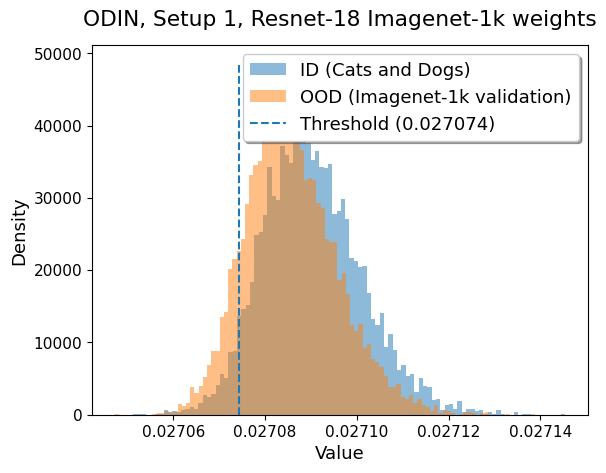

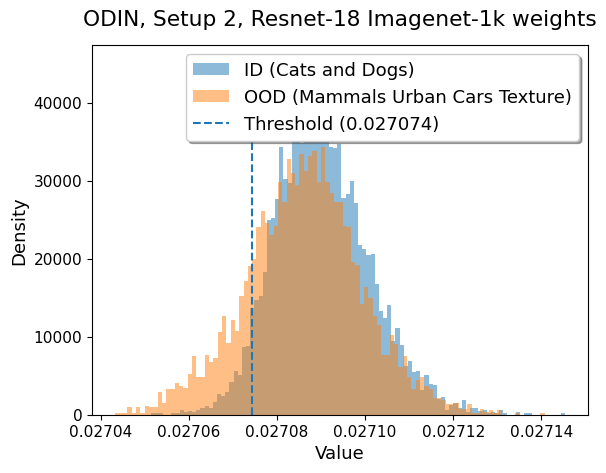

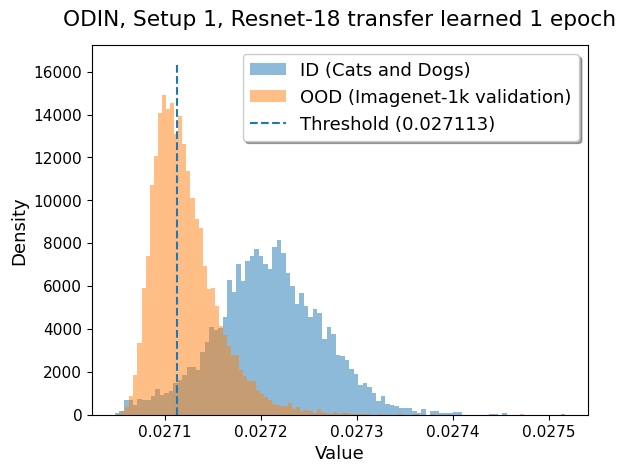

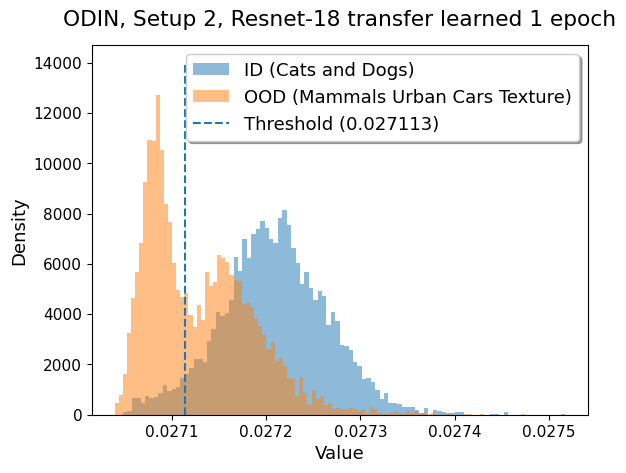

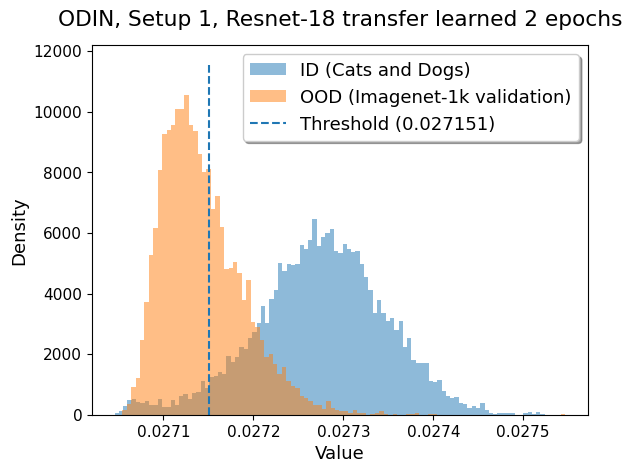

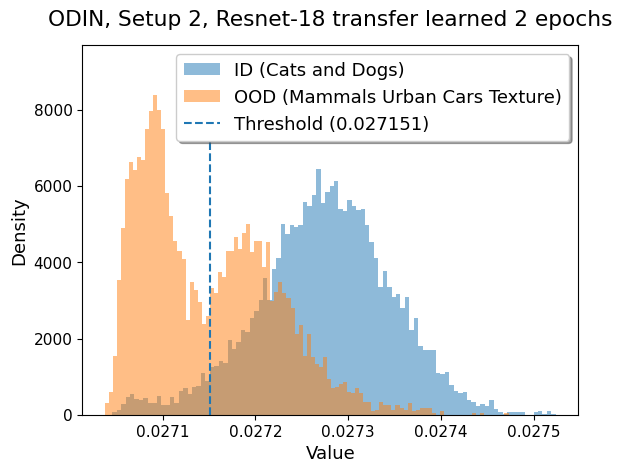

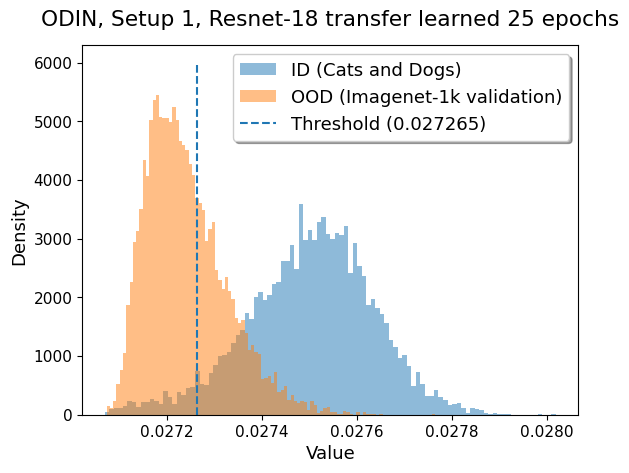

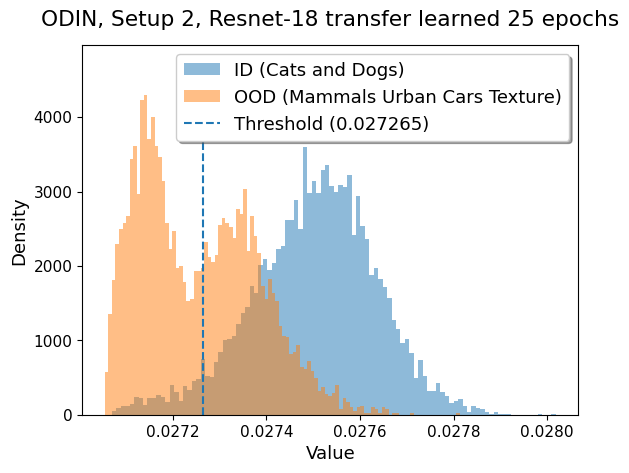

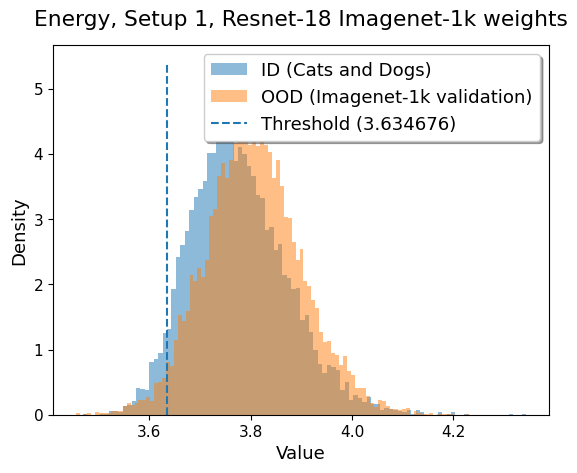

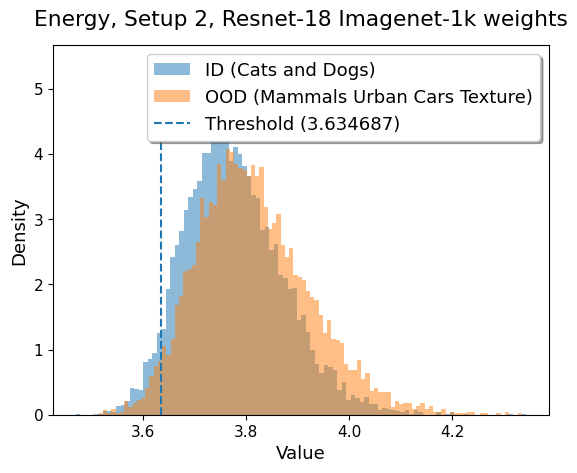

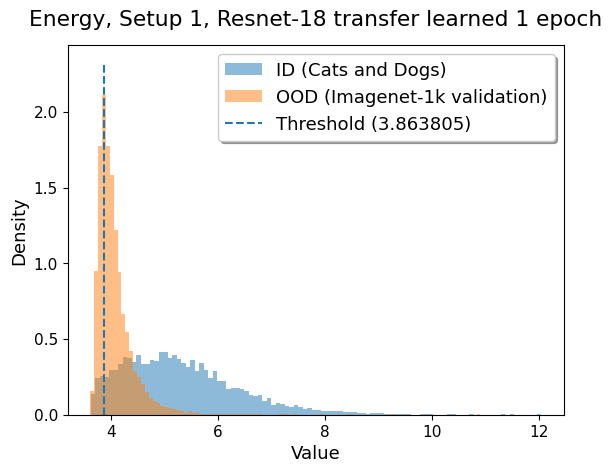

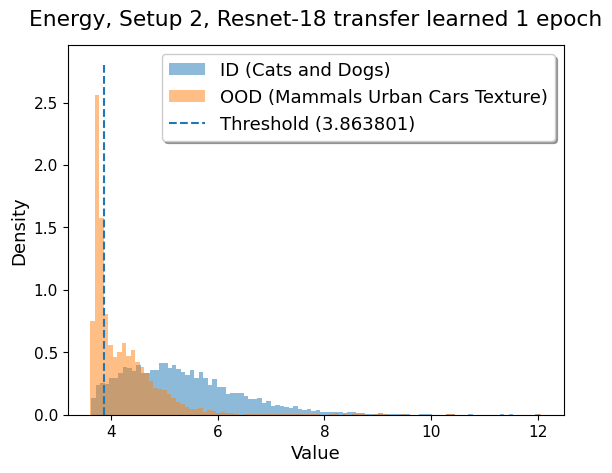

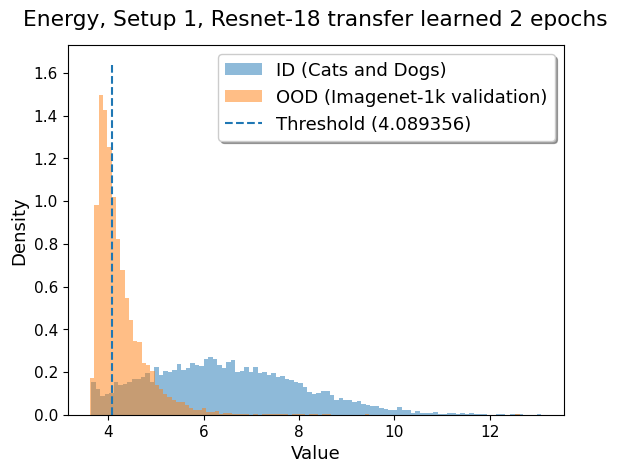

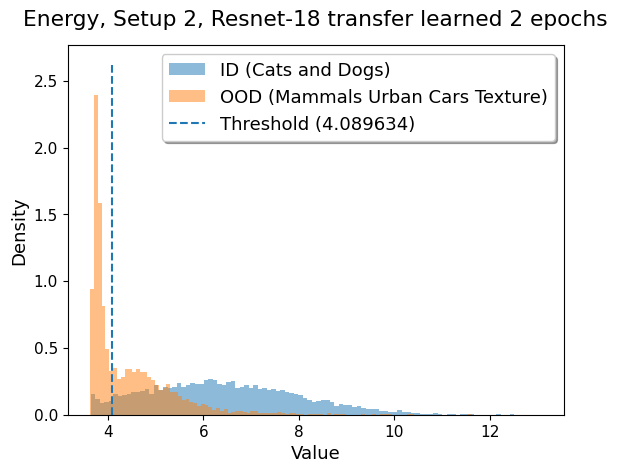

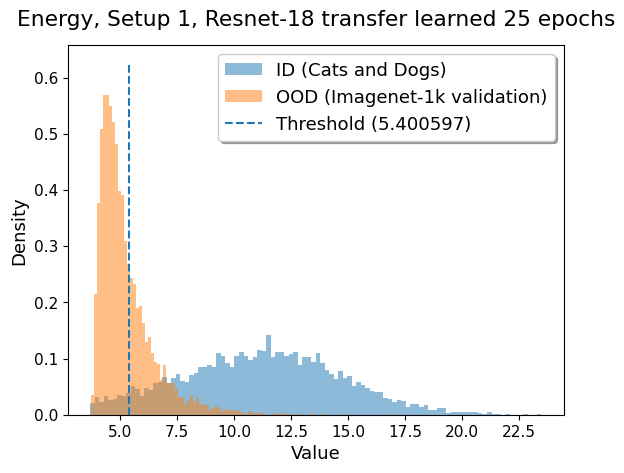

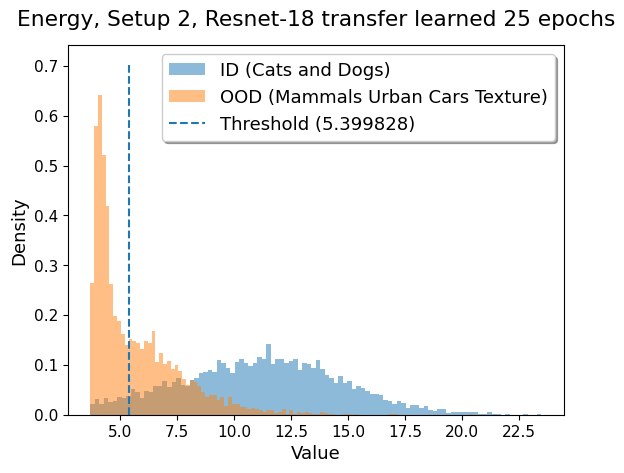

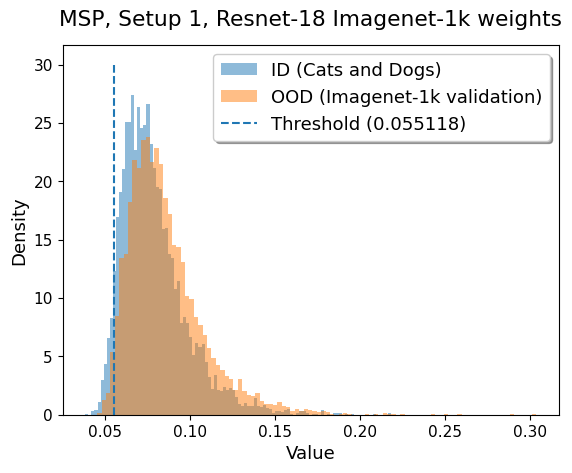

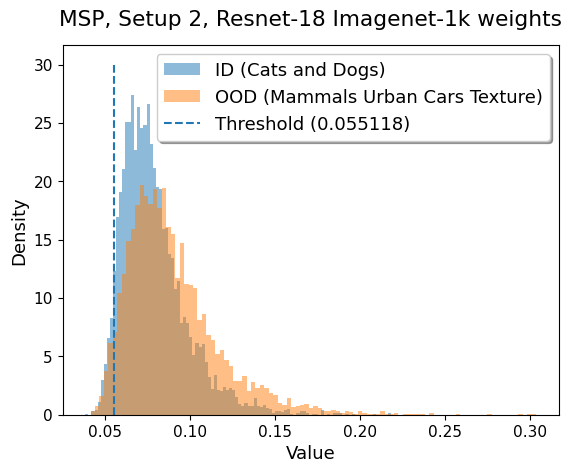

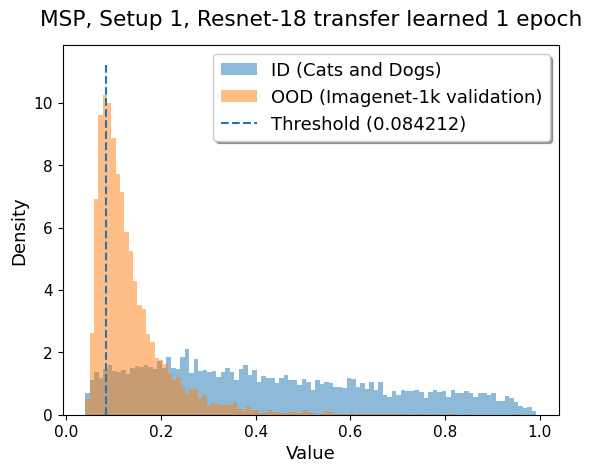

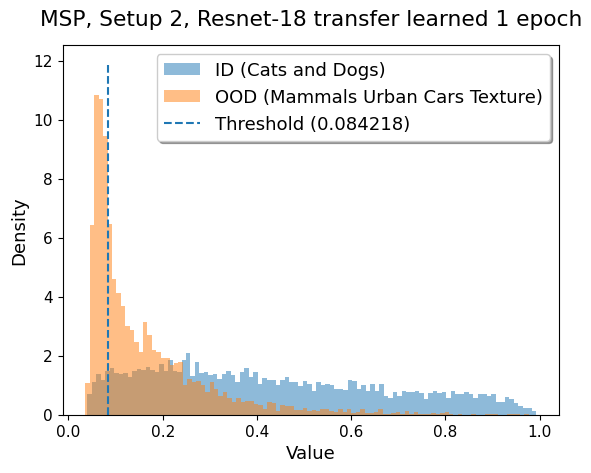

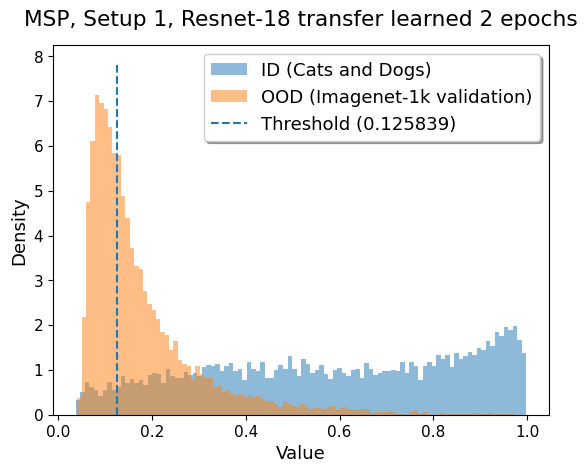

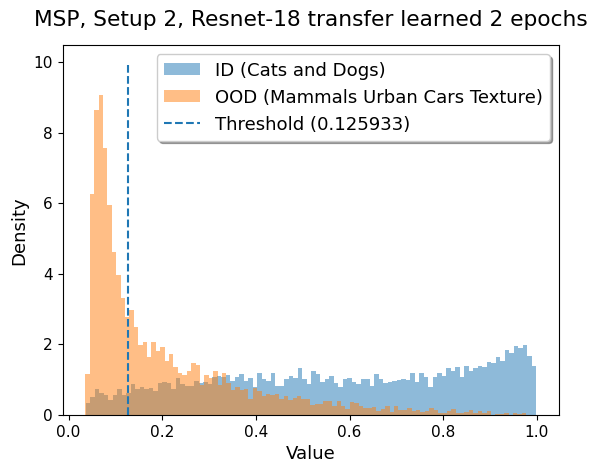

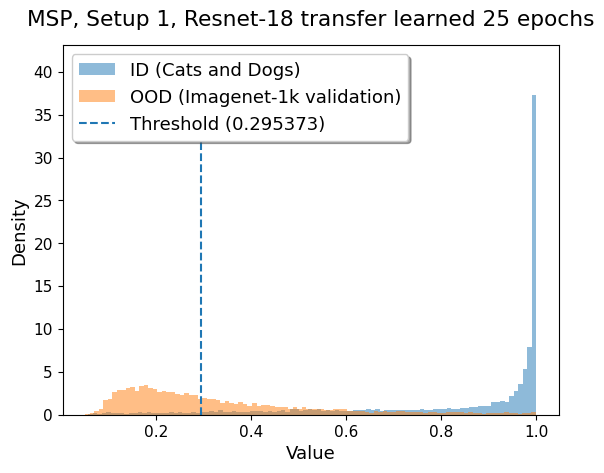

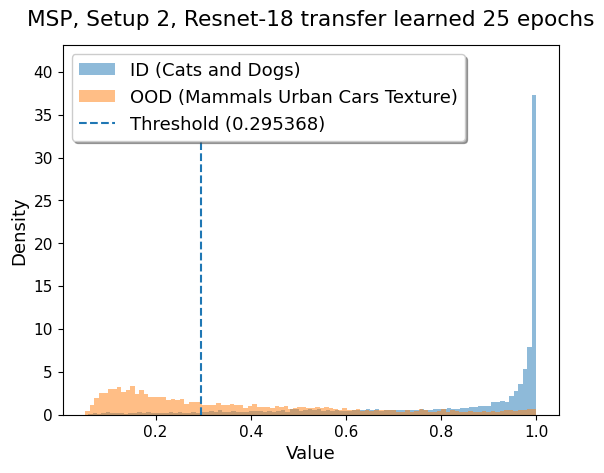

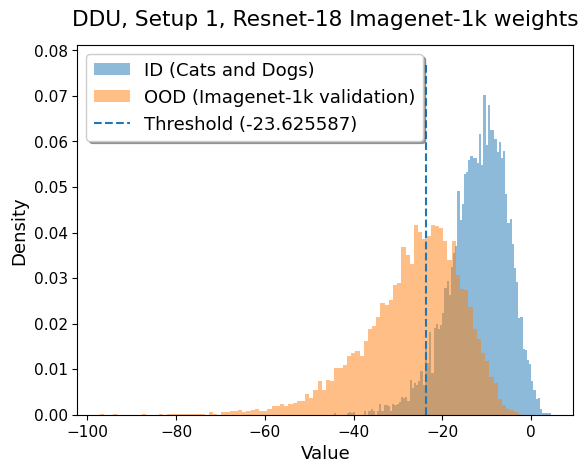

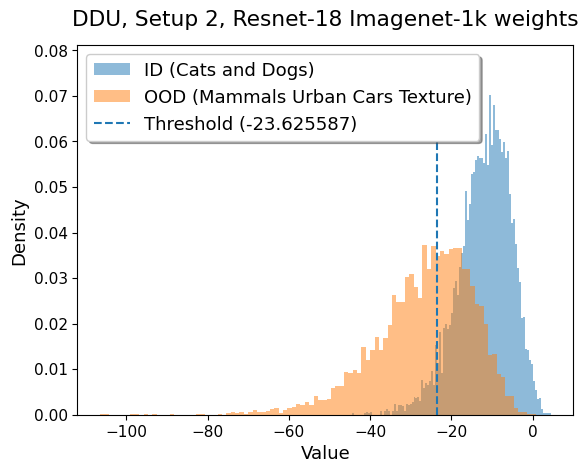

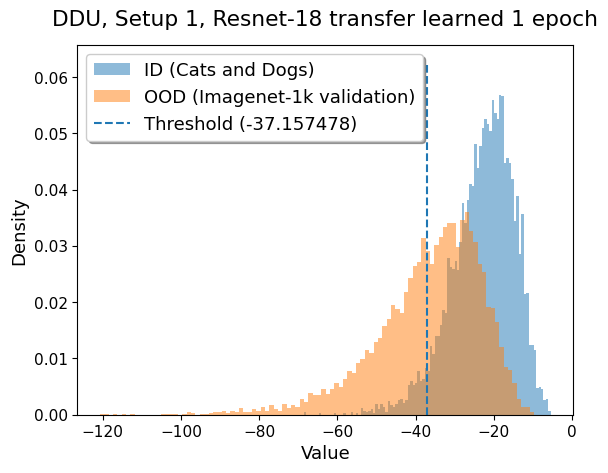

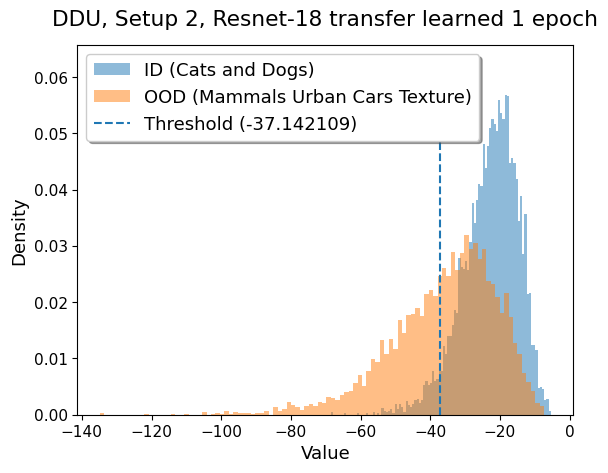

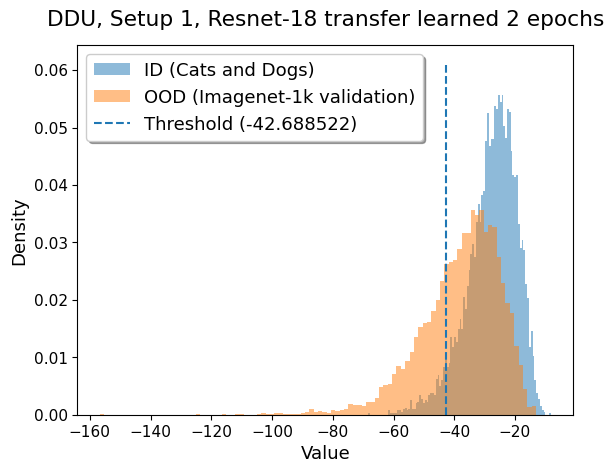

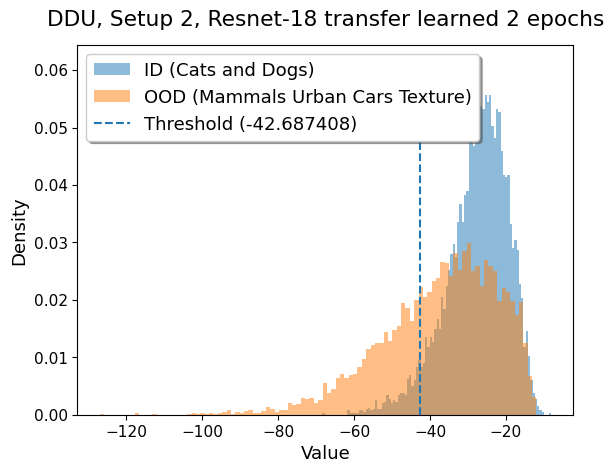

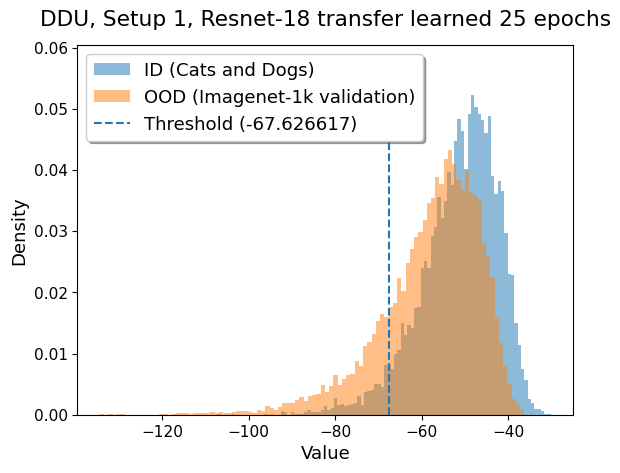

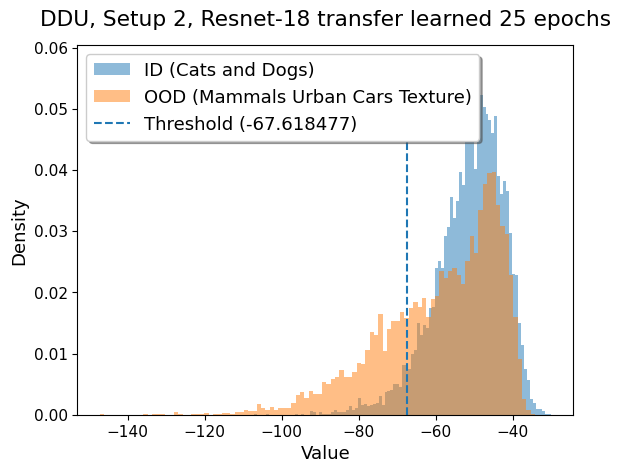

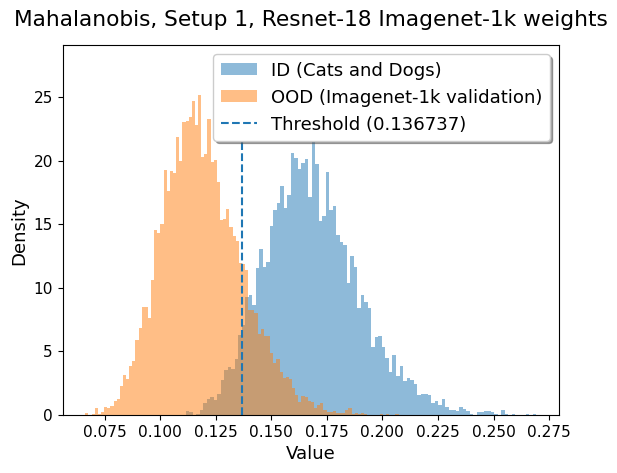

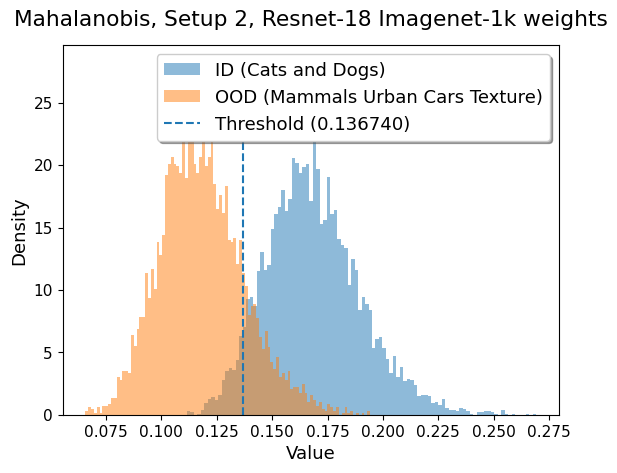

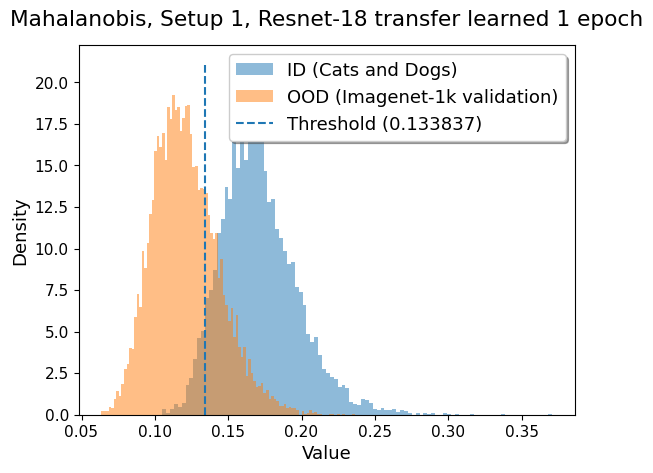

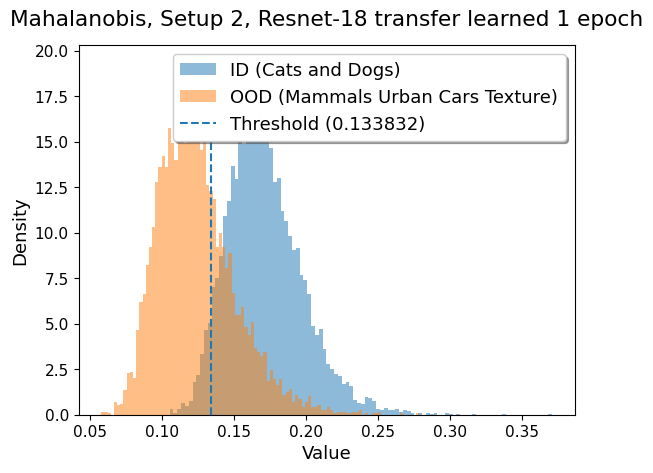

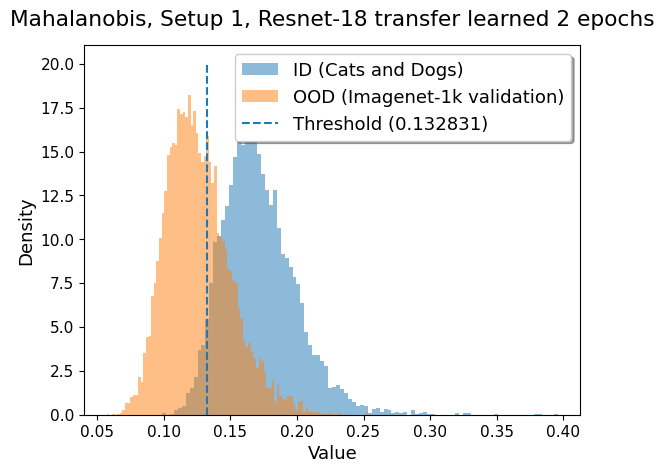

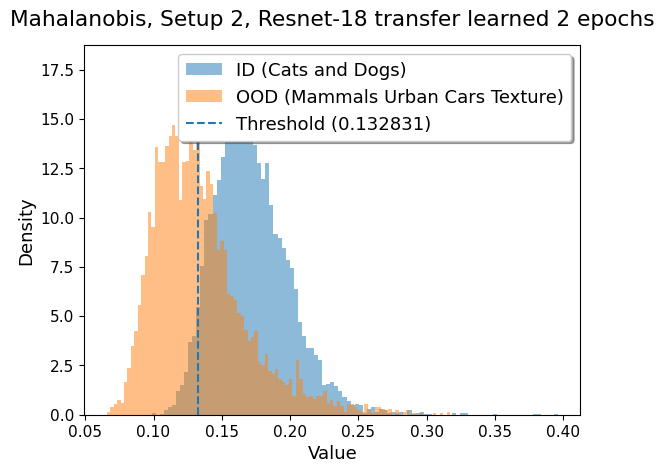

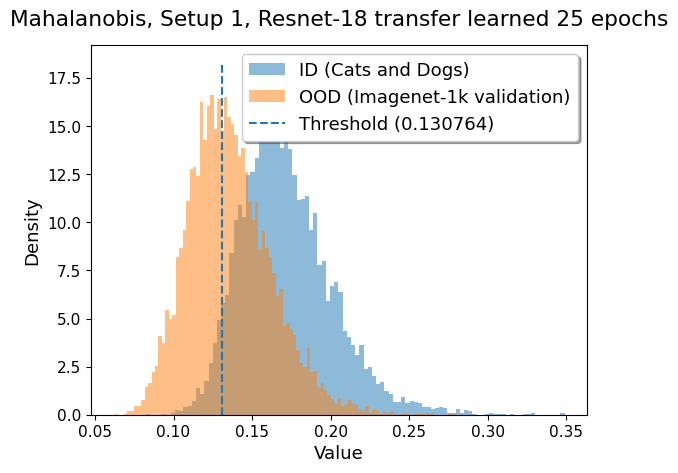

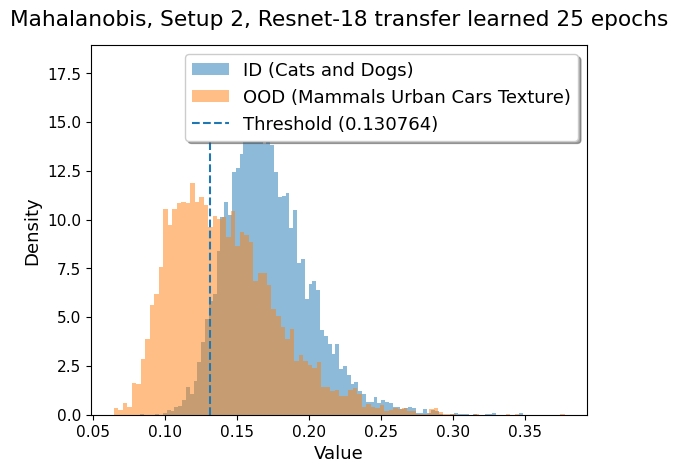

In [30]:
from helpers import thresholdize, thresholdize_freq, get_measures
import matplotlib

# ODIN
visualizeThreshold(turmoil(s12_pt_odin_in_examples), turmoil(s1_pt_odin_out_examples), s1_pt_odin_threshold, "ODIN, Setup 1, Resnet-18 Imagenet-1k weights", extra_plot=False)
visualizeThreshold(turmoil(s12_pt_odin_in_examples), turmoil(s2_pt_odin_out_examples), s2_pt_odin_threshold, "ODIN, Setup 2, Resnet-18 Imagenet-1k weights", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res1_odin_in_examples), turmoil(s1_res1_odin_out_examples), s1_res1_odin_threshold, "ODIN, Setup 1, Resnet-18 transfer learned 1 epoch", extra_plot=False)
visualizeThreshold(turmoil(s12_res1_odin_in_examples), turmoil(s2_res1_odin_out_examples), s2_res1_odin_threshold, "ODIN, Setup 2, Resnet-18 transfer learned 1 epoch", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res2_odin_in_examples), turmoil(s1_res2_odin_out_examples), s1_res2_odin_threshold, "ODIN, Setup 1, Resnet-18 transfer learned 2 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res2_odin_in_examples), turmoil(s2_res2_odin_out_examples), s2_res2_odin_threshold, "ODIN, Setup 2, Resnet-18 transfer learned 2 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res25_odin_in_examples), turmoil(s1_res25_odin_out_examples), s1_res25_odin_threshold, "ODIN, Setup 1, Resnet-18 transfer learned 25 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res25_odin_in_examples), turmoil(s2_res25_odin_out_examples), s2_res25_odin_threshold, "ODIN, Setup 2, Resnet-18 transfer learned 25 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# Energy
visualizeThreshold(turmoil(s12_pt_energy_in_examples), turmoil(s1_pt_energy_out_examples), s1_pt_energy_threshold, "Energy, Setup 1, Resnet-18 Imagenet-1k weights", extra_plot=False)
visualizeThreshold(turmoil(s12_pt_energy_in_examples), turmoil(s2_pt_energy_out_examples), s2_pt_energy_threshold, "Energy, Setup 2, Resnet-18 Imagenet-1k weights", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res1_energy_in_examples), turmoil(s1_res1_energy_out_examples), s1_res1_energy_threshold, "Energy, Setup 1, Resnet-18 transfer learned 1 epoch", extra_plot=False)
visualizeThreshold(turmoil(s12_res1_energy_in_examples), turmoil(s2_res1_energy_out_examples), s2_res1_energy_threshold, "Energy, Setup 2, Resnet-18 transfer learned 1 epoch", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res2_energy_in_examples), turmoil(s1_res2_energy_out_examples), s1_res2_energy_threshold, "Energy, Setup 1, Resnet-18 transfer learned 2 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res2_energy_in_examples), turmoil(s2_res2_energy_out_examples), s2_res2_energy_threshold, "Energy, Setup 2, Resnet-18 transfer learned 2 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res25_energy_in_examples), turmoil(s1_res25_energy_out_examples), s1_res25_energy_threshold, "Energy, Setup 1, Resnet-18 transfer learned 25 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res25_energy_in_examples), turmoil(s2_res25_energy_out_examples), s2_res25_energy_threshold, "Energy, Setup 2, Resnet-18 transfer learned 25 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# MSP
visualizeThreshold(turmoil(s12_pt_msp_in_examples), turmoil(s1_pt_msp_out_examples), s1_pt_msp_threshold, "MSP, Setup 1, Resnet-18 Imagenet-1k weights", extra_plot=False)
visualizeThreshold(turmoil(s12_pt_msp_in_examples), turmoil(s2_pt_msp_out_examples), s2_pt_msp_threshold, "MSP, Setup 2, Resnet-18 Imagenet-1k weights", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res1_msp_in_examples), turmoil(s1_res1_msp_out_examples), s1_res1_msp_threshold, "MSP, Setup 1, Resnet-18 transfer learned 1 epoch", extra_plot=False)
visualizeThreshold(turmoil(s12_res1_msp_in_examples), turmoil(s2_res1_msp_out_examples), s2_res1_msp_threshold, "MSP, Setup 2, Resnet-18 transfer learned 1 epoch", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res2_msp_in_examples), turmoil(s1_res2_msp_out_examples), s1_res2_msp_threshold, "MSP, Setup 1, Resnet-18 transfer learned 2 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res2_msp_in_examples), turmoil(s2_res2_msp_out_examples), s2_res2_msp_threshold, "MSP, Setup 2, Resnet-18 transfer learned 2 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res25_msp_in_examples), turmoil(s1_res25_msp_out_examples), s1_res25_msp_threshold, "MSP, Setup 1, Resnet-18 transfer learned 25 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res25_msp_in_examples), turmoil(s2_res25_msp_out_examples), s2_res25_msp_threshold, "MSP, Setup 2, Resnet-18 transfer learned 25 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# DDU
visualizeThreshold(turmoil(s12_pt_ddu_in_scores), turmoil(s1_pt_ddu_out_scores), s1_pt_ddu_threshold, "DDU, Setup 1, Resnet-18 Imagenet-1k weights", extra_plot=False)
visualizeThreshold(turmoil(s12_pt_ddu_in_scores), turmoil(s2_pt_ddu_out_scores), s2_pt_ddu_threshold, "DDU, Setup 2, Resnet-18 Imagenet-1k weights", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res1_ddu_in_scores), turmoil(s1_res1_ddu_out_scores), s1_res1_ddu_threshold, "DDU, Setup 1, Resnet-18 transfer learned 1 epoch", extra_plot=False)
visualizeThreshold(turmoil(s12_res1_ddu_in_scores), turmoil(s2_res1_ddu_out_scores), s2_res1_ddu_threshold, "DDU, Setup 2, Resnet-18 transfer learned 1 epoch", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res2_ddu_in_scores), turmoil(s1_res2_ddu_out_scores), s1_res2_ddu_threshold, "DDU, Setup 1, Resnet-18 transfer learned 2 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res2_ddu_in_scores), turmoil(s2_res2_ddu_out_scores), s2_res2_ddu_threshold, "DDU, Setup 2, Resnet-18 transfer learned 2 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_res25_ddu_in_scores), turmoil(s1_res25_ddu_out_scores), s1_res25_ddu_threshold, "DDU, Setup 1, Resnet-18 transfer learned 25 epochs", extra_plot=False)
visualizeThreshold(turmoil(s12_res25_ddu_in_scores), turmoil(s2_res25_ddu_out_scores), s2_res25_ddu_threshold, "DDU, Setup 2, Resnet-18 transfer learned 25 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# Mahalanobis
visualizeThreshold(turmoil_switch(pt_in_mahalanobis_distances), turmoil_switch(pt_s1ood_mahalanobis_distances), s1_pt_maha_threshold, "Mahalanobis, Setup 1, Resnet-18 Imagenet-1k weights", extra_plot=False)
visualizeThreshold(turmoil_switch(pt_in_mahalanobis_distances), turmoil_switch(pt_s2ood_mahalanobis_distances), s2_pt_maha_threshold, "Mahalanobis, Setup 2, Resnet-18 Imagenet-1k weights", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(res1_in_mahalanobis_distances), turmoil_switch(res1_s1ood_mahalanobis_distances), s1_res1_maha_threshold, "Mahalanobis, Setup 1, Resnet-18 transfer learned 1 epoch", extra_plot=False)
visualizeThreshold(turmoil_switch(res1_in_mahalanobis_distances), turmoil_switch(res1_s2ood_mahalanobis_distances), s2_res1_maha_threshold, "Mahalanobis, Setup 2, Resnet-18 transfer learned 1 epoch", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(res2_in_mahalanobis_distances), turmoil_switch(res2_s1ood_mahalanobis_distances), s1_res2_maha_threshold, "Mahalanobis, Setup 1, Resnet-18 transfer learned 2 epochs", extra_plot=False)
visualizeThreshold(turmoil_switch(res2_in_mahalanobis_distances), turmoil_switch(res2_s2ood_mahalanobis_distances), s2_res2_maha_threshold, "Mahalanobis, Setup 2, Resnet-18 transfer learned 2 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(res25_in_mahalanobis_distances), turmoil_switch(res25_s1ood_mahalanobis_distances), s1_res25_maha_threshold, "Mahalanobis, Setup 1, Resnet-18 transfer learned 25 epochs", extra_plot=False)
visualizeThreshold(turmoil_switch(res25_in_mahalanobis_distances), turmoil_switch(res25_s2ood_mahalanobis_distances), s2_res25_maha_threshold, "Mahalanobis, Setup 2, Resnet-18 transfer learned 25 epochs", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)


In [31]:
print("ODIN")
print(round(s1_pt_odin_auroc, 4), round(s1_pt_odin_aupr_in, 4), round(s1_pt_odin_aupr_out, 4), round(s1_pt_odin_fpr95, 4), round(s1_pt_odin_threshold, 4))
print(round(s2_pt_odin_auroc, 4), round(s2_pt_odin_aupr_in, 4), round(s2_pt_odin_aupr_out, 4), round(s2_pt_odin_fpr95, 4), round(s2_pt_odin_threshold, 4))
print(round(s1_res1_odin_auroc, 4), round(s1_res1_odin_aupr_in, 4), round(s1_res1_odin_aupr_out, 4), round(s1_res1_odin_fpr95, 4), round(s1_res1_odin_threshold, 4))
print(round(s2_res1_odin_auroc, 4), round(s2_res1_odin_aupr_in, 4), round(s2_res1_odin_aupr_out, 4), round(s2_res1_odin_fpr95, 4), round(s2_res1_odin_threshold, 4))
print(round(s1_res2_odin_auroc, 4), round(s1_res2_odin_aupr_in, 4), round(s1_res2_odin_aupr_out, 4), round(s1_res2_odin_fpr95, 4), round(s1_res2_odin_threshold, 4))
print(round(s2_res2_odin_auroc, 4), round(s2_res2_odin_aupr_in, 4), round(s2_res2_odin_aupr_out, 4), round(s2_res2_odin_fpr95, 4), round(s2_res2_odin_threshold, 4))
print(round(s1_res25_odin_auroc, 4), round(s1_res25_odin_aupr_in, 4), round(s1_res25_odin_aupr_out, 4), round(s1_res25_odin_fpr95, 4), round(s1_res25_odin_threshold, 4))
print(round(s2_res25_odin_auroc, 4), round(s2_res25_odin_aupr_in, 4), round(s2_res25_odin_aupr_out, 4), round(s2_res25_odin_fpr95, 4), round(s2_res25_odin_threshold, 4))
print("")
print("Energy")
print(round(s1_pt_energy_auroc, 4), round(s1_pt_energy_aupr_in, 4), round(s1_pt_energy_aupr_out, 4), round(s1_pt_energy_fpr95, 4), round(s1_pt_energy_threshold, 4))
print(round(s2_pt_energy_auroc, 4), round(s2_pt_energy_aupr_in, 4), round(s2_pt_energy_aupr_out, 4), round(s2_pt_energy_fpr95, 4), round(s2_pt_energy_threshold, 4))
print(round(s1_res1_energy_auroc, 4), round(s1_res1_energy_aupr_in, 4), round(s1_res1_energy_aupr_out, 4), round(s1_res1_energy_fpr95, 4), round(s1_res1_energy_threshold, 4))
print(round(s2_res1_energy_auroc, 4), round(s2_res1_energy_aupr_in, 4), round(s2_res1_energy_aupr_out, 4), round(s2_res1_energy_fpr95, 4), round(s2_res1_energy_threshold, 4))
print(round(s1_res2_energy_auroc, 4), round(s1_res2_energy_aupr_in, 4), round(s1_res2_energy_aupr_out, 4), round(s1_res2_energy_fpr95, 4), round(s1_res2_energy_threshold, 4))
print(round(s2_res2_energy_auroc, 4), round(s2_res2_energy_aupr_in, 4), round(s2_res2_energy_aupr_out, 4), round(s2_res2_energy_fpr95, 4), round(s2_res2_energy_threshold, 4))
print(round(s1_res25_energy_auroc, 4), round(s1_res25_energy_aupr_in, 4), round(s1_res25_energy_aupr_out, 4), round(s1_res25_energy_fpr95, 4), round(s1_res25_energy_threshold, 4))
print(round(s2_res25_energy_auroc, 4), round(s2_res25_energy_aupr_in, 4), round(s2_res25_energy_aupr_out, 4), round(s2_res25_energy_fpr95, 4), round(s2_res25_energy_threshold, 4))
print("")
print("MSP")
print(round(s1_pt_msp_auroc, 4), round(s1_pt_msp_aupr_in, 4), round(s1_pt_msp_aupr_out, 4), round(s1_pt_msp_fpr95, 4), round(s1_pt_msp_threshold, 4))
print(round(s2_pt_msp_auroc, 4), round(s2_pt_msp_aupr_in, 4), round(s2_pt_msp_aupr_out, 4), round(s2_pt_msp_fpr95, 4), round(s2_pt_msp_threshold, 4))
print(round(s1_res1_msp_auroc, 4), round(s1_res1_msp_aupr_in, 4), round(s1_res1_msp_aupr_out, 4), round(s1_res1_msp_fpr95, 4), round(s1_res1_msp_threshold, 4))
print(round(s2_res1_msp_auroc, 4), round(s2_res1_msp_aupr_in, 4), round(s2_res1_msp_aupr_out, 4), round(s2_res1_msp_fpr95, 4), round(s2_res1_msp_threshold, 4))
print(round(s1_res2_msp_auroc, 4), round(s1_res2_msp_aupr_in, 4), round(s1_res2_msp_aupr_out, 4), round(s1_res2_msp_fpr95, 4), round(s1_res2_msp_threshold, 4))
print(round(s2_res2_msp_auroc, 4), round(s2_res2_msp_aupr_in, 4), round(s2_res2_msp_aupr_out, 4), round(s2_res2_msp_fpr95, 4), round(s2_res2_msp_threshold, 4))
print(round(s1_res25_msp_auroc, 4), round(s1_res25_msp_aupr_in, 4), round(s1_res25_msp_aupr_out, 4), round(s1_res25_msp_fpr95, 4), round(s1_res25_msp_threshold, 4))
print(round(s2_res25_msp_auroc, 4), round(s2_res25_msp_aupr_in, 4), round(s2_res25_msp_aupr_out, 4), round(s2_res25_msp_fpr95, 4), round(s2_res25_msp_threshold, 4))
print("")
print("DDU")
print(round(s1_pt_ddu_auroc, 4), round(s1_pt_ddu_aupr_in, 4), round(s1_pt_ddu_aupr_out, 4), round(s1_pt_ddu_fpr95, 4), round(s1_pt_ddu_threshold, 4))
print(round(s2_pt_ddu_auroc, 4), round(s2_pt_ddu_aupr_in, 4), round(s2_pt_ddu_aupr_out, 4), round(s2_pt_ddu_fpr95, 4), round(s2_pt_ddu_threshold, 4))
print(round(s1_res1_ddu_auroc, 4), round(s1_res1_ddu_aupr_in, 4), round(s1_res1_ddu_aupr_out, 4), round(s1_res1_ddu_fpr95, 4), round(s1_res1_ddu_threshold, 4))
print(round(s2_res1_ddu_auroc, 4), round(s2_res1_ddu_aupr_in, 4), round(s2_res1_ddu_aupr_out, 4), round(s2_res1_ddu_fpr95, 4), round(s2_res1_ddu_threshold, 4))
print(round(s1_res2_ddu_auroc, 4), round(s1_res2_ddu_aupr_in, 4), round(s1_res2_ddu_aupr_out, 4), round(s1_res2_ddu_fpr95, 4), round(s1_res2_ddu_threshold, 4))
print(round(s2_res2_ddu_auroc, 4), round(s2_res2_ddu_aupr_in, 4), round(s2_res2_ddu_aupr_out, 4), round(s2_res2_ddu_fpr95, 4), round(s2_res2_ddu_threshold, 4))
print(round(s1_res25_ddu_auroc, 4), round(s1_res25_ddu_aupr_in, 4), round(s1_res25_ddu_aupr_out, 4), round(s1_res25_ddu_fpr95, 4), round(s1_res25_ddu_threshold, 4))
print(round(s2_res25_ddu_auroc, 4), round(s2_res25_ddu_aupr_in, 4), round(s2_res25_ddu_aupr_out, 4), round(s2_res25_ddu_fpr95, 4), round(s2_res25_ddu_threshold, 4))
print("")
print("Mahalanobis")
print(round(s1_pt_maha_auroc, 4), round(s1_pt_maha_aupr_in, 4), round(s1_pt_maha_aupr_out, 4), round(s1_pt_maha_fpr95, 4), round(s1_pt_maha_threshold, 4))
print(round(s2_pt_maha_auroc, 4), round(s2_pt_maha_aupr_in, 4), round(s2_pt_maha_aupr_out, 4), round(s2_pt_maha_fpr95, 4), round(s2_pt_maha_threshold, 4))
print(round(s1_res1_maha_auroc, 4), round(s1_res1_maha_aupr_in, 4), round(s1_res1_maha_aupr_out, 4), round(s1_res1_maha_fpr95, 4), round(s1_res1_maha_threshold, 4))
print(round(s2_res1_maha_auroc, 4), round(s2_res1_maha_aupr_in, 4), round(s2_res1_maha_aupr_out, 4), round(s2_res1_maha_fpr95, 4), round(s2_res1_maha_threshold, 4))
print(round(s1_res2_maha_auroc, 4), round(s1_res2_maha_aupr_in, 4), round(s1_res2_maha_aupr_out, 4), round(s1_res2_maha_fpr95, 4), round(s1_res2_maha_threshold, 4))
print(round(s2_res2_maha_auroc, 4), round(s2_res2_maha_aupr_in, 4), round(s2_res2_maha_aupr_out, 4), round(s2_res2_maha_fpr95, 4), round(s2_res2_maha_threshold, 4))
print(round(s1_res25_maha_auroc, 4), round(s1_res25_maha_aupr_in, 4), round(s1_res25_maha_aupr_out, 4), round(s1_res25_maha_fpr95, 4), round(s1_res25_maha_threshold, 4))
print(round(s2_res25_maha_auroc, 4), round(s2_res25_maha_aupr_in, 4), round(s2_res25_maha_aupr_out, 4), round(s2_res25_maha_fpr95, 4), round(s2_res25_maha_threshold, 4))


ODIN
0.6251 0.5492 0.6681 0.881 0.0271
0.5917 0.6079 0.581 0.8267 0.0271
0.9041 0.89 0.8789 0.5294 0.0271
0.8412 0.8414 0.8111 0.5233 0.0271
0.9318 0.9278 0.9069 0.3705 0.0272
0.8871 0.8987 0.8565 0.4598 0.0272
0.9405 0.9389 0.9256 0.338 0.0273
0.9057 0.9239 0.8773 0.4566 0.0273

Energy
0.4017 0.3767 0.4999 0.9708 3.6347
0.3978 0.477 0.3817 0.9702 3.6347
0.8865 0.8858 0.8569 0.7116 3.8638
0.8373 0.8515 0.7898 0.5812 3.8638
0.9178 0.9202 0.8853 0.5018 4.0894
0.8823 0.9023 0.834 0.4825 4.0896
0.9459 0.9488 0.9261 0.3216 5.4006
0.9174 0.9362 0.8793 0.4274 5.3998

MSP
0.3993 0.3695 0.4904 0.9815 0.0551
0.3718 0.4606 0.3746 0.9627 0.0551
0.8724 0.8741 0.837 0.7428 0.0842
0.8382 0.8668 0.7721 0.6303 0.0842
0.9008 0.8975 0.876 0.5587 0.1258
0.8757 0.9001 0.8262 0.5096 0.1259
0.9192 0.9189 0.9043 0.4392 0.2954
0.8964 0.9222 0.8499 0.4791 0.2954

DDU
0.8908 0.8646 0.9144 0.4444 -23.6256
0.8753 0.8871 0.8648 0.4529 -23.6256
0.8231 0.7753 0.8618 0.5813 -37.1575
0.7831 0.7756 0.782 0.5893 -37.1421

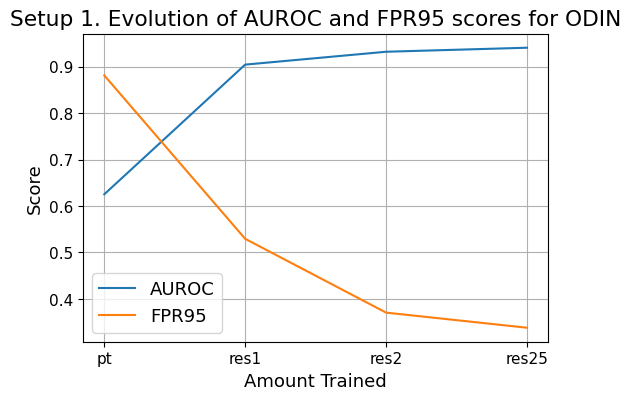

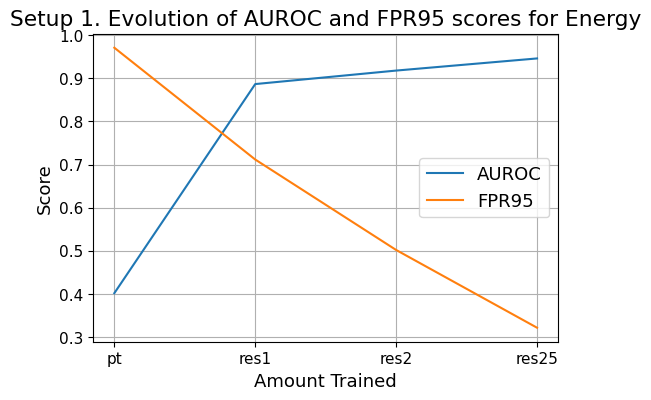

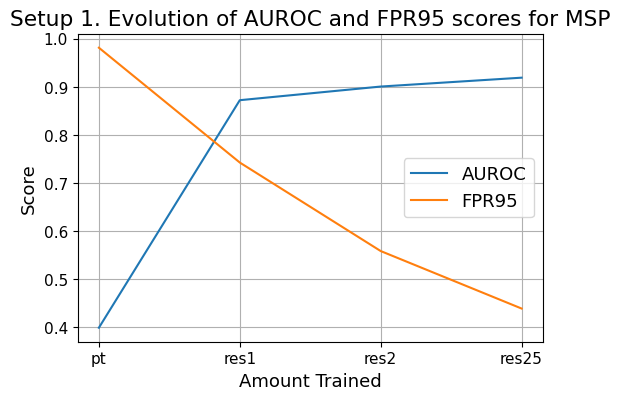

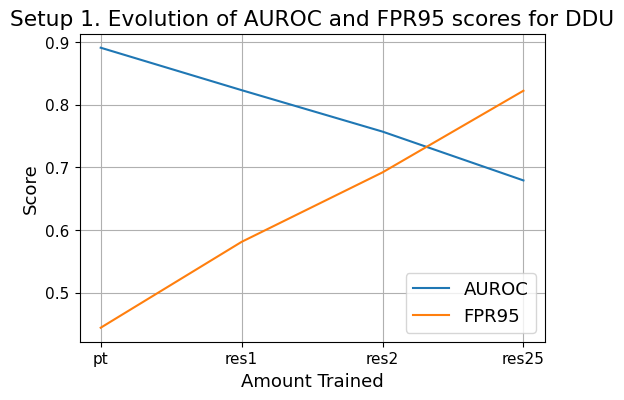

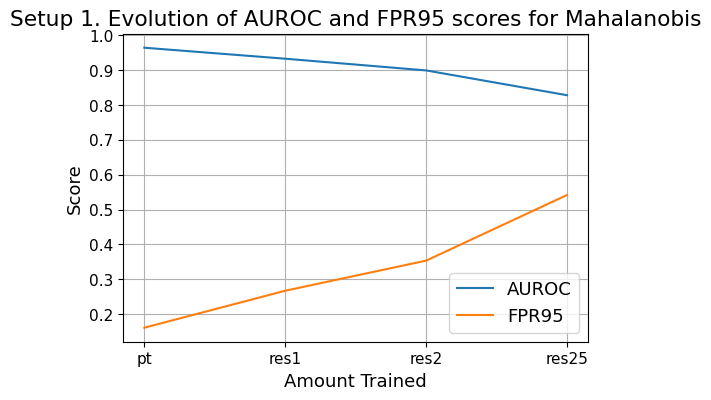

In [36]:
ood_methods = ['ODIN', 'Energy', 'MSP', 'DDU', 'Mahalanobis']
amounts_trained = ['pt', 'res1', 'res2', 'res25']

# Multiline plots for setup 1
auroc_data = {
    'ODIN': [s1_pt_odin_auroc, s1_res1_odin_auroc, s1_res2_odin_auroc, s1_res25_odin_auroc],
    'Energy': [s1_pt_energy_auroc, s1_res1_energy_auroc, s1_res2_energy_auroc, s1_res25_energy_auroc],
    'MSP': [s1_pt_msp_auroc, s1_res1_msp_auroc, s1_res2_msp_auroc, s1_res25_msp_auroc],
    'DDU': [s1_pt_ddu_auroc, s1_res1_ddu_auroc, s1_res2_ddu_auroc, s1_res25_ddu_auroc],
    'Mahalanobis': [s1_pt_maha_auroc, s1_res1_maha_auroc, s1_res2_maha_auroc, s1_res25_maha_auroc]
}

fpr95_data = {
    'ODIN': [s1_pt_odin_fpr95, s1_res1_odin_fpr95, s1_res2_odin_fpr95, s1_res25_odin_fpr95],
    'Energy': [s1_pt_energy_fpr95, s1_res1_energy_fpr95, s1_res2_energy_fpr95, s1_res25_energy_fpr95],
    'MSP': [s1_pt_msp_fpr95, s1_res1_msp_fpr95, s1_res2_msp_fpr95, s1_res25_msp_fpr95],
    'DDU': [s1_pt_ddu_fpr95, s1_res1_ddu_fpr95, s1_res2_ddu_fpr95, s1_res25_ddu_fpr95],
    'Mahalanobis': [s1_pt_maha_fpr95, s1_res1_maha_fpr95, s1_res2_maha_fpr95, s1_res25_maha_fpr95]
}

for ood_method in ood_methods:
    plt.figure(figsize=(6, 4))
    plt.plot(amounts_trained, auroc_data[ood_method], label='AUROC')
    plt.plot(amounts_trained, fpr95_data[ood_method], label='FPR95')
    plt.title(f'Setup 1. Evolution of AUROC and FPR95 scores for {ood_method}')
    plt.xlabel('Amount Trained')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

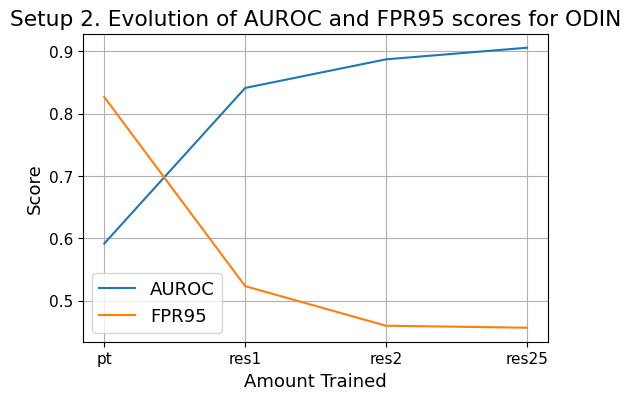

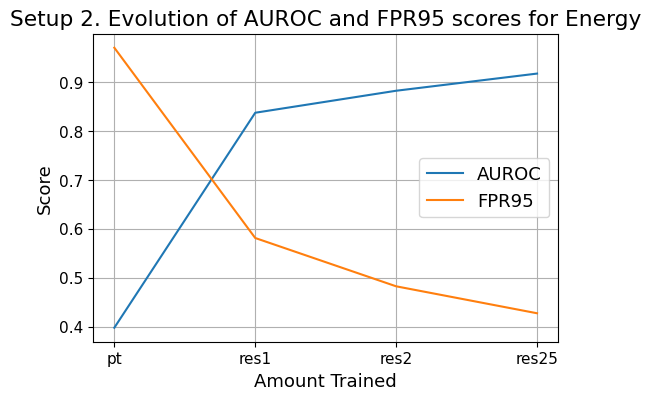

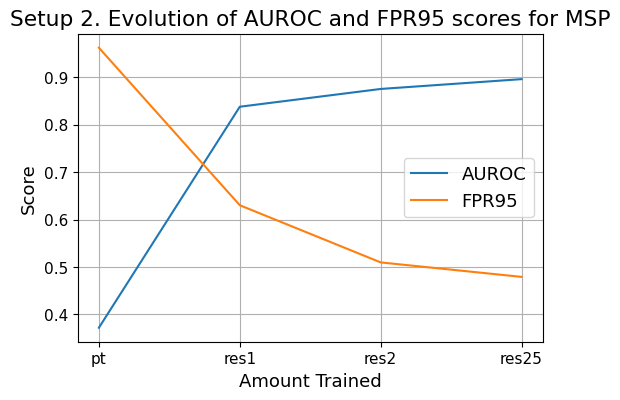

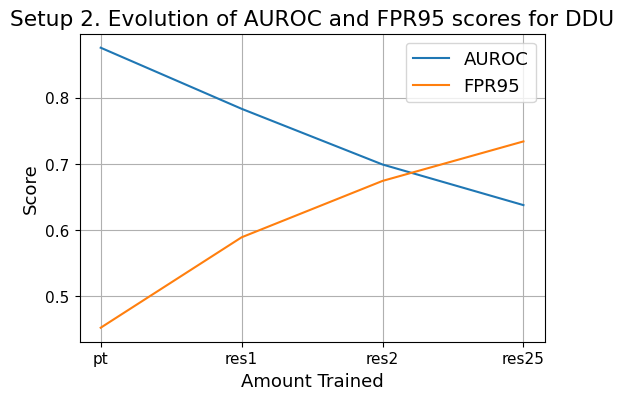

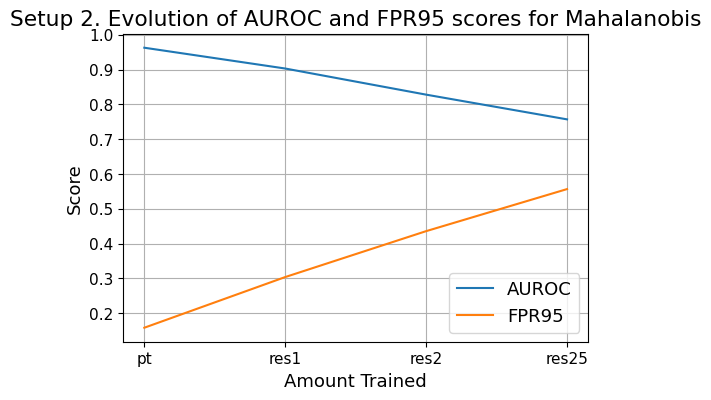

In [37]:
ood_methods = ['ODIN', 'Energy', 'MSP', 'DDU', 'Mahalanobis']
amounts_trained = ['pt', 'res1', 'res2', 'res25']

# Multiline plots for setup 2
auroc_data = {
    'ODIN': [s2_pt_odin_auroc, s2_res1_odin_auroc, s2_res2_odin_auroc, s2_res25_odin_auroc],
    'Energy': [s2_pt_energy_auroc, s2_res1_energy_auroc, s2_res2_energy_auroc, s2_res25_energy_auroc],
    'MSP': [s2_pt_msp_auroc, s2_res1_msp_auroc, s2_res2_msp_auroc, s2_res25_msp_auroc],
    'DDU': [s2_pt_ddu_auroc, s2_res1_ddu_auroc, s2_res2_ddu_auroc, s2_res25_ddu_auroc],
    'Mahalanobis': [s2_pt_maha_auroc, s2_res1_maha_auroc, s2_res2_maha_auroc, s2_res25_maha_auroc]
}

fpr95_data = {
    'ODIN': [s2_pt_odin_fpr95, s2_res1_odin_fpr95, s2_res2_odin_fpr95, s2_res25_odin_fpr95],
    'Energy': [s2_pt_energy_fpr95, s2_res1_energy_fpr95, s2_res2_energy_fpr95, s2_res25_energy_fpr95],
    'MSP': [s2_pt_msp_fpr95, s2_res1_msp_fpr95, s2_res2_msp_fpr95, s2_res25_msp_fpr95],
    'DDU': [s2_pt_ddu_fpr95, s2_res1_ddu_fpr95, s2_res2_ddu_fpr95, s2_res25_ddu_fpr95],
    'Mahalanobis': [s2_pt_maha_fpr95, s2_res1_maha_fpr95, s2_res2_maha_fpr95, s2_res25_maha_fpr95]
}

for ood_method in ood_methods:
    plt.figure(figsize=(6, 4))
    plt.plot(amounts_trained, auroc_data[ood_method], label='AUROC')
    plt.plot(amounts_trained, fpr95_data[ood_method], label='FPR95')
    plt.title(f'Setup 2. Evolution of AUROC and FPR95 scores for {ood_method}')
    plt.xlabel('Amount Trained')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [102]:
import torch

# Get exact accuracy for a model
def calculate_accuracy(model, dataloader, num_classes):
    correct = 0
    total = 0

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = correct / total

    return 100 * train_accuracy

pt_train_accuracy = calculate_accuracy(pretrained_resnet, train_loader, 37)
res1_train_accuracy = calculate_accuracy(exp3_res1, train_loader, 37)
res2_train_accuracy = calculate_accuracy(exp3_res2, train_loader, 37)
res25_train_accuracy = calculate_accuracy(exp3_res25, train_loader, 37)

pt_val_accuracy = calculate_accuracy(pretrained_resnet, val_loader, 37)
res1_val_accuracy = calculate_accuracy(exp3_res1, val_loader, 37)
res2_val_accuracy = calculate_accuracy(exp3_res2, val_loader, 37)
res25_val_accuracy = calculate_accuracy(exp3_res25, val_loader, 37)


In [104]:
print(round(pt_train_accuracy, 4), round(res1_train_accuracy, 4), round(res2_train_accuracy, 4), round(res25_train_accuracy, 4))
print(round(pt_val_accuracy, 4), round(res1_val_accuracy, 4), round(res2_val_accuracy, 4), round(res25_val_accuracy, 4))

2.6161 69.3279 73.8536 85.2052
2.8417 67.7943 71.5832 86.3329


In [50]:
import torch

# Get accuracy for each class
def calculate_class_accuracy(model, dataloader, num_classes):
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).squeeze()

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = class_correct / class_total

    return class_accuracy

pt_class_accuracy = calculate_class_accuracy(pretrained_resnet, train_loader, 37)
res1_class_accuracy = calculate_class_accuracy(exp3_res1, train_loader, 37)
res2_class_accuracy = calculate_class_accuracy(exp3_res2, train_loader, 37)
res25_class_accuracy = calculate_class_accuracy(exp3_res25, train_loader, 37)


2.7778378378378377 69.72081081081082 74.5808108108108 85.59054054054053


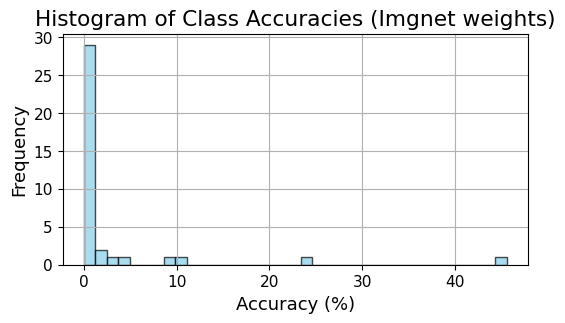

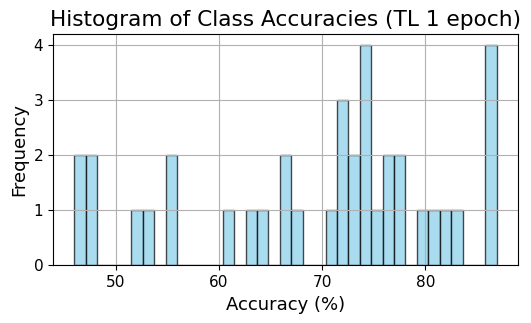

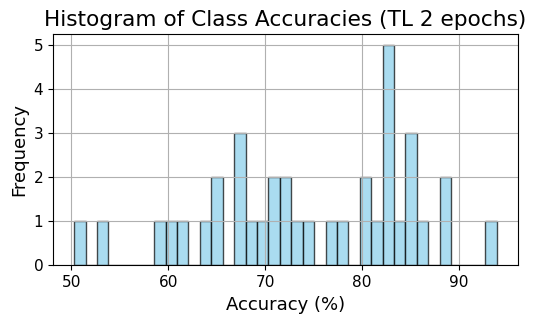

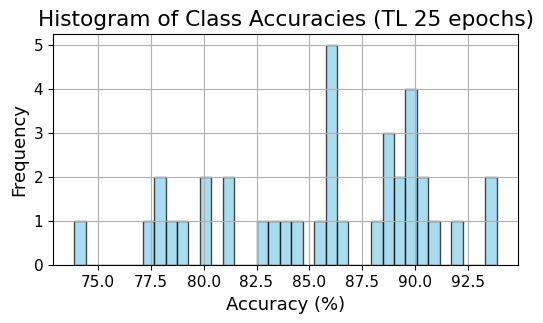

In [51]:
ca_pt = [23.91, 0.00, 0.00, 0.00, 0.00, 2.78, 0.00, 0.00, 9.94, 0.00, 2.25, 0.00, 1.10, 4.14, 0.00, 0.00, 0.00, 0.54, 0.00, 0.56, 0.00, 8.70, 0.00, 45.56, 0.00, 1.08, 0.00, 0.00, 0.00, 0.00, 0.00, 2.22, 0.00, 0.00, 0.00, 0.00, 0.00]
ca_res1 = [64.13, 63.13, 46.89, 73.80, 55.74, 72.22, 55.56, 86.26, 48.07, 51.72, 73.60, 81.56, 60.44, 72.78, 86.81, 77.84, 67.76, 66.49, 86.89, 80.56, 45.99, 72.28, 76.50, 73.89, 83.52, 74.05, 47.40, 72.53, 70.86, 80.00, 74.16, 66.67, 76.47, 74.86, 53.53, 77.78, 86.93]
ca_res2 = [67.39, 65.36, 50.28, 78.61, 76.50, 74.44, 64.44, 93.96, 60.22, 68.97, 53.37, 79.89, 69.78, 71.01, 85.71, 82.70, 72.68, 73.51, 89.07, 82.22, 65.24, 80.43, 88.52, 61.11, 67.05, 84.86, 58.96, 81.32, 71.43, 82.22, 71.91, 85.00, 84.71, 83.80, 67.65, 82.78, 82.39]
ca_res25 = [88.04, 84.36, 81.36, 81.28, 78.14, 86.11, 73.89, 91.76, 86.19, 88.51, 85.39, 93.85, 83.52, 85.80, 90.11, 77.30, 83.61, 90.27, 93.44, 90.00, 79.14, 79.89, 89.62, 78.33, 88.64, 86.49, 78.03, 82.97, 86.29, 88.89, 85.96, 89.44, 89.41, 89.94, 80.00, 91.11, 89.77]

mean_ca_pt = sum(ca_pt)/len(ca_pt)
mean_ca_res1 = sum(ca_res1)/len(ca_res1)
mean_ca_res2 = sum(ca_res2)/len(ca_res2)
mean_ca_res25 = sum(ca_res25)/len(ca_res25)

print(mean_ca_pt, mean_ca_res1, mean_ca_res2, mean_ca_res25)

# Plot histogram to see class accuracy histogram
for ca, ca_name in zip([ca_pt, ca_res1, ca_res2, ca_res25], ["Imgnet weights", "TL 1 epoch", "TL 2 epochs", "TL 25 epochs"]):
    plt.figure(figsize=(6, 3))
    plt.hist(ca, bins=37, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of Class Accuracies ({ca_name})')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [52]:
# Isolate classes that have under 80% accuracy on exp3_res25. MID = 80-90% and High = 90%+
# For all out_examples on all methods and networks, isolate the scores based on the y_pred. Use indexing
# Plot results.
# If this doesn't work, we need to generate a new threshold for each set of classes. 

In [54]:
ca_res25 = [88.04, 84.36, 81.36, 81.28, 78.14, 86.11, 73.89, 91.76, 86.19, 88.51, 85.39, 93.85, 83.52, 85.80, 90.11, 77.30, 83.61, 90.27, 93.44, 90.00, 79.14, 79.89, 89.62, 78.33, 88.64, 86.49, 78.03, 82.97, 86.29, 88.89, 85.96, 89.44, 89.41, 89.94, 80.00, 91.11, 89.77]

low_accs = [inx for inx, i in enumerate(ca_res25) if i <= 80]
med_accs = [inx for inx, i in enumerate(ca_res25) if 80 < i <= 90]
high_accs = [inx for inx, i in enumerate(ca_res25) if i > 90]
print(f"{len(low_accs)} classes with a low accuracy <= 80%")
print(f"{len(med_accs)} classes with a mid accuracy 80% < <= 90%")
print(f"{len(high_accs)} classes with a high accuracy > 90%")

8 classes with a low accuracy <= 80%
23 classes with a mid accuracy 80% < <= 90%
6 classes with a high accuracy > 90%


In [84]:
def ca_split_scores(examples, y_pred, low_ca_list, mid_ca_list, high_ca_list):
    low_ca_scores, mid_ca_scores, high_ca_scores = list(), list(), list()
    
    for score, y in zip(examples, y_pred):
        if y in low_ca_list:
            low_ca_scores.append(score)
        elif y in mid_ca_list:
            mid_ca_scores.append(score)
        elif y in high_ca_list:
            high_ca_scores.append(score)
        else:
            print("ERROR")

    return low_ca_scores, mid_ca_scores, high_ca_scores

low_s12_pt_in_odin, mid_s12_pt_in_odin, high_s12_pt_in_odin = ca_split_scores(s12_pt_odin_in_examples, flat_s12_pt_odin_in_y, low_accs, med_accs, high_accs)
low_s12_res1_in_odin, mid_s12_res1_in_odin, high_s12_res1_in_odin = ca_split_scores(s12_res1_odin_in_examples, flat_s12_res1_odin_in_y, low_accs, med_accs, high_accs)
low_s12_res2_in_odin, mid_s12_res2_in_odin, high_s12_res2_in_odin = ca_split_scores(s12_res2_odin_in_examples, flat_s12_res2_odin_in_y, low_accs, med_accs, high_accs)
low_s12_res25_in_odin, mid_s12_res25_in_odin, high_s12_res25_in_odin = ca_split_scores(s12_res25_odin_in_examples, flat_s12_res25_odin_in_y, low_accs, med_accs, high_accs)
low_s1_pt_odin, mid_s1_pt_odin, high_s1_pt_odin = ca_split_scores(s1_pt_odin_out_examples, flat_s1_pt_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res1_odin, mid_s1_res1_odin, high_s1_res1_odin = ca_split_scores(s1_res1_odin_out_examples, flat_s1_res1_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res2_odin, mid_s1_res2_odin, high_s1_res2_odin = ca_split_scores(s1_res2_odin_out_examples, flat_s1_res2_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res25_odin, mid_s1_res25_odin, high_s1_res25_odin = ca_split_scores(s1_res25_odin_out_examples, flat_s1_res25_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s2_pt_odin, mid_s2_pt_odin, high_s2_pt_odin = ca_split_scores(s2_pt_odin_out_examples, flat_s2_pt_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res1_odin, mid_s2_res1_odin, high_s2_res1_odin = ca_split_scores(s2_res1_odin_out_examples, flat_s2_res1_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res2_odin, mid_s2_res2_odin, high_s2_res2_odin = ca_split_scores(s2_res2_odin_out_examples, flat_s2_res2_odin_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res25_odin, mid_s2_res25_odin, high_s2_res25_odin = ca_split_scores(s2_res25_odin_out_examples, flat_s2_res25_odin_out_y_pred, low_accs, med_accs, high_accs)

low_s12_pt_in_energy, mid_s12_pt_in_energy, high_s12_pt_in_energy = ca_split_scores(s12_pt_energy_in_examples, flat_s12_pt_energy_in_y, low_accs, med_accs, high_accs)
low_s12_res1_in_energy, mid_s12_res1_in_energy, high_s12_res1_in_energy = ca_split_scores(s12_res1_energy_in_examples, flat_s12_res1_energy_in_y, low_accs, med_accs, high_accs)
low_s12_res2_in_energy, mid_s12_res2_in_energy, high_s12_res2_in_energy = ca_split_scores(s12_res2_energy_in_examples, flat_s12_res2_energy_in_y, low_accs, med_accs, high_accs)
low_s12_res25_in_energy, mid_s12_res25_in_energy, high_s12_res25_in_energy = ca_split_scores(s12_res25_energy_in_examples, flat_s12_res25_energy_in_y, low_accs, med_accs, high_accs)
low_s1_pt_energy, mid_s1_pt_energy, high_s1_pt_energy = ca_split_scores(s1_pt_energy_out_examples, flat_s1_pt_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res1_energy, mid_s1_res1_energy, high_s1_res1_energy = ca_split_scores(s1_res1_energy_out_examples, flat_s1_res1_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res2_energy, mid_s1_res2_energy, high_s1_res2_energy = ca_split_scores(s1_res2_energy_out_examples, flat_s1_res2_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res25_energy, mid_s1_res25_energy, high_s1_res25_energy = ca_split_scores(s1_res25_energy_out_examples, flat_s1_res25_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s2_pt_energy, mid_s2_pt_energy, high_s2_pt_energy = ca_split_scores(s2_pt_energy_out_examples, flat_s2_pt_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res1_energy, mid_s2_res1_energy, high_s2_res1_energy = ca_split_scores(s2_res1_energy_out_examples, flat_s2_res1_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res2_energy, mid_s2_res2_energy, high_s2_res2_energy = ca_split_scores(s2_res2_energy_out_examples, flat_s2_res2_energy_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res25_energy, mid_s2_res25_energy, high_s2_res25_energy = ca_split_scores(s2_res25_energy_out_examples, flat_s2_res25_energy_out_y_pred, low_accs, med_accs, high_accs)

low_s12_pt_in_msp, mid_s12_pt_in_msp, high_s12_pt_in_msp = ca_split_scores(s12_pt_msp_in_examples, flat_s12_pt_msp_in_y, low_accs, med_accs, high_accs)
low_s12_res1_in_msp, mid_s12_res1_in_msp, high_s12_res1_in_msp = ca_split_scores(s12_res1_msp_in_examples, flat_s12_res1_msp_in_y, low_accs, med_accs, high_accs)
low_s12_res2_in_msp, mid_s12_res2_in_msp, high_s12_res2_in_msp = ca_split_scores(s12_res2_msp_in_examples, flat_s12_res2_msp_in_y, low_accs, med_accs, high_accs)
low_s12_res25_in_msp, mid_s12_res25_in_msp, high_s12_res25_in_msp = ca_split_scores(s12_res25_msp_in_examples, flat_s12_res25_msp_in_y, low_accs, med_accs, high_accs)
low_s1_pt_msp, mid_s1_pt_msp, high_s1_pt_msp = ca_split_scores(s1_pt_msp_out_examples, flat_s1_pt_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res1_msp, mid_s1_res1_msp, high_s1_res1_msp = ca_split_scores(s1_res1_msp_out_examples, flat_s1_res1_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res2_msp, mid_s1_res2_msp, high_s1_res2_msp = ca_split_scores(s1_res2_msp_out_examples, flat_s1_res2_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res25_msp, mid_s1_res25_msp, high_s1_res25_msp = ca_split_scores(s1_res25_msp_out_examples, flat_s1_res25_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s2_pt_msp, mid_s2_pt_msp, high_s2_pt_msp = ca_split_scores(s2_pt_msp_out_examples, flat_s2_pt_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res1_msp, mid_s2_res1_msp, high_s2_res1_msp = ca_split_scores(s2_res1_msp_out_examples, flat_s2_res1_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res2_msp, mid_s2_res2_msp, high_s2_res2_msp = ca_split_scores(s2_res2_msp_out_examples, flat_s2_res2_msp_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res25_msp, mid_s2_res25_msp, high_s2_res25_msp = ca_split_scores(s2_res25_msp_out_examples, flat_s2_res25_msp_out_y_pred, low_accs, med_accs, high_accs)

low_s12_pt_in_ddu, mid_s12_pt_in_ddu, high_s12_pt_in_ddu = ca_split_scores(s12_pt_ddu_in_scores, flat_s12_pt_ddu_in_y, low_accs, med_accs, high_accs)
low_s12_res1_in_ddu, mid_s12_res1_in_ddu, high_s12_res1_in_ddu = ca_split_scores(s12_res1_ddu_in_scores, flat_s12_res1_ddu_in_y, low_accs, med_accs, high_accs)
low_s12_res2_in_ddu, mid_s12_res2_in_ddu, high_s12_res2_in_ddu = ca_split_scores(s12_res2_ddu_in_scores, flat_s12_res2_ddu_in_y, low_accs, med_accs, high_accs)
low_s12_res25_in_ddu, mid_s12_res25_in_ddu, high_s12_res25_in_ddu = ca_split_scores(s12_res25_ddu_in_scores, flat_s12_res25_ddu_in_y, low_accs, med_accs, high_accs)
low_s1_pt_ddu, mid_s1_pt_ddu, high_s1_pt_ddu = ca_split_scores(s1_pt_ddu_out_scores, np.argmax(flat_s1_pt_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s1_res1_ddu, mid_s1_res1_ddu, high_s1_res1_ddu = ca_split_scores(s1_res1_ddu_out_scores, np.argmax(flat_s1_res1_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s1_res2_ddu, mid_s1_res2_ddu, high_s1_res2_ddu = ca_split_scores(s1_res2_ddu_out_scores, np.argmax(flat_s1_res2_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s1_res25_ddu, mid_s1_res25_ddu, high_s1_res25_ddu = ca_split_scores(s1_res25_ddu_out_scores, np.argmax(flat_s1_res25_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s2_pt_ddu, mid_s2_pt_ddu, high_s2_pt_ddu = ca_split_scores(s2_pt_ddu_out_scores, np.argmax(flat_s2_pt_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s2_res1_ddu, mid_s2_res1_ddu, high_s2_res1_ddu = ca_split_scores(s2_res1_ddu_out_scores, np.argmax(flat_s2_res1_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s2_res2_ddu, mid_s2_res2_ddu, high_s2_res2_ddu = ca_split_scores(s2_res2_ddu_out_scores, np.argmax(flat_s2_res2_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)
low_s2_res25_ddu, mid_s2_res25_ddu, high_s2_res25_ddu = ca_split_scores(s2_res25_ddu_out_scores, np.argmax(flat_s2_res25_ddu_out_y_pred, axis=1), low_accs, med_accs, high_accs)

low_s12_pt_in_maha, mid_s12_pt_in_maha, high_s12_pt_in_maha = ca_split_scores(pt_in_mahalanobis_distances, flat_s12_pt_in_yact, low_accs, med_accs, high_accs)
low_s12_res1_in_maha, mid_s12_res1_in_maha, high_s12_res1_in_maha = ca_split_scores(res1_in_mahalanobis_distances, flat_s12_res1_in_yact, low_accs, med_accs, high_accs)
low_s12_res2_in_maha, mid_s12_res2_in_maha, high_s12_res2_in_maha = ca_split_scores(res2_in_mahalanobis_distances, flat_s12_res2_in_yact, low_accs, med_accs, high_accs)
low_s12_res25_in_maha, mid_s12_res25_in_maha, high_s12_res25_in_maha = ca_split_scores(res25_in_mahalanobis_distances, flat_s12_res25_in_yact, low_accs, med_accs, high_accs)
low_s1_pt_maha, mid_s1_pt_maha, high_s1_pt_maha = ca_split_scores(pt_s1ood_mahalanobis_distances, flat_s1_pt_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res1_maha, mid_s1_res1_maha, high_s1_res1_maha = ca_split_scores(res1_s1ood_mahalanobis_distances, flat_s1_res1_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res2_maha, mid_s1_res2_maha, high_s1_res2_maha = ca_split_scores(res2_s1ood_mahalanobis_distances, flat_s1_res2_out_y_pred, low_accs, med_accs, high_accs)
low_s1_res25_maha, mid_s1_res25_maha, high_s1_res25_maha = ca_split_scores(res25_s1ood_mahalanobis_distances, flat_s1_res25_out_y_pred, low_accs, med_accs, high_accs)
low_s2_pt_maha, mid_s2_pt_maha, high_s2_pt_maha = ca_split_scores(pt_s2ood_mahalanobis_distances, flat_s2_pt_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res1_maha, mid_s2_res1_maha, high_s2_res1_maha = ca_split_scores(res1_s2ood_mahalanobis_distances, flat_s2_res1_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res2_maha, mid_s2_res2_maha, high_s2_res2_maha = ca_split_scores(res2_s2ood_mahalanobis_distances, flat_s2_res2_out_y_pred, low_accs, med_accs, high_accs)
low_s2_res25_maha, mid_s2_res25_maha, high_s2_res25_maha = ca_split_scores(res25_s2ood_mahalanobis_distances, flat_s2_res25_out_y_pred, low_accs, med_accs, high_accs)


In [85]:
low_s1_pt_odin_auroc, _, _, low_s1_pt_odin_fpr95, low_s1_pt_odin_threshold = get_measures(turmoil(low_s12_pt_in_odin), turmoil(low_s1_pt_odin))
low_s1_res1_odin_auroc, _, _, low_s1_res1_odin_fpr95, low_s1_res1_odin_threshold = get_measures(turmoil(low_s12_res1_in_odin), turmoil(low_s1_res1_odin))
low_s1_res2_odin_auroc, _, _, low_s1_res2_odin_fpr95, low_s1_res2_odin_threshold = get_measures(turmoil(low_s12_res2_in_odin), turmoil(low_s1_res2_odin))
low_s1_res25_odin_auroc, _, _, low_s1_res25_odin_fpr95, low_s1_res25_odin_threshold = get_measures(turmoil(low_s12_res25_in_odin), turmoil(low_s1_res25_odin))
mid_s1_pt_odin_auroc, _, _, mid_s1_pt_odin_fpr95, mid_s1_pt_odin_threshold = get_measures(turmoil(mid_s12_pt_in_odin), turmoil(mid_s1_pt_odin))
mid_s1_res1_odin_auroc, _, _, mid_s1_res1_odin_fpr95, mid_s1_res1_odin_threshold = get_measures(turmoil(mid_s12_res1_in_odin), turmoil(mid_s1_res1_odin))
mid_s1_res2_odin_auroc, _, _, mid_s1_res2_odin_fpr95, mid_s1_res2_odin_threshold = get_measures(turmoil(mid_s12_res2_in_odin), turmoil(mid_s1_res2_odin))
mid_s1_res25_odin_auroc, _, _, mid_s1_res25_odin_fpr95, mid_s1_res25_odin_threshold = get_measures(turmoil(mid_s12_res25_in_odin), turmoil(mid_s1_res25_odin))
high_s1_pt_odin_auroc, _, _, high_s1_pt_odin_fpr95, high_s1_pt_odin_threshold = get_measures(turmoil(high_s12_pt_in_odin), turmoil(high_s1_pt_odin))
high_s1_res1_odin_auroc, _, _, high_s1_res1_odin_fpr95, high_s1_res1_odin_threshold = get_measures(turmoil(high_s12_res1_in_odin), turmoil(high_s1_res1_odin))
high_s1_res2_odin_auroc, _, _, high_s1_res2_odin_fpr95, high_s1_res2_odin_threshold = get_measures(turmoil(high_s12_res2_in_odin), turmoil(high_s1_res2_odin))
high_s1_res25_odin_auroc, _, _, high_s1_res25_odin_fpr95, high_s1_res25_odin_threshold = get_measures(turmoil(high_s12_res25_in_odin), turmoil(high_s1_res25_odin))
low_s2_pt_odin_auroc, _, _, low_s2_pt_odin_fpr95, low_s2_pt_odin_threshold = get_measures(turmoil(low_s12_pt_in_odin), turmoil(low_s2_pt_odin))
low_s2_res1_odin_auroc, _, _, low_s2_res1_odin_fpr95, low_s2_res1_odin_threshold = get_measures(turmoil(low_s12_res1_in_odin), turmoil(low_s2_res1_odin))
low_s2_res2_odin_auroc, _, _, low_s2_res2_odin_fpr95, low_s2_res2_odin_threshold = get_measures(turmoil(low_s12_res2_in_odin), turmoil(low_s2_res2_odin))
low_s2_res25_odin_auroc, _, _, low_s2_res25_odin_fpr95, low_s2_res25_odin_threshold = get_measures(turmoil(low_s12_res25_in_odin), turmoil(low_s2_res25_odin))
mid_s2_pt_odin_auroc, _, _, mid_s2_pt_odin_fpr95, mid_s2_pt_odin_threshold = get_measures(turmoil(mid_s12_pt_in_odin), turmoil(mid_s2_pt_odin))
mid_s2_res1_odin_auroc, _, _, mid_s2_res1_odin_fpr95, mid_s2_res1_odin_threshold = get_measures(turmoil(mid_s12_res1_in_odin), turmoil(mid_s2_res1_odin))
mid_s2_res2_odin_auroc, _, _, mid_s2_res2_odin_fpr95, mid_s2_res2_odin_threshold = get_measures(turmoil(mid_s12_res2_in_odin), turmoil(mid_s2_res2_odin))
mid_s2_res25_odin_auroc, _, _, mid_s2_res25_odin_fpr95, mid_s2_res25_odin_threshold = get_measures(turmoil(mid_s12_res25_in_odin), turmoil(mid_s2_res25_odin))
high_s2_pt_odin_auroc, _, _, high_s2_pt_odin_fpr95, high_s2_pt_odin_threshold = get_measures(turmoil(high_s12_pt_in_odin), turmoil(high_s2_pt_odin))
high_s2_res1_odin_auroc, _, _, high_s2_res1_odin_fpr95, high_s2_res1_odin_threshold = get_measures(turmoil(high_s12_res1_in_odin), turmoil(high_s2_res1_odin))
high_s2_res2_odin_auroc, _, _, high_s2_res2_odin_fpr95, high_s2_res2_odin_threshold = get_measures(turmoil(high_s12_res2_in_odin), turmoil(high_s2_res2_odin))
high_s2_res25_odin_auroc, _, _, high_s2_res25_odin_fpr95, high_s2_res25_odin_threshold = get_measures(turmoil(high_s12_res25_in_odin), turmoil(high_s2_res25_odin))

low_s1_pt_energy_auroc, _, _, low_s1_pt_energy_fpr95, low_s1_pt_energy_threshold = get_measures(turmoil(low_s12_pt_in_energy), turmoil(low_s1_pt_energy))
low_s1_res1_energy_auroc, _, _, low_s1_res1_energy_fpr95, low_s1_res1_energy_threshold = get_measures(turmoil(low_s12_res1_in_energy), turmoil(low_s1_res1_energy))
low_s1_res2_energy_auroc, _, _, low_s1_res2_energy_fpr95, low_s1_res2_energy_threshold = get_measures(turmoil(low_s12_res2_in_energy), turmoil(low_s1_res2_energy))
low_s1_res25_energy_auroc, _, _, low_s1_res25_energy_fpr95, low_s1_res25_energy_threshold = get_measures(turmoil(low_s12_res25_in_energy), turmoil(low_s1_res25_energy))
mid_s1_pt_energy_auroc, _, _, mid_s1_pt_energy_fpr95, mid_s1_pt_energy_threshold = get_measures(turmoil(mid_s12_pt_in_energy), turmoil(mid_s1_pt_energy))
mid_s1_res1_energy_auroc, _, _, mid_s1_res1_energy_fpr95, mid_s1_res1_energy_threshold = get_measures(turmoil(mid_s12_res1_in_energy), turmoil(mid_s1_res1_energy))
mid_s1_res2_energy_auroc, _, _, mid_s1_res2_energy_fpr95, mid_s1_res2_energy_threshold = get_measures(turmoil(mid_s12_res2_in_energy), turmoil(mid_s1_res2_energy))
mid_s1_res25_energy_auroc, _, _, mid_s1_res25_energy_fpr95, mid_s1_res25_energy_threshold = get_measures(turmoil(mid_s12_res25_in_energy), turmoil(mid_s1_res25_energy))
high_s1_pt_energy_auroc, _, _, high_s1_pt_energy_fpr95, high_s1_pt_energy_threshold = get_measures(turmoil(high_s12_pt_in_energy), turmoil(high_s1_pt_energy))
high_s1_res1_energy_auroc, _, _, high_s1_res1_energy_fpr95, high_s1_res1_energy_threshold = get_measures(turmoil(high_s12_res1_in_energy), turmoil(high_s1_res1_energy))
high_s1_res2_energy_auroc, _, _, high_s1_res2_energy_fpr95, high_s1_res2_energy_threshold = get_measures(turmoil(high_s12_res2_in_energy), turmoil(high_s1_res2_energy))
high_s1_res25_energy_auroc, _, _, high_s1_res25_energy_fpr95, high_s1_res25_energy_threshold = get_measures(turmoil(high_s12_res25_in_energy), turmoil(high_s1_res25_energy))
low_s2_pt_energy_auroc, _, _, low_s2_pt_energy_fpr95, low_s2_pt_energy_threshold = get_measures(turmoil(low_s12_pt_in_energy), turmoil(low_s2_pt_energy))
low_s2_res1_energy_auroc, _, _, low_s2_res1_energy_fpr95, low_s2_res1_energy_threshold = get_measures(turmoil(low_s12_res1_in_energy), turmoil(low_s2_res1_energy))
low_s2_res2_energy_auroc, _, _, low_s2_res2_energy_fpr95, low_s2_res2_energy_threshold = get_measures(turmoil(low_s12_res2_in_energy), turmoil(low_s2_res2_energy))
low_s2_res25_energy_auroc, _, _, low_s2_res25_energy_fpr95, low_s2_res25_energy_threshold = get_measures(turmoil(low_s12_res25_in_energy), turmoil(low_s2_res25_energy))
mid_s2_pt_energy_auroc, _, _, mid_s2_pt_energy_fpr95, mid_s2_pt_energy_threshold = get_measures(turmoil(mid_s12_pt_in_energy), turmoil(mid_s2_pt_energy))
mid_s2_res1_energy_auroc, _, _, mid_s2_res1_energy_fpr95, mid_s2_res1_energy_threshold = get_measures(turmoil(mid_s12_res1_in_energy), turmoil(mid_s2_res1_energy))
mid_s2_res2_energy_auroc, _, _, mid_s2_res2_energy_fpr95, mid_s2_res2_energy_threshold = get_measures(turmoil(mid_s12_res2_in_energy), turmoil(mid_s2_res2_energy))
mid_s2_res25_energy_auroc, _, _, mid_s2_res25_energy_fpr95, mid_s2_res25_energy_threshold = get_measures(turmoil(mid_s12_res25_in_energy), turmoil(mid_s2_res25_energy))
high_s2_pt_energy_auroc, _, _, high_s2_pt_energy_fpr95, high_s2_pt_energy_threshold = get_measures(turmoil(high_s12_pt_in_energy), turmoil(high_s2_pt_energy))
high_s2_res1_energy_auroc, _, _, high_s2_res1_energy_fpr95, high_s2_res1_energy_threshold = get_measures(turmoil(high_s12_res1_in_energy), turmoil(high_s2_res1_energy))
high_s2_res2_energy_auroc, _, _, high_s2_res2_energy_fpr95, high_s2_res2_energy_threshold = get_measures(turmoil(high_s12_res2_in_energy), turmoil(high_s2_res2_energy))
high_s2_res25_energy_auroc, _, _, high_s2_res25_energy_fpr95, high_s2_res25_energy_threshold = get_measures(turmoil(high_s12_res25_in_energy), turmoil(high_s2_res25_energy))

low_s1_pt_msp_auroc, _, _, low_s1_pt_msp_fpr95, low_s1_pt_msp_threshold = get_measures(turmoil(low_s12_pt_in_msp), turmoil(low_s1_pt_msp))
low_s1_res1_msp_auroc, _, _, low_s1_res1_msp_fpr95, low_s1_res1_msp_threshold = get_measures(turmoil(low_s12_res1_in_msp), turmoil(low_s1_res1_msp))
low_s1_res2_msp_auroc, _, _, low_s1_res2_msp_fpr95, low_s1_res2_msp_threshold = get_measures(turmoil(low_s12_res2_in_msp), turmoil(low_s1_res2_msp))
low_s1_res25_msp_auroc, _, _, low_s1_res25_msp_fpr95, low_s1_res25_msp_threshold = get_measures(turmoil(low_s12_res25_in_msp), turmoil(low_s1_res25_msp))
mid_s1_pt_msp_auroc, _, _, mid_s1_pt_msp_fpr95, mid_s1_pt_msp_threshold = get_measures(turmoil(mid_s12_pt_in_msp), turmoil(mid_s1_pt_msp))
mid_s1_res1_msp_auroc, _, _, mid_s1_res1_msp_fpr95, mid_s1_res1_msp_threshold = get_measures(turmoil(mid_s12_res1_in_msp), turmoil(mid_s1_res1_msp))
mid_s1_res2_msp_auroc, _, _, mid_s1_res2_msp_fpr95, mid_s1_res2_msp_threshold = get_measures(turmoil(mid_s12_res2_in_msp), turmoil(mid_s1_res2_msp))
mid_s1_res25_msp_auroc, _, _, mid_s1_res25_msp_fpr95, mid_s1_res25_msp_threshold = get_measures(turmoil(mid_s12_res25_in_msp), turmoil(mid_s1_res25_msp))
high_s1_pt_msp_auroc, _, _, high_s1_pt_msp_fpr95, high_s1_pt_msp_threshold = get_measures(turmoil(high_s12_pt_in_msp), turmoil(high_s1_pt_msp))
high_s1_res1_msp_auroc, _, _, high_s1_res1_msp_fpr95, high_s1_res1_msp_threshold = get_measures(turmoil(high_s12_res1_in_msp), turmoil(high_s1_res1_msp))
high_s1_res2_msp_auroc, _, _, high_s1_res2_msp_fpr95, high_s1_res2_msp_threshold = get_measures(turmoil(high_s12_res2_in_msp), turmoil(high_s1_res2_msp))
high_s1_res25_msp_auroc, _, _, high_s1_res25_msp_fpr95, high_s1_res25_msp_threshold = get_measures(turmoil(high_s12_res25_in_msp), turmoil(high_s1_res25_msp))
low_s2_pt_msp_auroc, _, _, low_s2_pt_msp_fpr95, low_s2_pt_msp_threshold = get_measures(turmoil(low_s12_pt_in_msp), turmoil(low_s2_pt_msp))
low_s2_res1_msp_auroc, _, _, low_s2_res1_msp_fpr95, low_s2_res1_msp_threshold = get_measures(turmoil(low_s12_res1_in_msp), turmoil(low_s2_res1_msp))
low_s2_res2_msp_auroc, _, _, low_s2_res2_msp_fpr95, low_s2_res2_msp_threshold = get_measures(turmoil(low_s12_res2_in_msp), turmoil(low_s2_res2_msp))
low_s2_res25_msp_auroc, _, _, low_s2_res25_msp_fpr95, low_s2_res25_msp_threshold = get_measures(turmoil(low_s12_res25_in_msp), turmoil(low_s2_res25_msp))
mid_s2_pt_msp_auroc, _, _, mid_s2_pt_msp_fpr95, mid_s2_pt_msp_threshold = get_measures(turmoil(mid_s12_pt_in_msp), turmoil(mid_s2_pt_msp))
mid_s2_res1_msp_auroc, _, _, mid_s2_res1_msp_fpr95, mid_s2_res1_msp_threshold = get_measures(turmoil(mid_s12_res1_in_msp), turmoil(mid_s2_res1_msp))
mid_s2_res2_msp_auroc, _, _, mid_s2_res2_msp_fpr95, mid_s2_res2_msp_threshold = get_measures(turmoil(mid_s12_res2_in_msp), turmoil(mid_s2_res2_msp))
mid_s2_res25_msp_auroc, _, _, mid_s2_res25_msp_fpr95, mid_s2_res25_msp_threshold = get_measures(turmoil(mid_s12_res25_in_msp), turmoil(mid_s2_res25_msp))
high_s2_pt_msp_auroc, _, _, high_s2_pt_msp_fpr95, high_s2_pt_msp_threshold = get_measures(turmoil(high_s12_pt_in_msp), turmoil(high_s2_pt_msp))
high_s2_res1_msp_auroc, _, _, high_s2_res1_msp_fpr95, high_s2_res1_msp_threshold = get_measures(turmoil(high_s12_res1_in_msp), turmoil(high_s2_res1_msp))
high_s2_res2_msp_auroc, _, _, high_s2_res2_msp_fpr95, high_s2_res2_msp_threshold = get_measures(turmoil(high_s12_res2_in_msp), turmoil(high_s2_res2_msp))
high_s2_res25_msp_auroc, _, _, high_s2_res25_msp_fpr95, high_s2_res25_msp_threshold = get_measures(turmoil(high_s12_res25_in_msp), turmoil(high_s2_res25_msp))

low_s1_pt_ddu_auroc, _, _, low_s1_pt_ddu_fpr95, low_s1_pt_ddu_threshold = get_measures(turmoil(low_s12_pt_in_ddu), turmoil(low_s1_pt_ddu))
low_s1_res1_ddu_auroc, _, _, low_s1_res1_ddu_fpr95, low_s1_res1_ddu_threshold = get_measures(turmoil(low_s12_res1_in_ddu), turmoil(low_s1_res1_ddu))
low_s1_res2_ddu_auroc, _, _, low_s1_res2_ddu_fpr95, low_s1_res2_ddu_threshold = get_measures(turmoil(low_s12_res2_in_ddu), turmoil(low_s1_res2_ddu))
low_s1_res25_ddu_auroc, _, _, low_s1_res25_ddu_fpr95, low_s1_res25_ddu_threshold = get_measures(turmoil(low_s12_res25_in_ddu), turmoil(low_s1_res25_ddu))
mid_s1_pt_ddu_auroc, _, _, mid_s1_pt_ddu_fpr95, mid_s1_pt_ddu_threshold = get_measures(turmoil(mid_s12_pt_in_ddu), turmoil(mid_s1_pt_ddu))
mid_s1_res1_ddu_auroc, _, _, mid_s1_res1_ddu_fpr95, mid_s1_res1_ddu_threshold = get_measures(turmoil(mid_s12_res1_in_ddu), turmoil(mid_s1_res1_ddu))
mid_s1_res2_ddu_auroc, _, _, mid_s1_res2_ddu_fpr95, mid_s1_res2_ddu_threshold = get_measures(turmoil(mid_s12_res2_in_ddu), turmoil(mid_s1_res2_ddu))
mid_s1_res25_ddu_auroc, _, _, mid_s1_res25_ddu_fpr95, mid_s1_res25_ddu_threshold = get_measures(turmoil(mid_s12_res25_in_ddu), turmoil(mid_s1_res25_ddu))
high_s1_pt_ddu_auroc, _, _, high_s1_pt_ddu_fpr95, high_s1_pt_ddu_threshold = get_measures(turmoil(high_s12_pt_in_ddu), turmoil(high_s1_pt_ddu))
high_s1_res1_ddu_auroc, _, _, high_s1_res1_ddu_fpr95, high_s1_res1_ddu_threshold = get_measures(turmoil(high_s12_res1_in_ddu), turmoil(high_s1_res1_ddu))
high_s1_res2_ddu_auroc, _, _, high_s1_res2_ddu_fpr95, high_s1_res2_ddu_threshold = get_measures(turmoil(high_s12_res2_in_ddu), turmoil(high_s1_res2_ddu))
high_s1_res25_ddu_auroc, _, _, high_s1_res25_ddu_fpr95, high_s1_res25_ddu_threshold = get_measures(turmoil(high_s12_res25_in_ddu), turmoil(high_s1_res25_ddu))
low_s2_pt_ddu_auroc, _, _, low_s2_pt_ddu_fpr95, low_s2_pt_ddu_threshold = get_measures(turmoil(low_s12_pt_in_ddu), turmoil(low_s2_pt_ddu))
low_s2_res1_ddu_auroc, _, _, low_s2_res1_ddu_fpr95, low_s2_res1_ddu_threshold = get_measures(turmoil(low_s12_res1_in_ddu), turmoil(low_s2_res1_ddu))
low_s2_res2_ddu_auroc, _, _, low_s2_res2_ddu_fpr95, low_s2_res2_ddu_threshold = get_measures(turmoil(low_s12_res2_in_ddu), turmoil(low_s2_res2_ddu))
low_s2_res25_ddu_auroc, _, _, low_s2_res25_ddu_fpr95, low_s2_res25_ddu_threshold = get_measures(turmoil(low_s12_res25_in_ddu), turmoil(low_s2_res25_ddu))
mid_s2_pt_ddu_auroc, _, _, mid_s2_pt_ddu_fpr95, mid_s2_pt_ddu_threshold = get_measures(turmoil(mid_s12_pt_in_ddu), turmoil(mid_s2_pt_ddu))
mid_s2_res1_ddu_auroc, _, _, mid_s2_res1_ddu_fpr95, mid_s2_res1_ddu_threshold = get_measures(turmoil(mid_s12_res1_in_ddu), turmoil(mid_s2_res1_ddu))
mid_s2_res2_ddu_auroc, _, _, mid_s2_res2_ddu_fpr95, mid_s2_res2_ddu_threshold = get_measures(turmoil(mid_s12_res2_in_ddu), turmoil(mid_s2_res2_ddu))
mid_s2_res25_ddu_auroc, _, _, mid_s2_res25_ddu_fpr95, mid_s2_res25_ddu_threshold = get_measures(turmoil(mid_s12_res25_in_ddu), turmoil(mid_s2_res25_ddu))
high_s2_pt_ddu_auroc, _, _, high_s2_pt_ddu_fpr95, high_s2_pt_ddu_threshold = get_measures(turmoil(high_s12_pt_in_ddu), turmoil(high_s2_pt_ddu))
high_s2_res1_ddu_auroc, _, _, high_s2_res1_ddu_fpr95, high_s2_res1_ddu_threshold = get_measures(turmoil(high_s12_res1_in_ddu), turmoil(high_s2_res1_ddu))
high_s2_res2_ddu_auroc, _, _, high_s2_res2_ddu_fpr95, high_s2_res2_ddu_threshold = get_measures(turmoil(high_s12_res2_in_ddu), turmoil(high_s2_res2_ddu))
high_s2_res25_ddu_auroc, _, _, high_s2_res25_ddu_fpr95, high_s2_res25_ddu_threshold = get_measures(turmoil(high_s12_res25_in_ddu), turmoil(high_s2_res25_ddu))

low_s1_pt_maha_auroc, _, _, low_s1_pt_maha_fpr95, low_s1_pt_maha_threshold = get_measures(turmoil_switch(low_s12_pt_in_maha), turmoil_switch(low_s1_pt_maha))
low_s1_res1_maha_auroc, _, _, low_s1_res1_maha_fpr95, low_s1_res1_maha_threshold = get_measures(turmoil_switch(low_s12_res1_in_maha), turmoil_switch(low_s1_res1_maha))
low_s1_res2_maha_auroc, _, _, low_s1_res2_maha_fpr95, low_s1_res2_maha_threshold = get_measures(turmoil_switch(low_s12_res2_in_maha), turmoil_switch(low_s1_res2_maha))
low_s1_res25_maha_auroc, _, _, low_s1_res25_maha_fpr95, low_s1_res25_maha_threshold = get_measures(turmoil_switch(low_s12_res25_in_maha), turmoil_switch(low_s1_res25_maha))
mid_s1_pt_maha_auroc, _, _, mid_s1_pt_maha_fpr95, mid_s1_pt_maha_threshold = get_measures(turmoil_switch(mid_s12_pt_in_maha), turmoil_switch(mid_s1_pt_maha))
mid_s1_res1_maha_auroc, _, _, mid_s1_res1_maha_fpr95, mid_s1_res1_maha_threshold = get_measures(turmoil_switch(mid_s12_res1_in_maha), turmoil_switch(mid_s1_res1_maha))
mid_s1_res2_maha_auroc, _, _, mid_s1_res2_maha_fpr95, mid_s1_res2_maha_threshold = get_measures(turmoil_switch(mid_s12_res2_in_maha), turmoil_switch(mid_s1_res2_maha))
mid_s1_res25_maha_auroc, _, _, mid_s1_res25_maha_fpr95, mid_s1_res25_maha_threshold = get_measures(turmoil_switch(mid_s12_res25_in_maha), turmoil_switch(mid_s1_res25_maha))
high_s1_pt_maha_auroc, _, _, high_s1_pt_maha_fpr95, high_s1_pt_maha_threshold = get_measures(turmoil_switch(high_s12_pt_in_maha), turmoil_switch(high_s1_pt_maha))
high_s1_res1_maha_auroc, _, _, high_s1_res1_maha_fpr95, high_s1_res1_maha_threshold = get_measures(turmoil_switch(high_s12_res1_in_maha), turmoil_switch(high_s1_res1_maha))
high_s1_res2_maha_auroc, _, _, high_s1_res2_maha_fpr95, high_s1_res2_maha_threshold = get_measures(turmoil_switch(high_s12_res2_in_maha), turmoil_switch(high_s1_res2_maha))
high_s1_res25_maha_auroc, _, _, high_s1_res25_maha_fpr95, high_s1_res25_maha_threshold = get_measures(turmoil_switch(high_s12_res25_in_maha), turmoil_switch(high_s1_res25_maha))
low_s2_pt_maha_auroc, _, _, low_s2_pt_maha_fpr95, low_s2_pt_maha_threshold = get_measures(turmoil_switch(low_s12_pt_in_maha), turmoil_switch(low_s2_pt_maha))
low_s2_res1_maha_auroc, _, _, low_s2_res1_maha_fpr95, low_s2_res1_maha_threshold = get_measures(turmoil_switch(low_s12_res1_in_maha), turmoil_switch(low_s2_res1_maha))
low_s2_res2_maha_auroc, _, _, low_s2_res2_maha_fpr95, low_s2_res2_maha_threshold = get_measures(turmoil_switch(low_s12_res2_in_maha), turmoil_switch(low_s2_res2_maha))
low_s2_res25_maha_auroc, _, _, low_s2_res25_maha_fpr95, low_s2_res25_maha_threshold = get_measures(turmoil_switch(low_s12_res25_in_maha), turmoil_switch(low_s2_res25_maha))
mid_s2_pt_maha_auroc, _, _, mid_s2_pt_maha_fpr95, mid_s2_pt_maha_threshold = get_measures(turmoil_switch(mid_s12_pt_in_maha), turmoil_switch(mid_s2_pt_maha))
mid_s2_res1_maha_auroc, _, _, mid_s2_res1_maha_fpr95, mid_s2_res1_maha_threshold = get_measures(turmoil_switch(mid_s12_res1_in_maha), turmoil_switch(mid_s2_res1_maha))
mid_s2_res2_maha_auroc, _, _, mid_s2_res2_maha_fpr95, mid_s2_res2_maha_threshold = get_measures(turmoil_switch(mid_s12_res2_in_maha), turmoil_switch(mid_s2_res2_maha))
mid_s2_res25_maha_auroc, _, _, mid_s2_res25_maha_fpr95, mid_s2_res25_maha_threshold = get_measures(turmoil_switch(mid_s12_res25_in_maha), turmoil_switch(mid_s2_res25_maha))
high_s2_pt_maha_auroc, _, _, high_s2_pt_maha_fpr95, high_s2_pt_maha_threshold = get_measures(turmoil_switch(high_s12_pt_in_maha), turmoil_switch(high_s2_pt_maha))
high_s2_res1_maha_auroc, _, _, high_s2_res1_maha_fpr95, high_s2_res1_maha_threshold = get_measures(turmoil_switch(high_s12_res1_in_maha), turmoil_switch(high_s2_res1_maha))
high_s2_res2_maha_auroc, _, _, high_s2_res2_maha_fpr95, high_s2_res2_maha_threshold = get_measures(turmoil_switch(high_s12_res2_in_maha), turmoil_switch(high_s2_res2_maha))
high_s2_res25_maha_auroc, _, _, high_s2_res25_maha_fpr95, high_s2_res25_maha_threshold = get_measures(turmoil_switch(high_s12_res25_in_maha), turmoil_switch(high_s2_res25_maha))

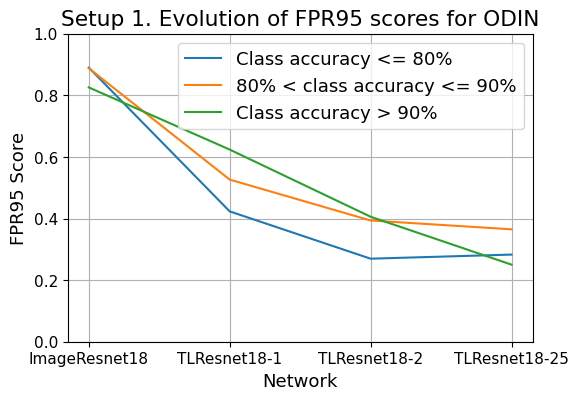

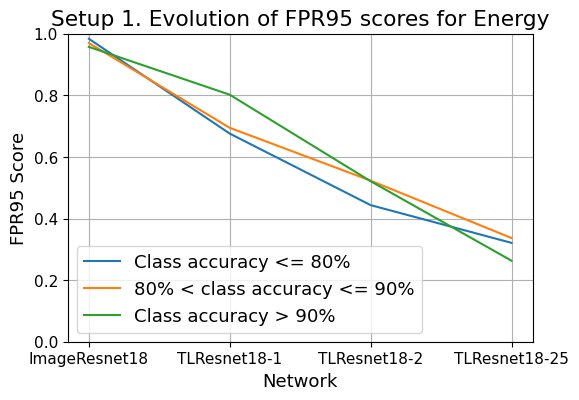

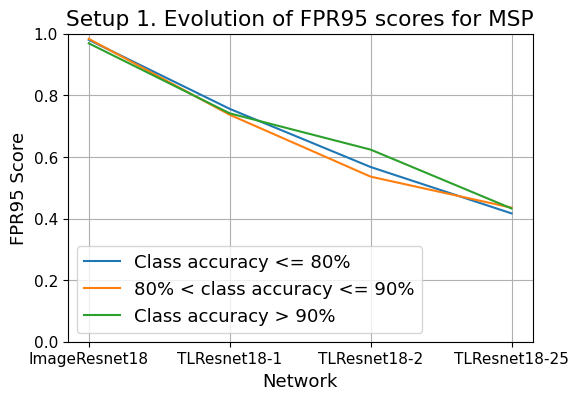

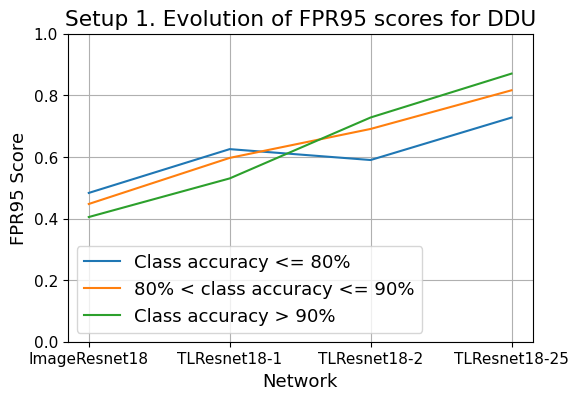

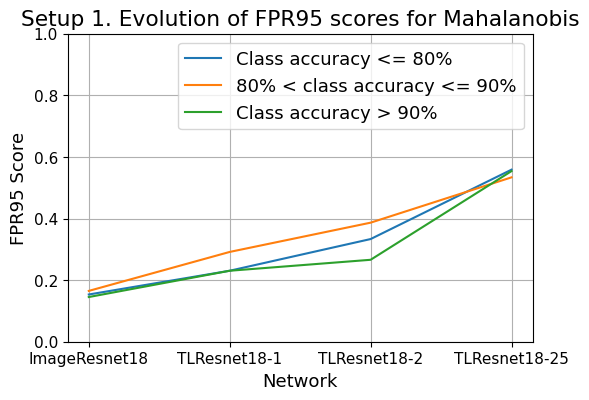

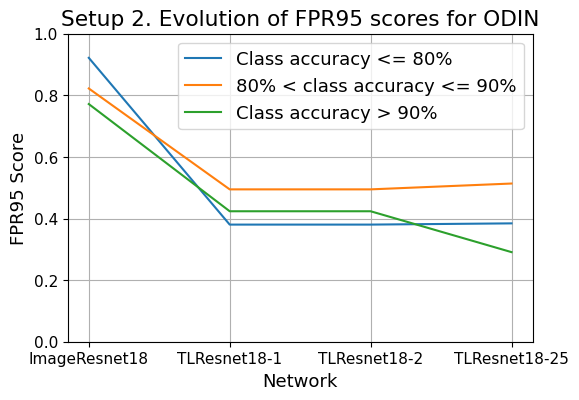

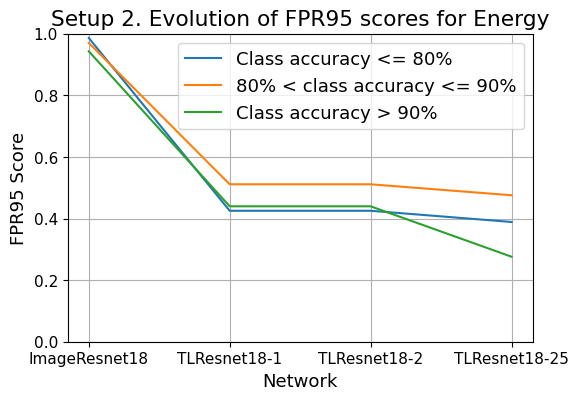

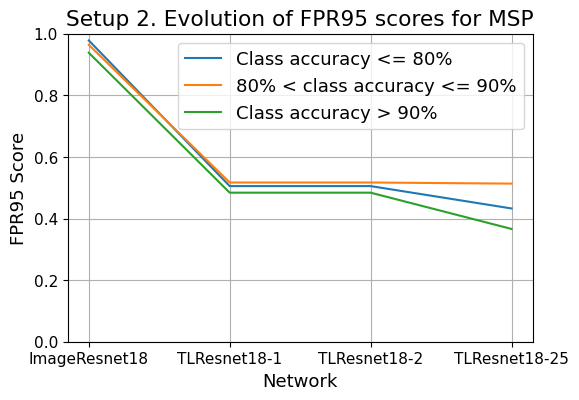

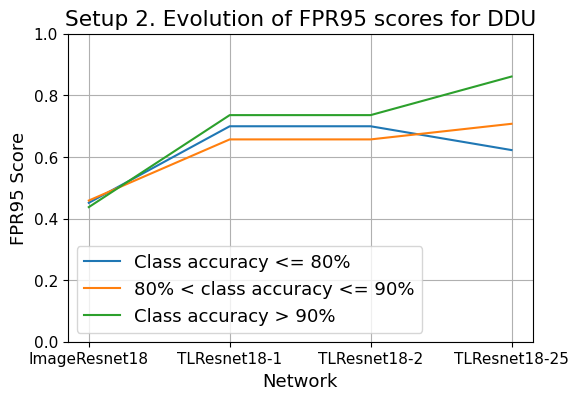

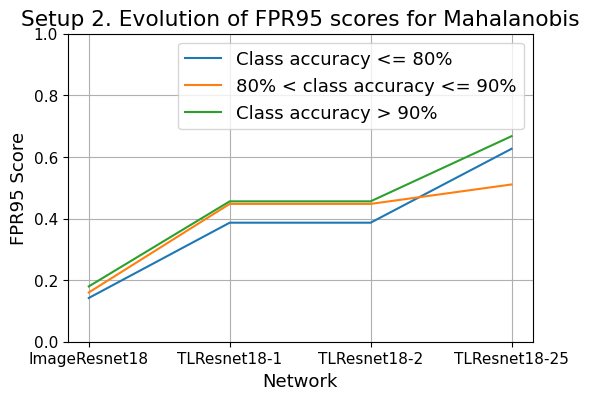

In [100]:
ood_methods = ['ODIN', 'Energy', 'MSP', 'DDU', 'Mahalanobis']
amounts_trained = ['ImageResnet18', 'TLResnet18-1', 'TLResnet18-2', 'TLResnet18-25']
# amounts_trained = ['0 (2.5% acc)', '1 (70% acc)', '2 (75% acc)', '25 (85% acc)']

low_fpr95_data = {
    'ODIN': [low_s1_pt_odin_fpr95, low_s1_res1_odin_fpr95, low_s1_res2_odin_fpr95, low_s1_res25_odin_fpr95],
    'Energy': [low_s1_pt_energy_fpr95, low_s1_res1_energy_fpr95, low_s1_res2_energy_fpr95, low_s1_res25_energy_fpr95],
    'MSP': [low_s1_pt_msp_fpr95, low_s1_res1_msp_fpr95, low_s1_res2_msp_fpr95, low_s1_res25_msp_fpr95],
    'DDU': [low_s1_pt_ddu_fpr95, low_s1_res1_ddu_fpr95, low_s1_res2_ddu_fpr95, low_s1_res25_ddu_fpr95],
    'Mahalanobis': [low_s1_pt_maha_fpr95, low_s1_res1_maha_fpr95, low_s1_res2_maha_fpr95, low_s1_res25_maha_fpr95],
}

mid_fpr95_data = {
    'ODIN': [mid_s1_pt_odin_fpr95, mid_s1_res1_odin_fpr95, mid_s1_res2_odin_fpr95, mid_s1_res25_odin_fpr95],
    'Energy': [mid_s1_pt_energy_fpr95, mid_s1_res1_energy_fpr95, mid_s1_res2_energy_fpr95, mid_s1_res25_energy_fpr95],
    'MSP': [mid_s1_pt_msp_fpr95, mid_s1_res1_msp_fpr95, mid_s1_res2_msp_fpr95, mid_s1_res25_msp_fpr95],
    'DDU': [mid_s1_pt_ddu_fpr95, mid_s1_res1_ddu_fpr95, mid_s1_res2_ddu_fpr95, mid_s1_res25_ddu_fpr95],
    'Mahalanobis': [mid_s1_pt_maha_fpr95, mid_s1_res1_maha_fpr95, mid_s1_res2_maha_fpr95, mid_s1_res25_maha_fpr95],
}

high_fpr95_data = {
    'ODIN': [high_s1_pt_odin_fpr95, high_s1_res1_odin_fpr95, high_s1_res2_odin_fpr95, high_s1_res25_odin_fpr95],
    'Energy': [high_s1_pt_energy_fpr95, high_s1_res1_energy_fpr95, high_s1_res2_energy_fpr95, high_s1_res25_energy_fpr95],
    'MSP': [high_s1_pt_msp_fpr95, high_s1_res1_msp_fpr95, high_s1_res2_msp_fpr95, high_s1_res25_msp_fpr95],
    'DDU': [high_s1_pt_ddu_fpr95, high_s1_res1_ddu_fpr95, high_s1_res2_ddu_fpr95, high_s1_res25_ddu_fpr95],
    'Mahalanobis': [high_s1_pt_maha_fpr95, high_s1_res1_maha_fpr95, high_s1_res2_maha_fpr95, high_s1_res25_maha_fpr95],
}

for ood_method in ood_methods:
    plt.figure(figsize=(6, 4))
    # plt.plot(amounts_trained, low_auroc_data[ood_method], label='AUROC (low acc)')
    # plt.plot(amounts_trained, mid_auroc_data[ood_method], label='AUROC (mid acc)')
    # plt.plot(amounts_trained, high_auroc_data[ood_method], label='AUROC (high acc)')
    plt.plot(amounts_trained, low_fpr95_data[ood_method], label='Class accuracy <= 80%')
    plt.plot(amounts_trained, mid_fpr95_data[ood_method], label='80% < class accuracy <= 90%')
    plt.plot(amounts_trained, high_fpr95_data[ood_method], label='Class accuracy > 90%')
    plt.title(f'Setup 1. Evolution of FPR95 scores for {ood_method}')
    plt.xlabel('Network')
    plt.ylabel('FPR95 Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()



ood_methods = ['ODIN', 'Energy', 'MSP', 'DDU', 'Mahalanobis']
amounts_trained = ['ImageResnet18', 'TLResnet18-1', 'TLResnet18-2', 'TLResnet18-25']

low_fpr95_data = {
    'ODIN': [low_s2_pt_odin_fpr95, low_s2_res2_odin_fpr95, low_s2_res2_odin_fpr95, low_s2_res25_odin_fpr95],
    'Energy': [low_s2_pt_energy_fpr95, low_s2_res2_energy_fpr95, low_s2_res2_energy_fpr95, low_s2_res25_energy_fpr95],
    'MSP': [low_s2_pt_msp_fpr95, low_s2_res2_msp_fpr95, low_s2_res2_msp_fpr95, low_s2_res25_msp_fpr95],
    'DDU': [low_s2_pt_ddu_fpr95, low_s2_res2_ddu_fpr95, low_s2_res2_ddu_fpr95, low_s2_res25_ddu_fpr95],
    'Mahalanobis': [low_s2_pt_maha_fpr95, low_s2_res2_maha_fpr95, low_s2_res2_maha_fpr95, low_s2_res25_maha_fpr95],
}

mid_fpr95_data = {
    'ODIN': [mid_s2_pt_odin_fpr95, mid_s2_res2_odin_fpr95, mid_s2_res2_odin_fpr95, mid_s2_res25_odin_fpr95],
    'Energy': [mid_s2_pt_energy_fpr95, mid_s2_res2_energy_fpr95, mid_s2_res2_energy_fpr95, mid_s2_res25_energy_fpr95],
    'MSP': [mid_s2_pt_msp_fpr95, mid_s2_res2_msp_fpr95, mid_s2_res2_msp_fpr95, mid_s2_res25_msp_fpr95],
    'DDU': [mid_s2_pt_ddu_fpr95, mid_s2_res2_ddu_fpr95, mid_s2_res2_ddu_fpr95, mid_s2_res25_ddu_fpr95],
    'Mahalanobis': [mid_s2_pt_maha_fpr95, mid_s2_res2_maha_fpr95, mid_s2_res2_maha_fpr95, mid_s2_res25_maha_fpr95],
}

high_fpr95_data = {
    'ODIN': [high_s2_pt_odin_fpr95, high_s2_res2_odin_fpr95, high_s2_res2_odin_fpr95, high_s2_res25_odin_fpr95],
    'Energy': [high_s2_pt_energy_fpr95, high_s2_res2_energy_fpr95, high_s2_res2_energy_fpr95, high_s2_res25_energy_fpr95],
    'MSP': [high_s2_pt_msp_fpr95, high_s2_res2_msp_fpr95, high_s2_res2_msp_fpr95, high_s2_res25_msp_fpr95],
    'DDU': [high_s2_pt_ddu_fpr95, high_s2_res2_ddu_fpr95, high_s2_res2_ddu_fpr95, high_s2_res25_ddu_fpr95],
    'Mahalanobis': [high_s2_pt_maha_fpr95, high_s2_res2_maha_fpr95, high_s2_res2_maha_fpr95, high_s2_res25_maha_fpr95],
}

for ood_method in ood_methods:
    plt.figure(figsize=(6, 4))
    # plt.plot(amounts_trained, low_auroc_data[ood_method], label='AUROC (low acc)')
    # plt.plot(amounts_trained, mid_auroc_data[ood_method], label='AUROC (mid acc)')
    # plt.plot(amounts_trained, high_auroc_data[ood_method], label='AUROC (high acc)')
    plt.plot(amounts_trained, low_fpr95_data[ood_method], label='Class accuracy <= 80%')
    plt.plot(amounts_trained, mid_fpr95_data[ood_method], label='80% < class accuracy <= 90%')
    plt.plot(amounts_trained, high_fpr95_data[ood_method], label='Class accuracy > 90%')
    plt.title(f'Setup 2. Evolution of FPR95 scores for {ood_method}')
    plt.xlabel('Network')
    plt.ylabel('FPR95 Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

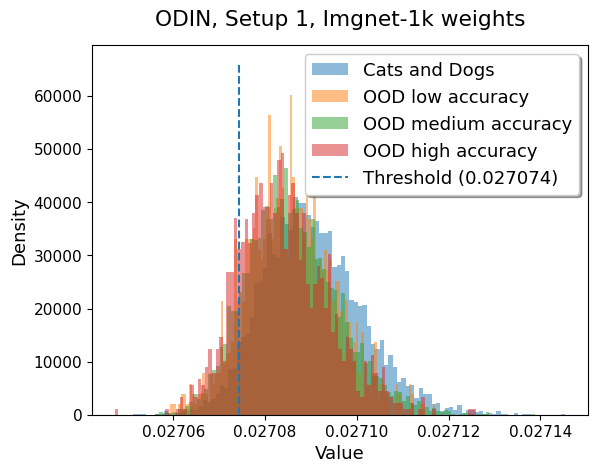

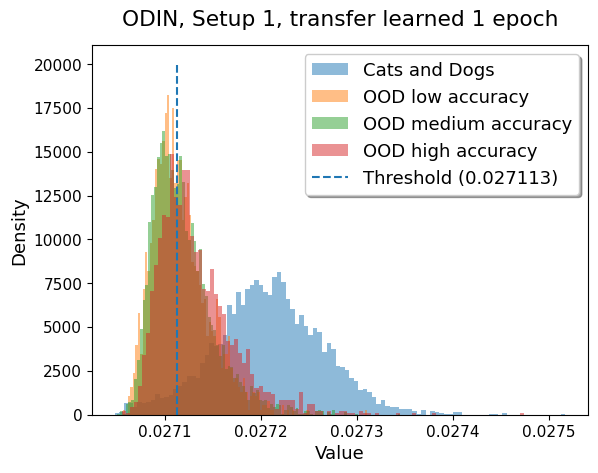

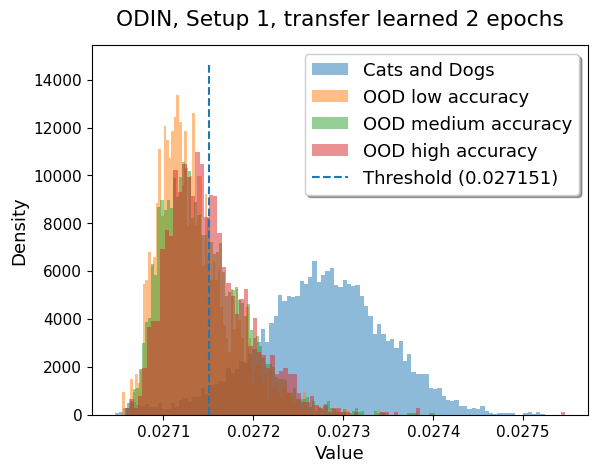

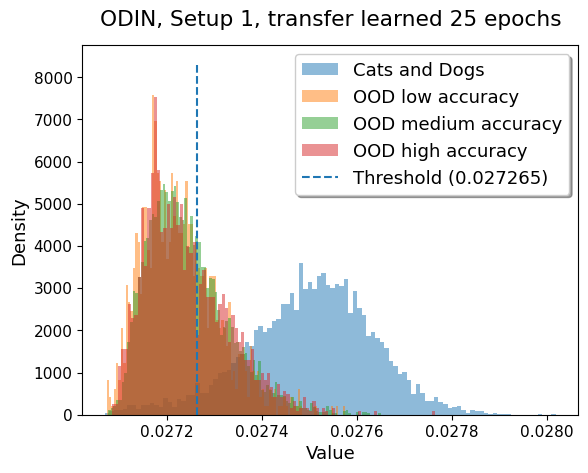

In [68]:
# Can we visualize the histogram in an orderly way to get more insights?
# Nope. So multiline plots it is

def visualizeTripleThresholdOverlay(distID, distOOD1, distOOD2, distOOD3, thresh, title, l1, l2, l3, l4, alpha=0.5, plot = True):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD1 = distOOD1[np.isfinite(distOOD1)]
  distOOD2 = distOOD2[np.isfinite(distOOD2)]
  distOOD3 = distOOD3[np.isfinite(distOOD3)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD1, binsOOD1, _ = plt.hist(distOOD1, bins = 100, density = True, alpha = 0.5, label = l2)
  densOOD2, binsOOD2, _ = plt.hist(distOOD2, bins = 100, density = True, alpha = 0.5, label = l3)
  densOOD3, binsOOD3, _ = plt.hist(distOOD3, bins = 100, density = True, alpha = 0.5, label = l4)

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD1, densOOD2, densOOD3, densID]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()


visualizeTripleThresholdOverlay(turmoil(s12_pt_odin_in_examples), turmoil(low_s1_pt_odin), turmoil(mid_s1_pt_odin), turmoil(high_s1_pt_odin), s1_pt_odin_threshold, "ODIN, Setup 1, Imgnet-1k weights", l1="Cats and Dogs", l2="OOD low accuracy", l3="OOD medium accuracy", l4="OOD high accuracy")
visualizeTripleThresholdOverlay(turmoil(s12_res1_odin_in_examples), turmoil(low_s1_res1_odin), turmoil(mid_s1_res1_odin), turmoil(high_s1_res1_odin), s1_res1_odin_threshold, "ODIN, Setup 1, transfer learned 1 epoch", l1="Cats and Dogs", l2="OOD low accuracy", l3="OOD medium accuracy", l4="OOD high accuracy")
visualizeTripleThresholdOverlay(turmoil(s12_res2_odin_in_examples), turmoil(low_s1_res2_odin), turmoil(mid_s1_res2_odin), turmoil(high_s1_res2_odin), s1_res2_odin_threshold, "ODIN, Setup 1, transfer learned 2 epochs", l1="Cats and Dogs", l2="OOD low accuracy", l3="OOD medium accuracy", l4="OOD high accuracy")
visualizeTripleThresholdOverlay(turmoil(s12_res25_odin_in_examples), turmoil(low_s1_res25_odin), turmoil(mid_s1_res25_odin), turmoil(high_s1_res25_odin), s1_res25_odin_threshold, "ODIN, Setup 1, transfer learned 25 epochs", l1="Cats and Dogs", l2="OOD low accuracy", l3="OOD medium accuracy", l4="OOD high accuracy")

